In [4]:
from finance_calendars import finance_calendars as fc
import pandas as pd
import requests
from bs4 import BeautifulSoup

In [5]:
url = 'https://en.wikipedia.org/wiki/Nasdaq-100'
response = requests.get(url)

# Use BeautifulSoup to parse the HTML content
soup = BeautifulSoup(response.content, 'html.parser')

# Find all tables
tables = soup.findAll('table')

# Assuming the table of interest is the third one (index 2 since Python uses 0-based indexing)
table_of_interest = tables[4]

# Extract ticker symbols from the table
tickers = []
for row in table_of_interest.findAll('tr'):
    cells = row.findAll('td')
    if len(cells) > 1:  # To ensure the row contains data
        ticker_symbol = cells[1].text.strip()  # Assuming the ticker symbol is in the second column
        tickers.append(ticker_symbol)

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import numpy as np
from pytz import timezone
import requests
import time
from tqdm.auto import tqdm
from datetime import timedelta
import math
import requests
from bs4 import BeautifulSoup
from concurrent.futures import ThreadPoolExecutor,  as_completed
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import multiprocessing

Matplotlib is building the font cache; this may take a moment.


In [6]:
earnings = fc.get_earnings_by_date(datetime.datetime(2024, 3, 25, 0, 0))
print(earnings)

                     time                                    name      eps  \
symbol                                                                       
OLK     time-not-supplied                 Olink Holding AB (publ)  ($0.06)   
STOK    time-not-supplied                Stoke Therapeutics, Inc.  ($0.60)   
HEPS    time-not-supplied  D-Market Electronic Services & Trading  ($0.04)   
TMC     time-not-supplied             TMC the metals company Inc.  ($0.11)   
LUNR    time-not-supplied                Intuitive Machines, Inc.  ($0.11)   
DADA    time-not-supplied                      Dada Nexus Limited  ($0.10)   
GHG     time-not-supplied        GreenTree Hospitality Group Ltd.    $0.01   
SMTI    time-not-supplied                     Sanara MedTech Inc.  ($0.03)   
STRO    time-not-supplied                   Sutro Biopharma, Inc.    $0.42   
BKKT    time-not-supplied                    Bakkt Holdings, Inc.  ($0.29)   
EMX     time-not-supplied                 EMX Royalty Corporatio

In [7]:
tqdm.pandas()
api_key = "NahcgY5iZpJiLbXPYqZcgV6RatP09HUV"

In [8]:
def is_weekend(date_obj):
    is_saturday = date_obj.weekday() == 5  # Saturday
    is_sunday = date_obj.weekday() == 6    # Sunday
    return is_saturday or is_sunday
def get_difference(start_date, end_date, span):
    delta = end_date - start_date
    if span == 'day':
        days_difference = delta.days
        return days_difference
    elif span == 'minute':
        seconds_difference = delta.total_seconds()
        minutes_difference = seconds_difference / 60
        return minutes_difference
    elif span == 'second':
        seconds_difference = delta.total_seconds()
        return seconds_difference
    else:
        assert False, "Wrong span"
        
        
def get_query_strings(ticker, start_date, end_date, span, multiplier, prepost_market=False, limit = 30000, api_key="NahcgY5iZpJiLbXPYqZcgV6RatP09HUV"):
    if type(start_date) == str:
        start_date = datetime.datetime.strptime(start_date, "%Y-%m-%d")
    if type(end_date) == str:
        end_date = datetime.datetime.strptime(end_date, "%Y-%m-%d")
    if span == 'second':
        seconds_per_segment = 24 * 3600
    if span == 'minute':
        seconds_per_segment = 24 * 3600 * 30
    if span == 'day':
        seconds_per_segment = 24 * 3600 * 365
    difference = get_difference(start_date, end_date, "second")
    n_segment = int(difference // seconds_per_segment) + 1
    segments = [start_date + timedelta(seconds=i * seconds_per_segment) for i in range(n_segment + 1) if start_date + timedelta(seconds=i * seconds_per_segment) < end_date]
    segments.append(end_date+timedelta(days=1))
    querys = []
    for s, e in zip(segments[:-1], segments[1:]):
        if s.weekday() == 5 and (e-s).days <= 2:
            continue
        if s.weekday() == 6 and (e-s).days <= 1:
            continue
        from_date = s.strftime("%Y-%m-%d")
        to_date = (e-timedelta(days=1)).strftime("%Y-%m-%d")
        query = f"https://api.polygon.io/v2/aggs/ticker/{ticker}/range/1/{span}/{from_date}/{to_date}?adjusted=true&sort=asc&limit={limit}&apiKey={api_key}"
        querys.append(query)
    return querys
def post_request(query_string):
    try:
        res_df = pd.DataFrame().from_records(requests.get(query_string).json()['results'])
        res_df['datetime'] = res_df['t'].apply(lambda x: datetime.datetime.fromtimestamp(x / 1000, timezone('US/Eastern')).strftime('%Y-%m-%d-%H:%M:%S'))
        res_df['date'] = res_df['datetime'].apply(lambda x:'-'.join(x.split('-')[:3]))
        res_df['time'] = res_df['datetime'].apply(lambda x:'-'.join(x.split('-')[3:]))
        return res_df
    except requests.exceptions.RequestException as e:
        print(str(e))
    except KeyError as e2:
        print(str(e2), print(query_string))


In [9]:
def calculate_sharpe_ratio_from_returns(returns, risk_free_rate):
    """
    Calculate the Sharpe Ratio from a sequence of investment returns and a risk-free rate.

    Parameters:
    - returns (list of float): The sequence of investment returns.
    - risk_free_rate (float): The risk-free rate per period.

    Returns:
    - float: The Sharpe Ratio.
    """
    # Convert the sequence of returns and the risk-free rate to a numpy array for efficient computation
    returns = np.array(returns)
    
    # Calculate the average return of the investment
    average_return = np.mean(returns)
    
    # Calculate the standard deviation of the returns
    standard_deviation = np.std(returns)
    
    # Calculate the Sharpe Ratio
    sharpe_ratio = (average_return - risk_free_rate) / standard_deviation
    
    return sharpe_ratio

In [10]:
from_date = "2024-01-01"
to_date = "2024-04-06"

In [11]:
querys = get_query_strings("QQQ", from_date, to_date, 'minute', 1)
results = []
with tqdm(total=len(querys)) as pbar:
    with ThreadPoolExecutor(max_workers=16) as ex:
        futures = [ex.submit(post_request, q) for q in querys]
        for future in as_completed(futures):
            result = future.result()
            results.append(result)
            pbar.update(1)
res_df = pd.concat(results).sort_values(by='t', ascending=True).reset_index(drop=True)

  0%|          | 0/4 [00:00<?, ?it/s]

In [567]:
querys = get_query_strings("QQQ", from_date, to_date, 'day', 1)
results = []
with tqdm(total=len(querys)) as pbar:
    with ThreadPoolExecutor(max_workers=16) as ex:
        futures = [ex.submit(post_request, q) for q in querys]
        for future in as_completed(futures):
            result = future.result()
            results.append(result)
            pbar.update(1)
res_df_day = pd.concat(results).sort_values(by='t', ascending=True).reset_index(drop=True)

  0%|          | 0/1 [00:00<?, ?it/s]

In [568]:
res_df = res_df[res_df['time'].progress_apply(lambda x:datetime.datetime.strptime(x,"%H:%M:%S")<=datetime.datetime.strptime("16:16:00","%H:%M:%S"))]
res_df = res_df[res_df['time'].progress_apply(lambda x:datetime.datetime.strptime(x,"%H:%M:%S")>=datetime.datetime.strptime("9:30:00","%H:%M:%S"))]

  0%|          | 0/55868 [00:00<?, ?it/s]

  0%|          | 0/44835 [00:00<?, ?it/s]

In [569]:
label = {}
for date in tqdm(res_df.date.unique()):
    res_df_date = res_df[res_df["date"] == date]
    closing = res_df_date.iloc[-1]['c']
    min_around_1230 = res_df_date[res_df_date.apply(lambda x:
                                                        (datetime.datetime.strptime(x['time'],"%H:%M:%S")>=datetime.datetime.strptime("15:20:00","%H:%M:%S") and 
                                                        datetime.datetime.strptime(x['time'],"%H:%M:%S")<=datetime.datetime.strptime("15:40:00","%H:%M:%S")), axis = 1
                                                       )]['c'].min()
    after_1230 = res_df_date[res_df_date.apply(lambda x: datetime.datetime.strptime(x['time'], "%H:%M:%S") >= datetime.datetime.strptime("15:30:00","%H:%M:%S"),axis = 1)]['c']
    condition_price_change = (closing / min_around_1230 -1) > 0.003
    x = after_1230.reset_index(drop=True).index.values.reshape(-1,1)
    y = after_1230.values
    volatility = np.log(after_1230 / after_1230.shift(1)).std() * np.sqrt(252) 
    model = LinearRegression()
    model.fit(x, y)
    label[date] = condition_price_change and r2_score(y, model.predict(x)) > 0.5 and volatility < 0.01
    

  0%|          | 0/66 [00:00<?, ?it/s]

2024-01-02


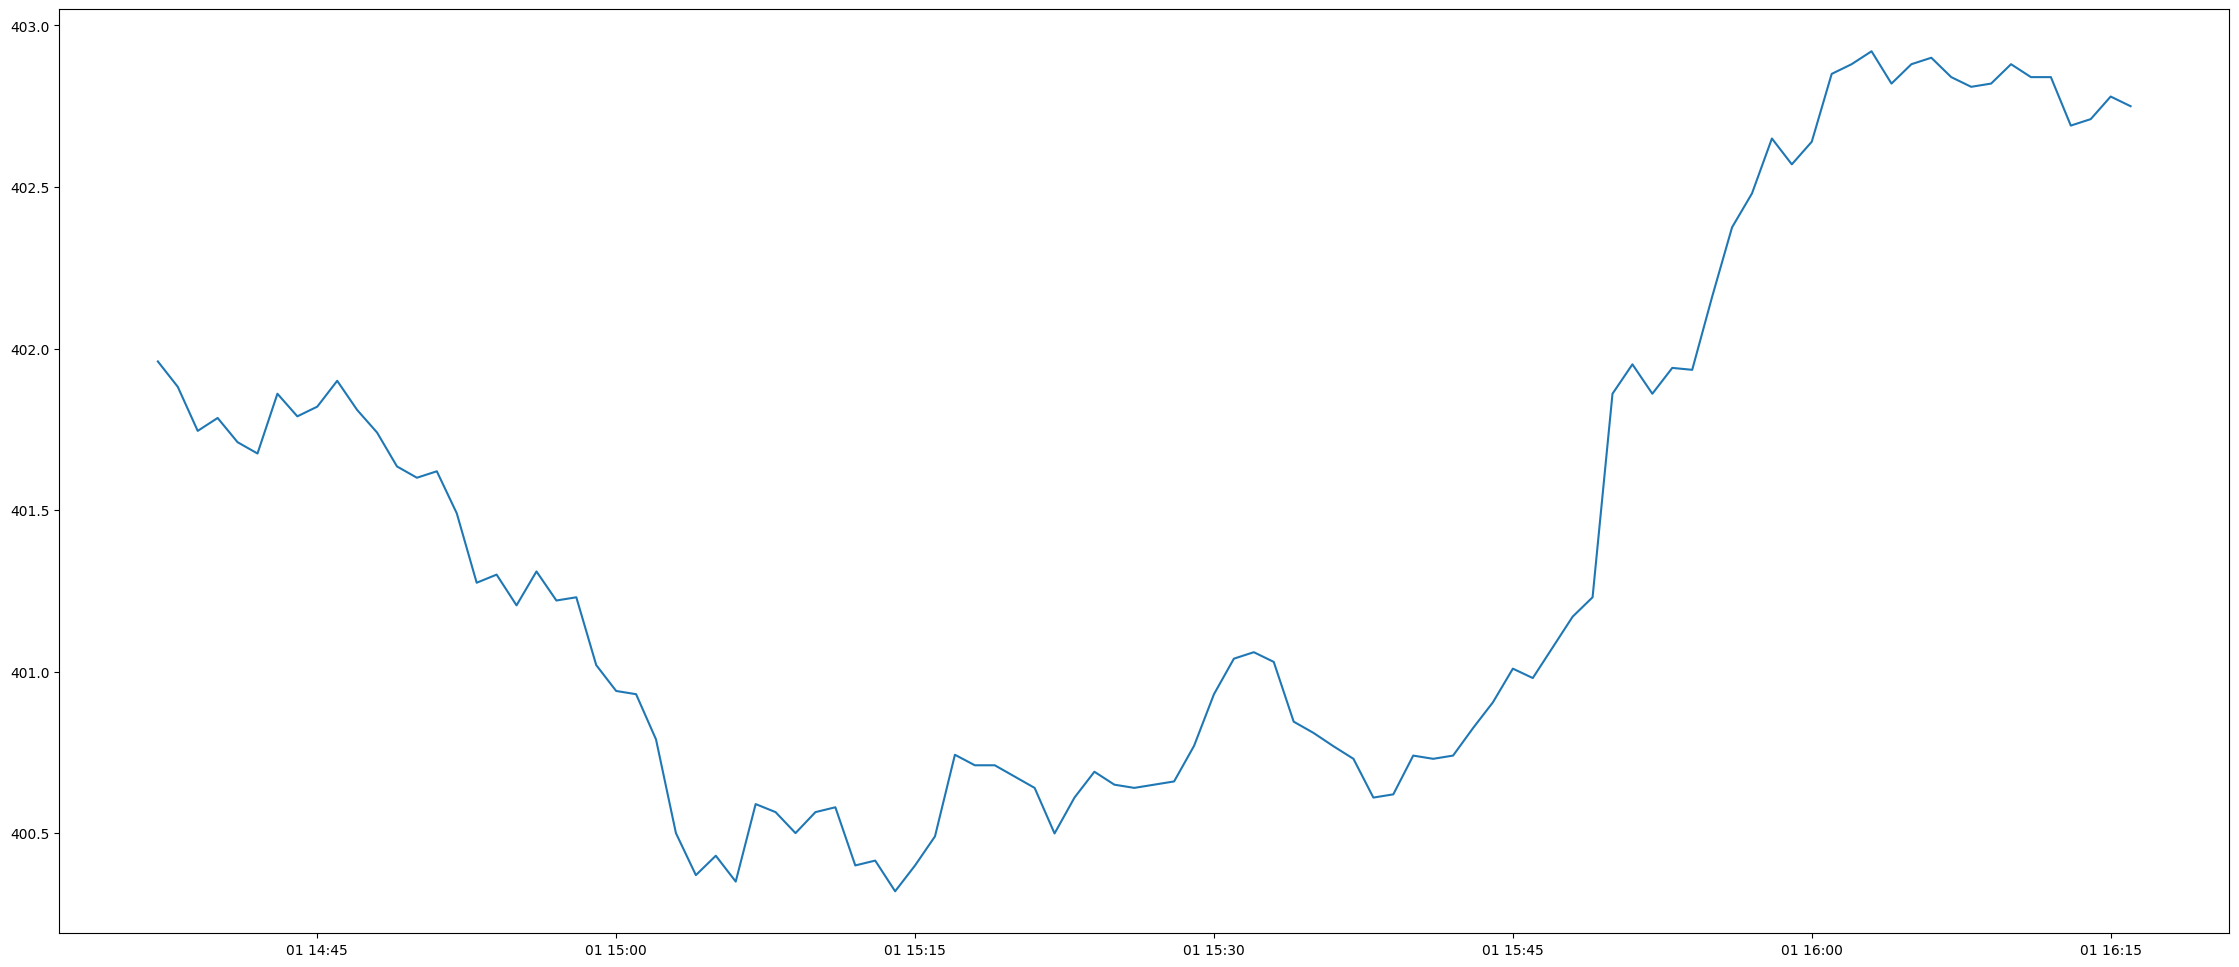

2024-01-05


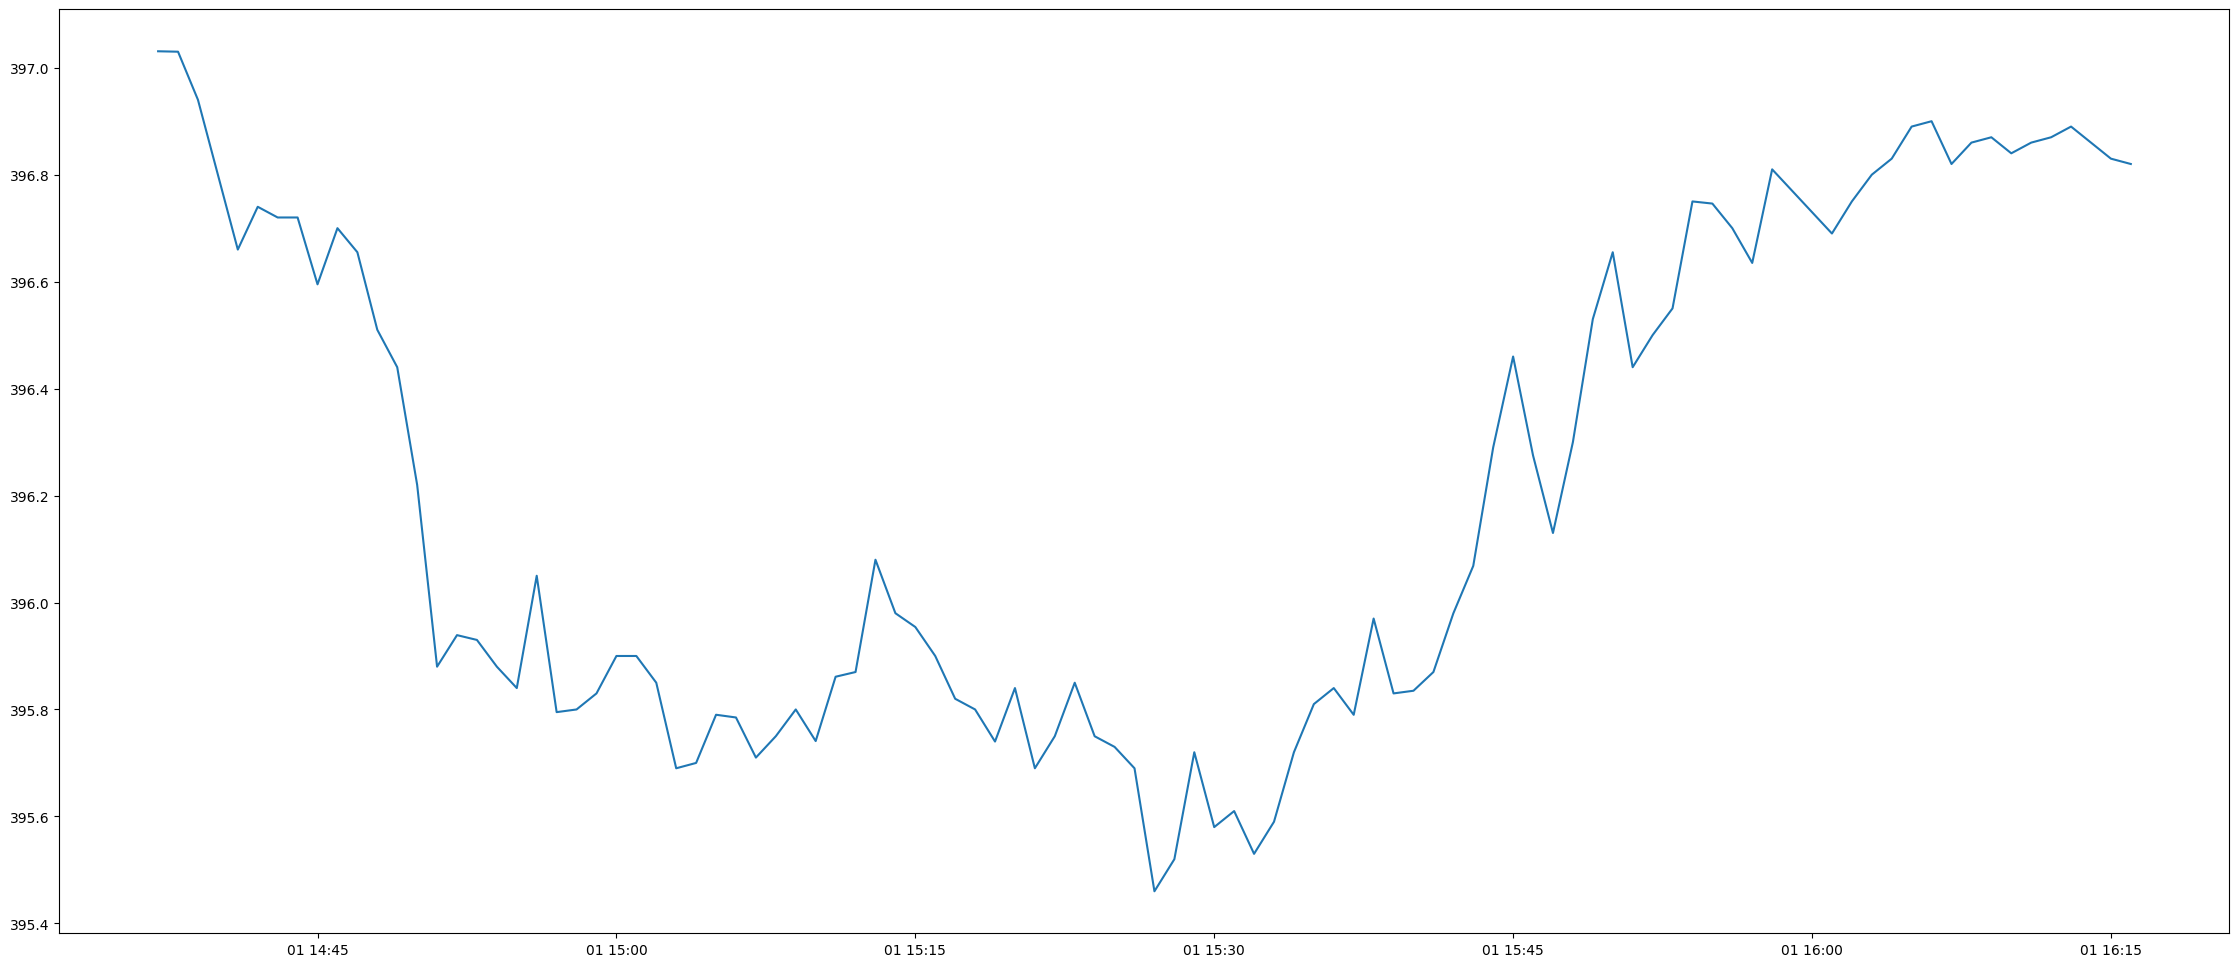

2024-01-17


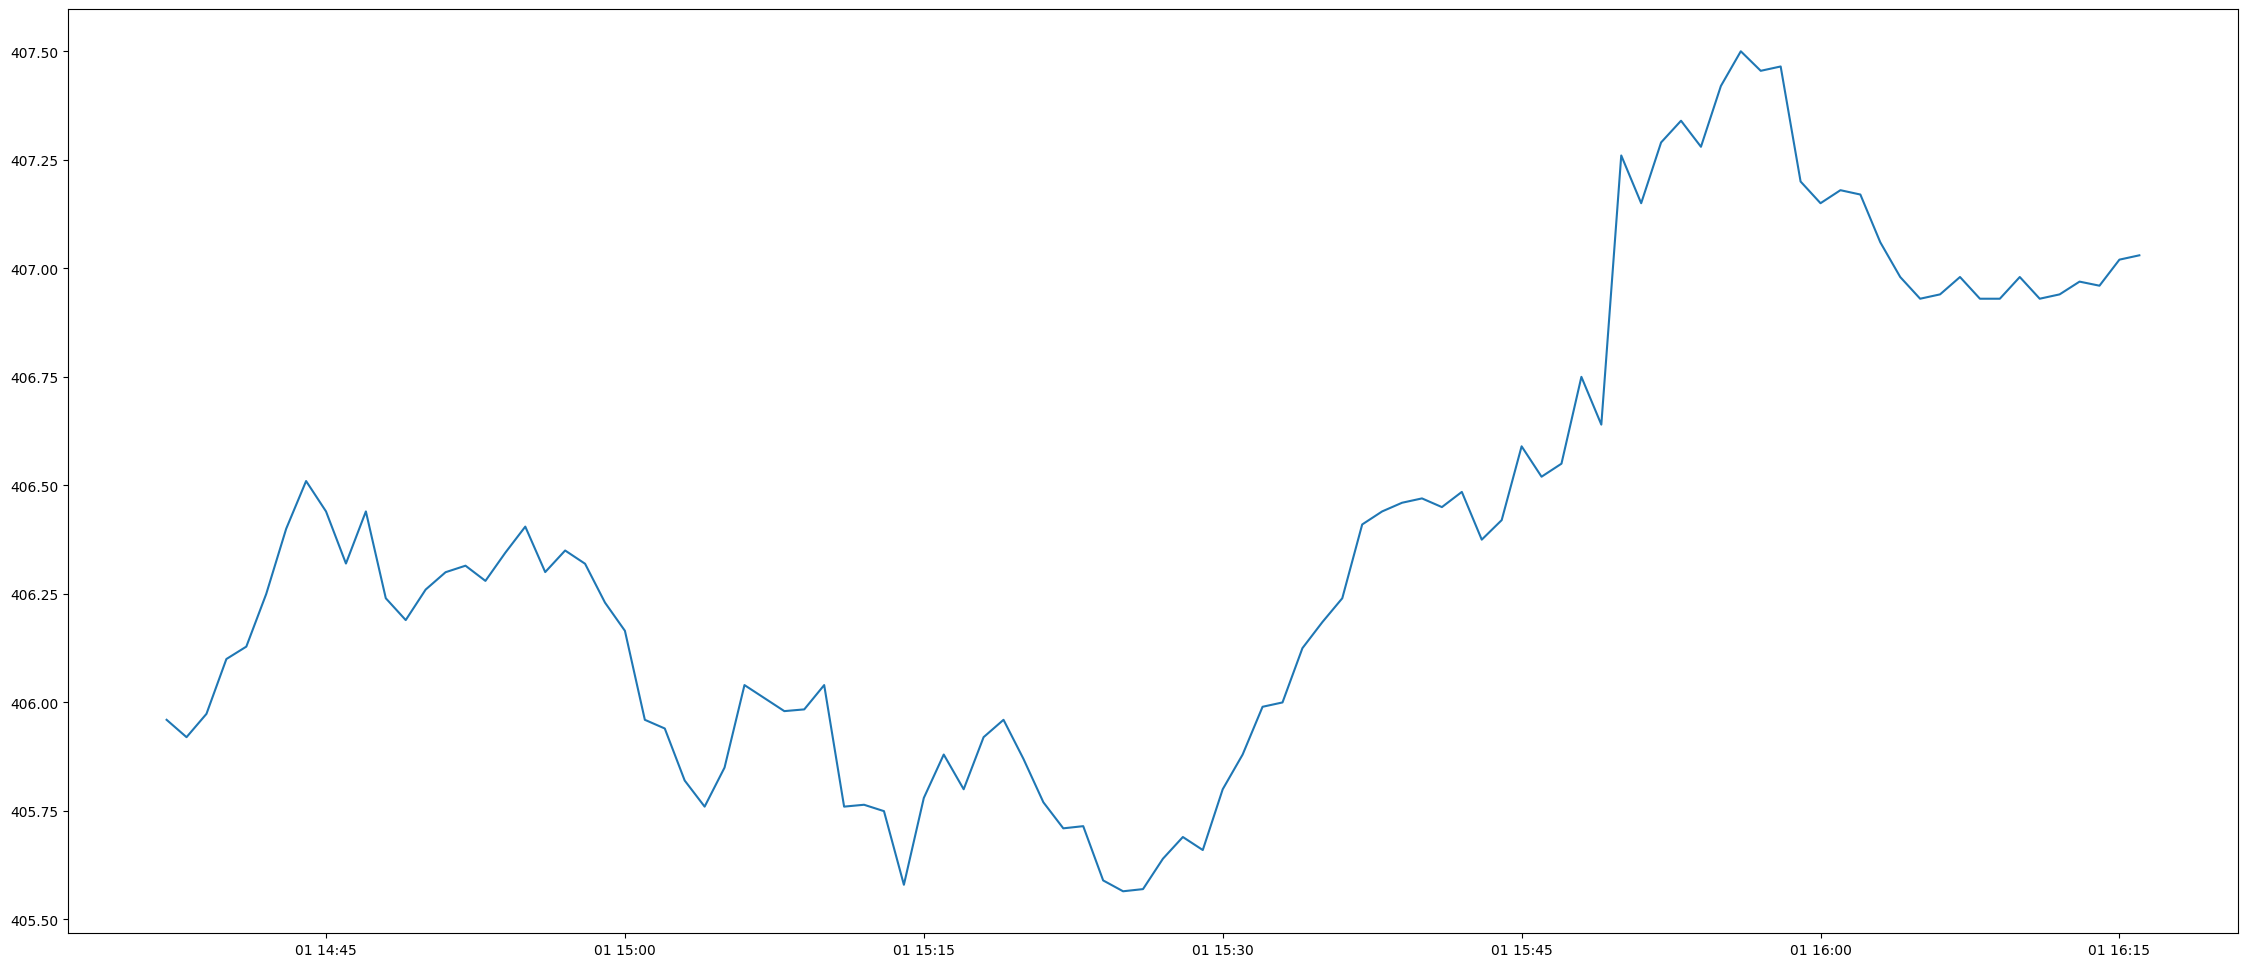

2024-02-13


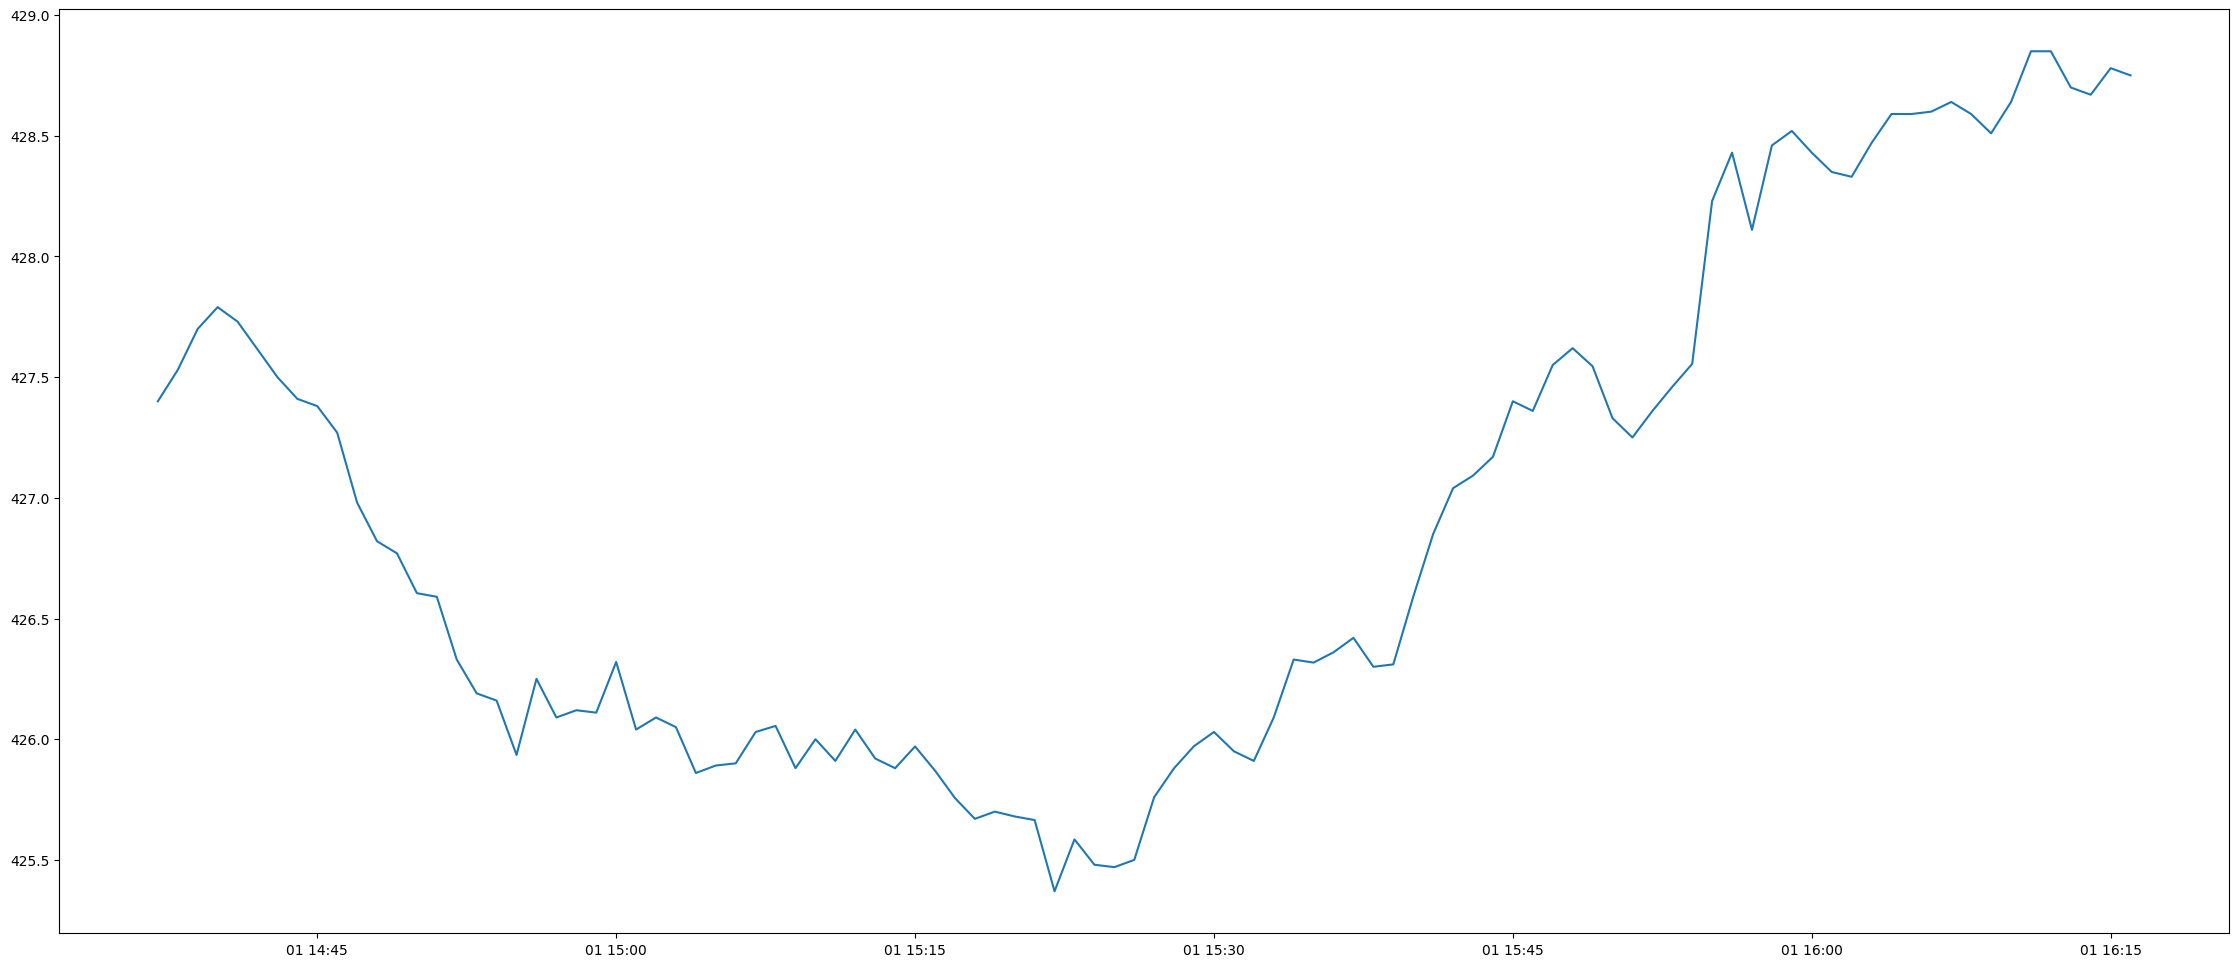

2024-02-14


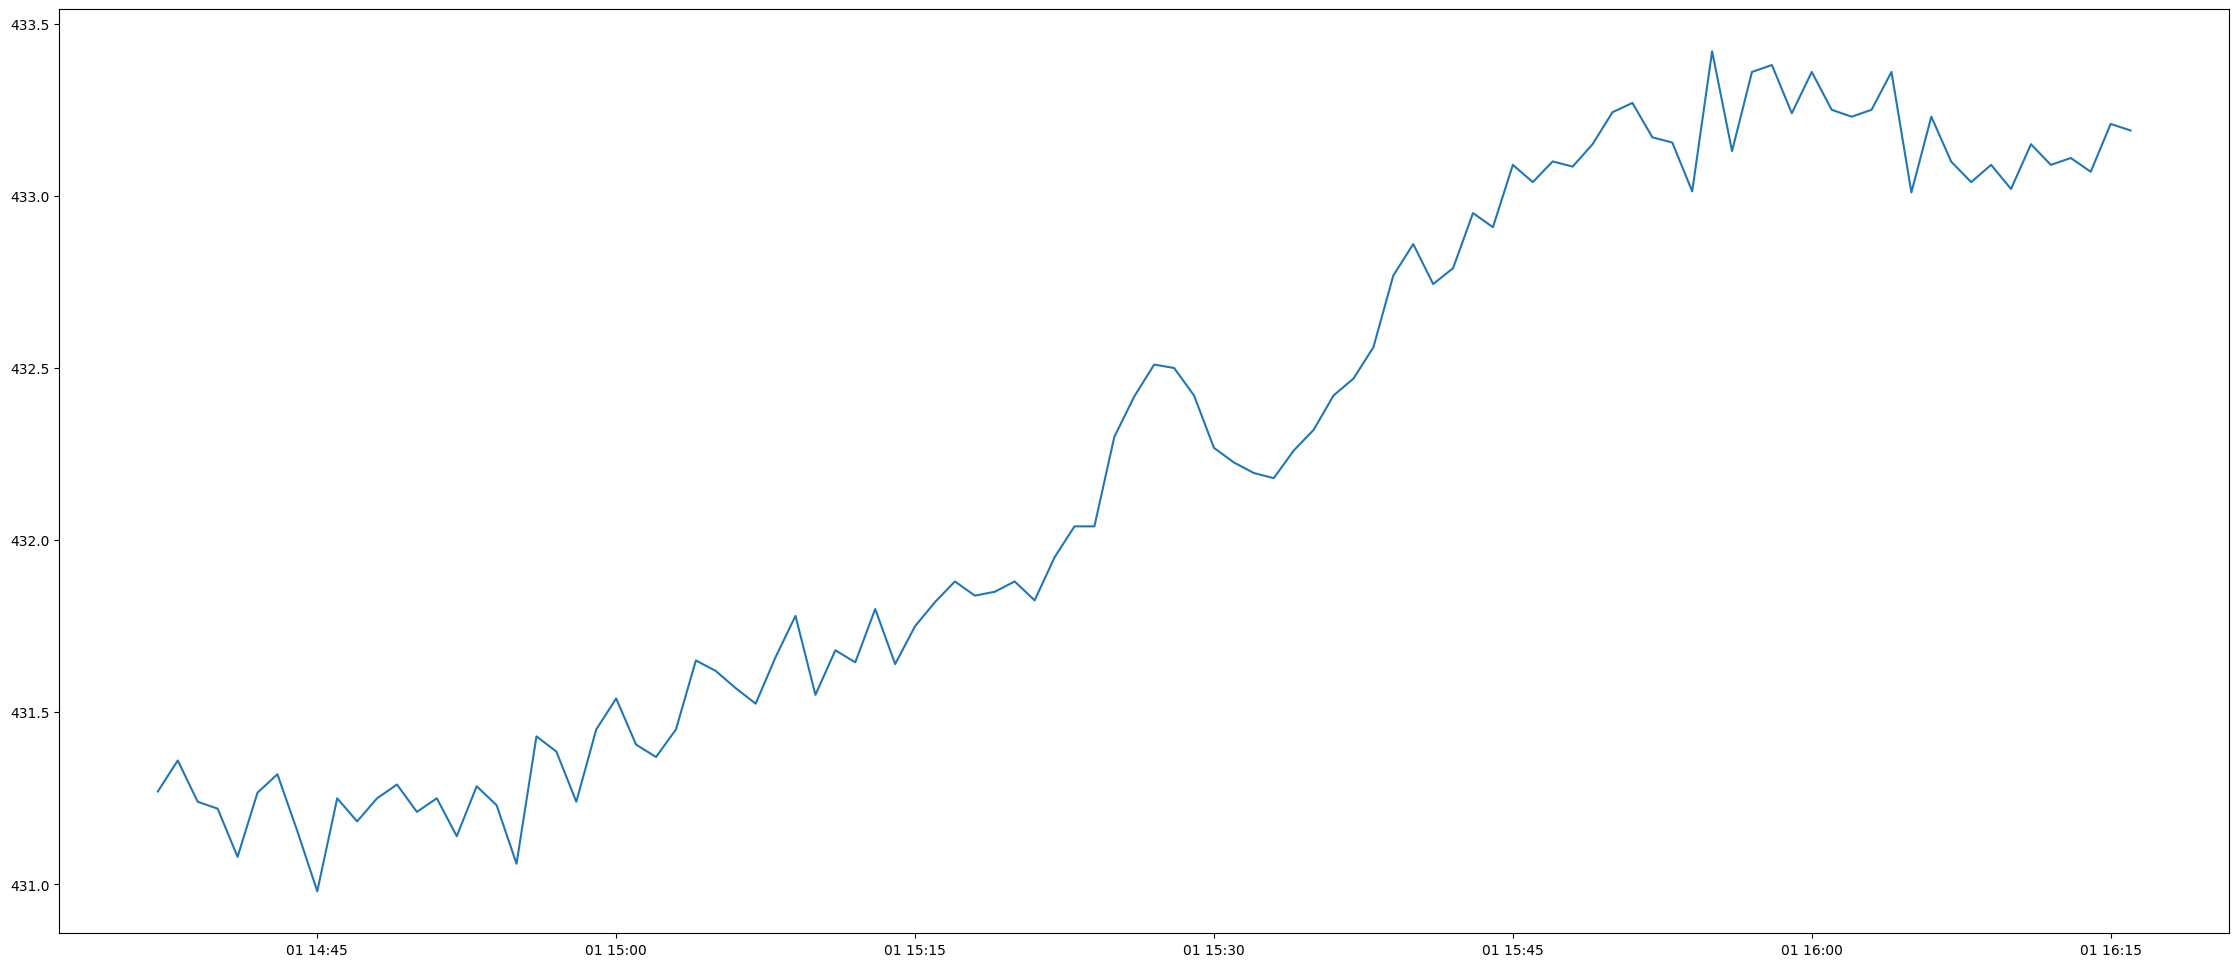

2024-02-15


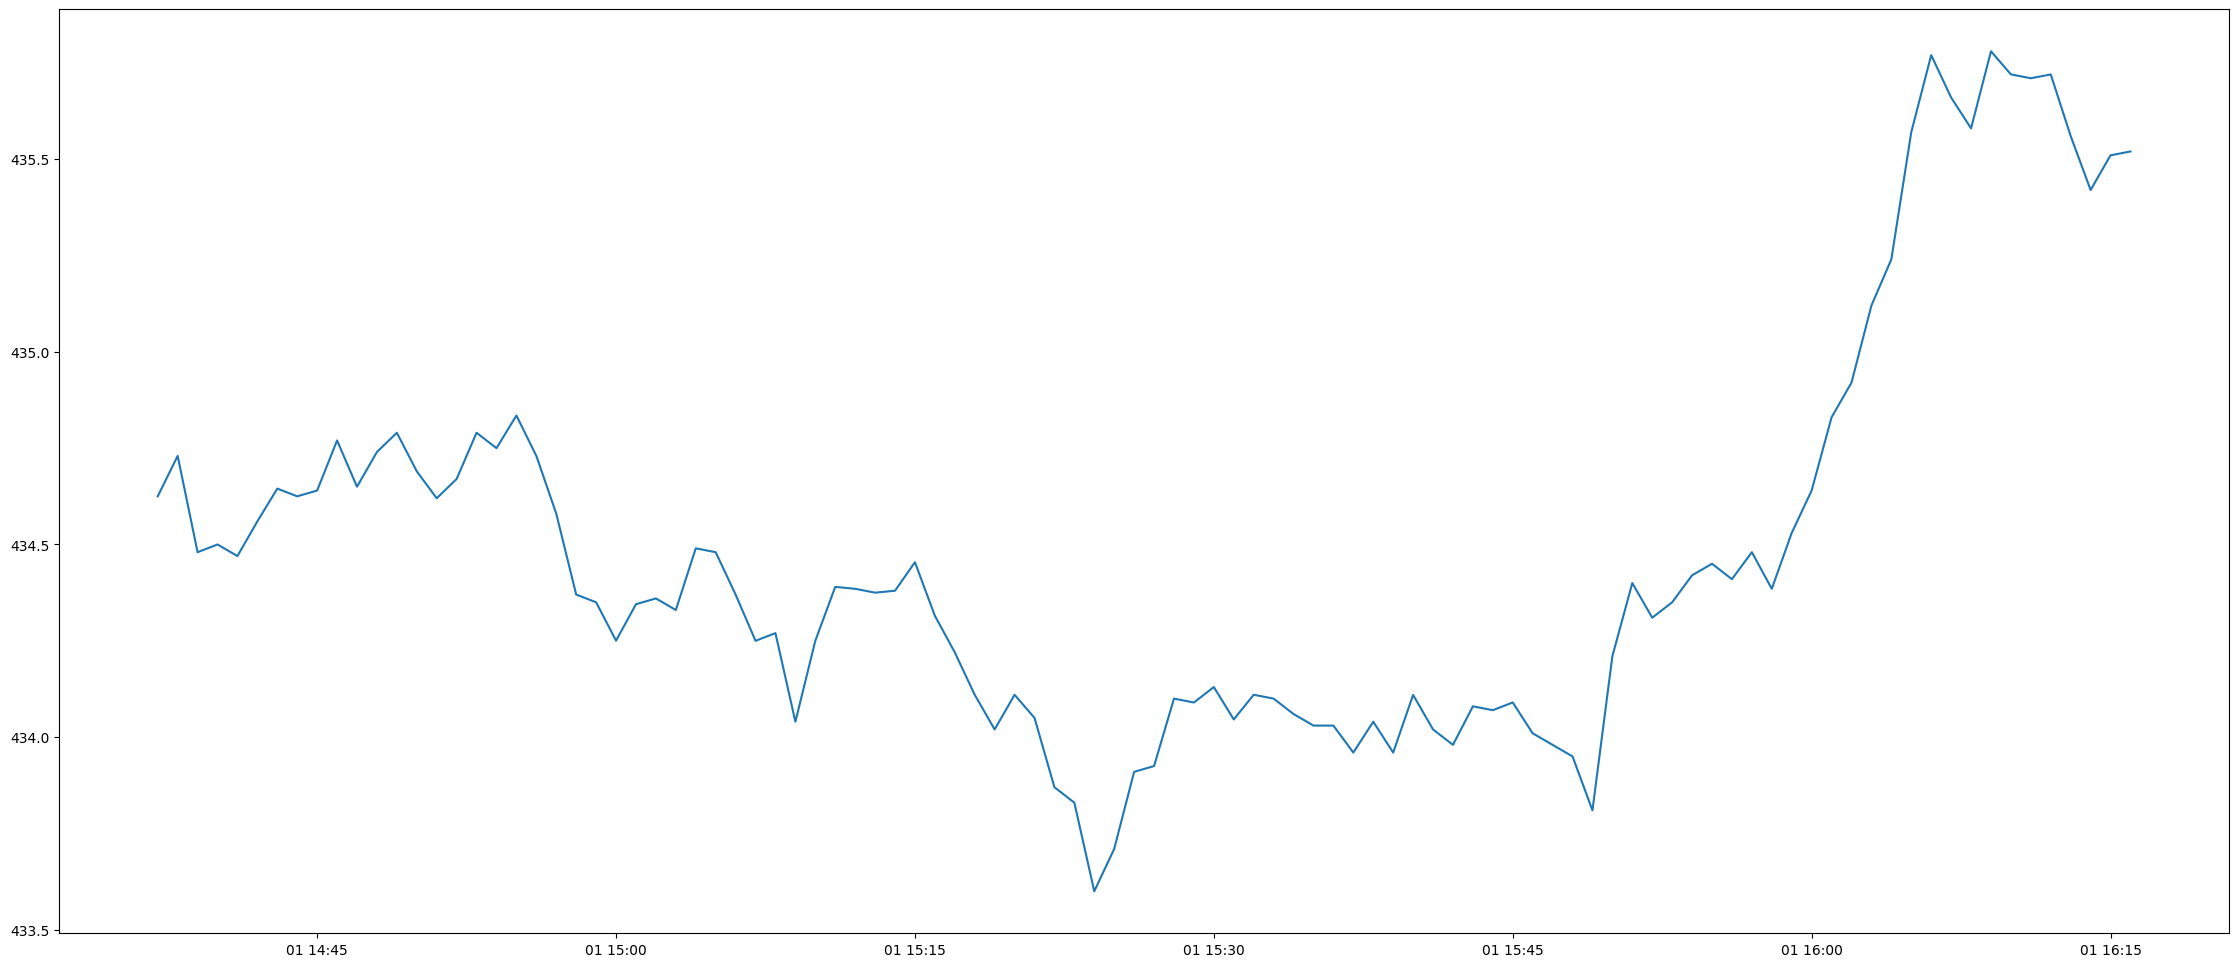

2024-02-21


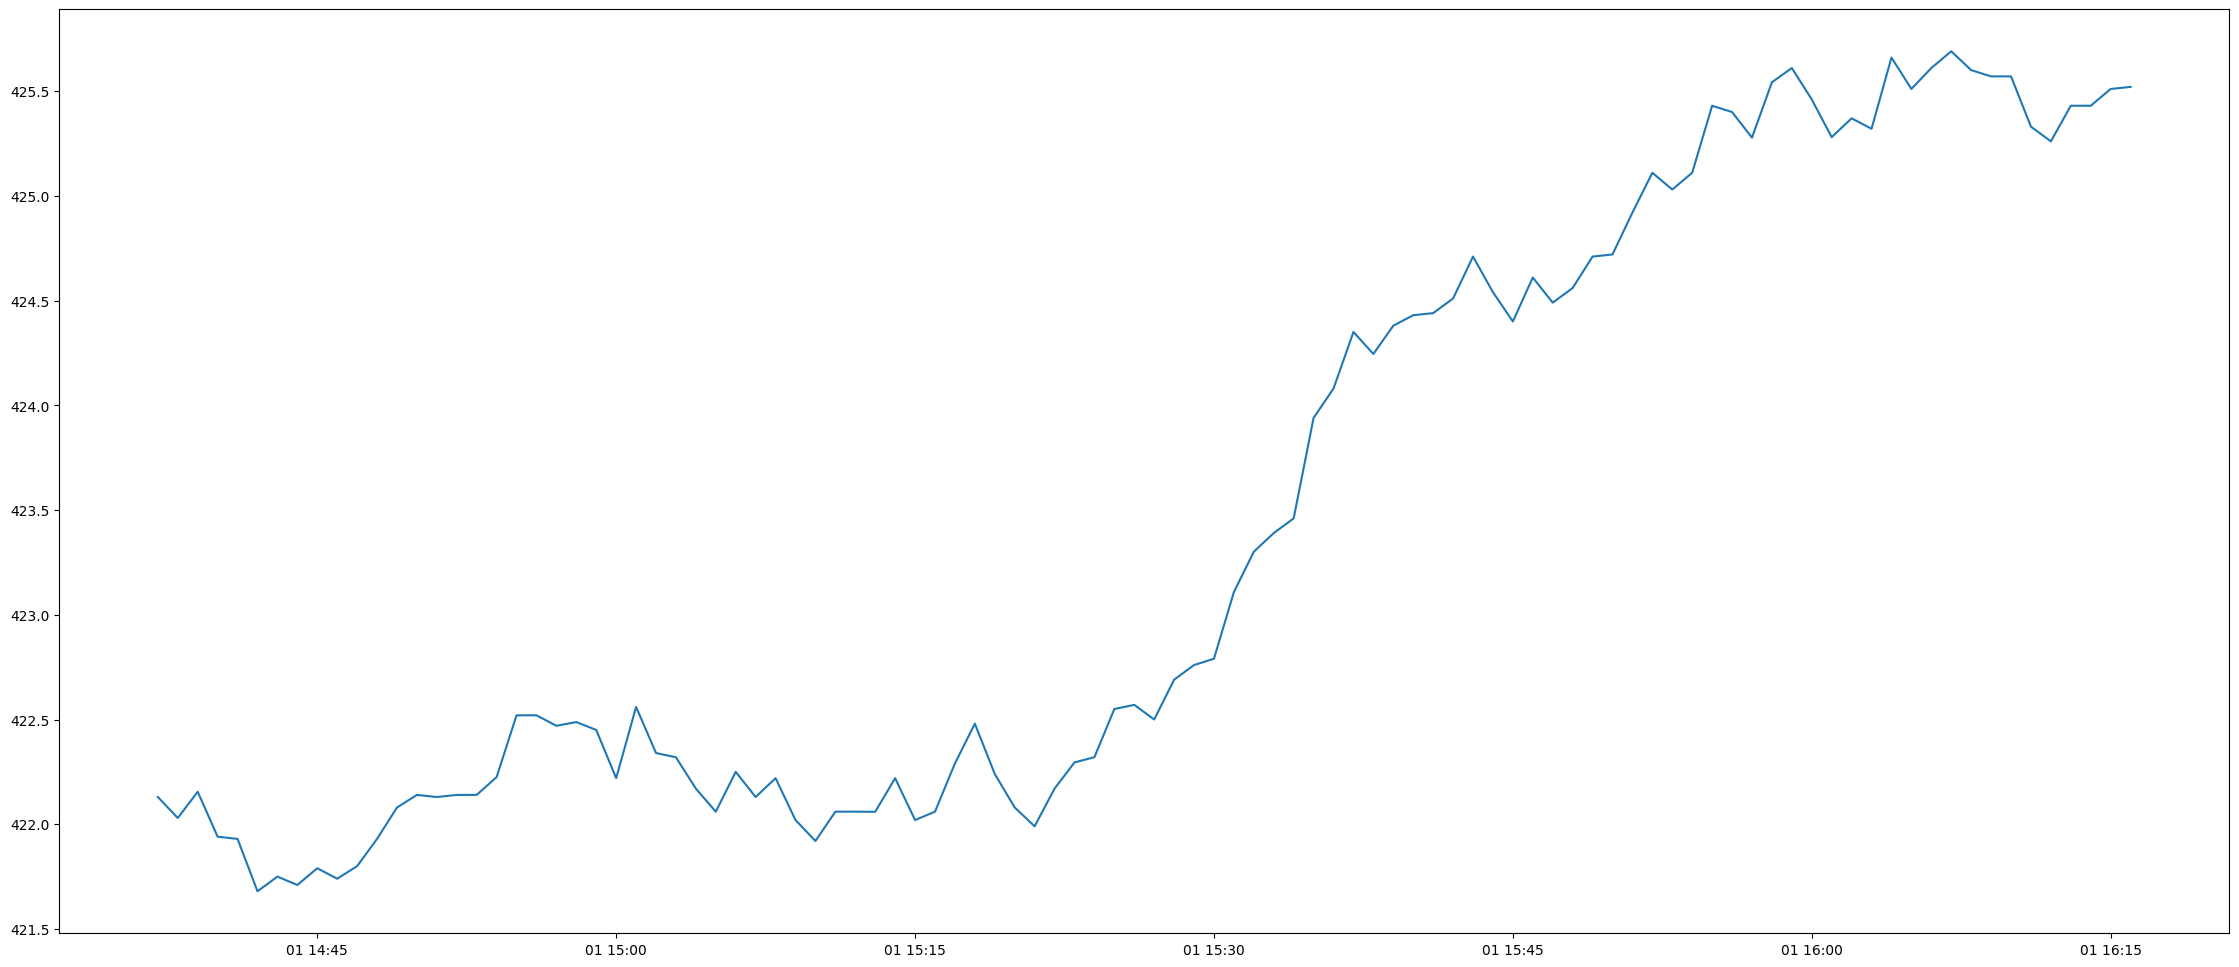

2024-03-05


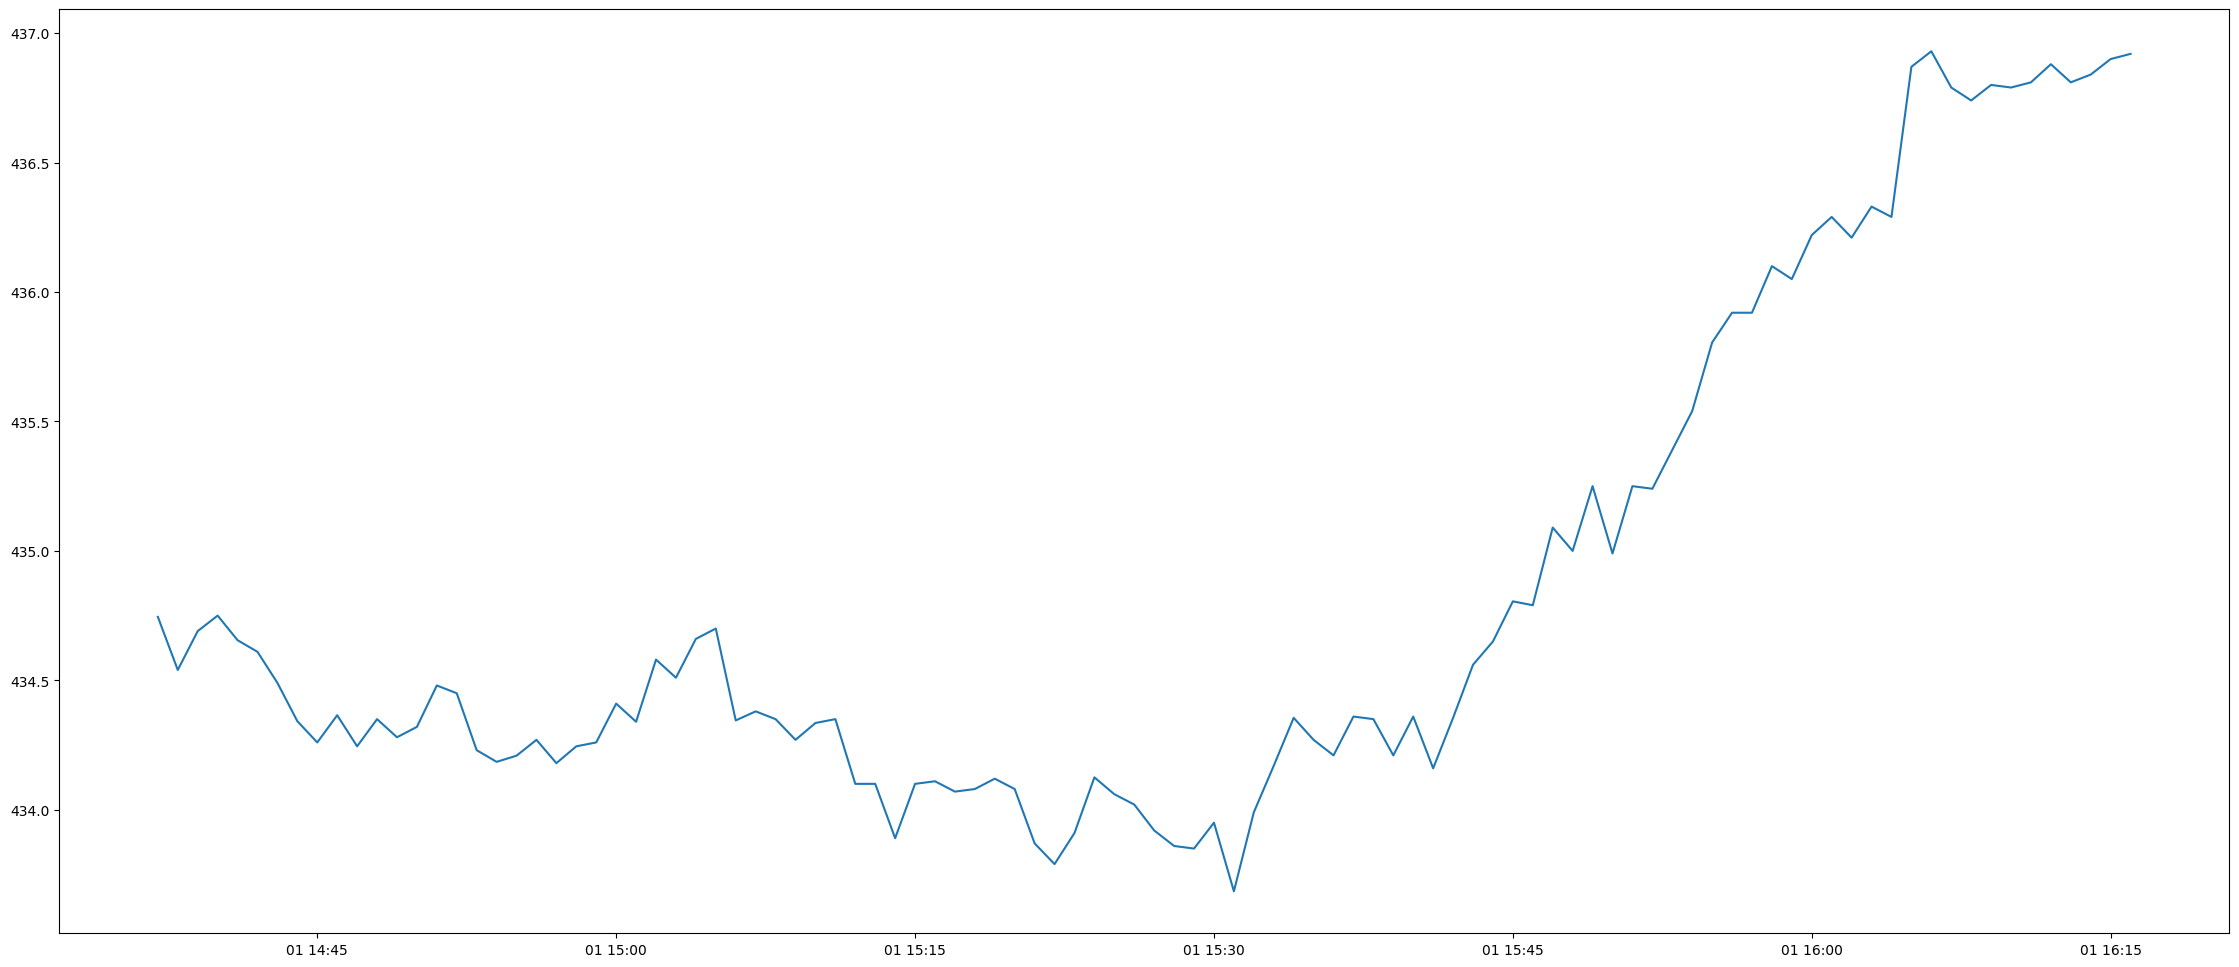

2024-03-14


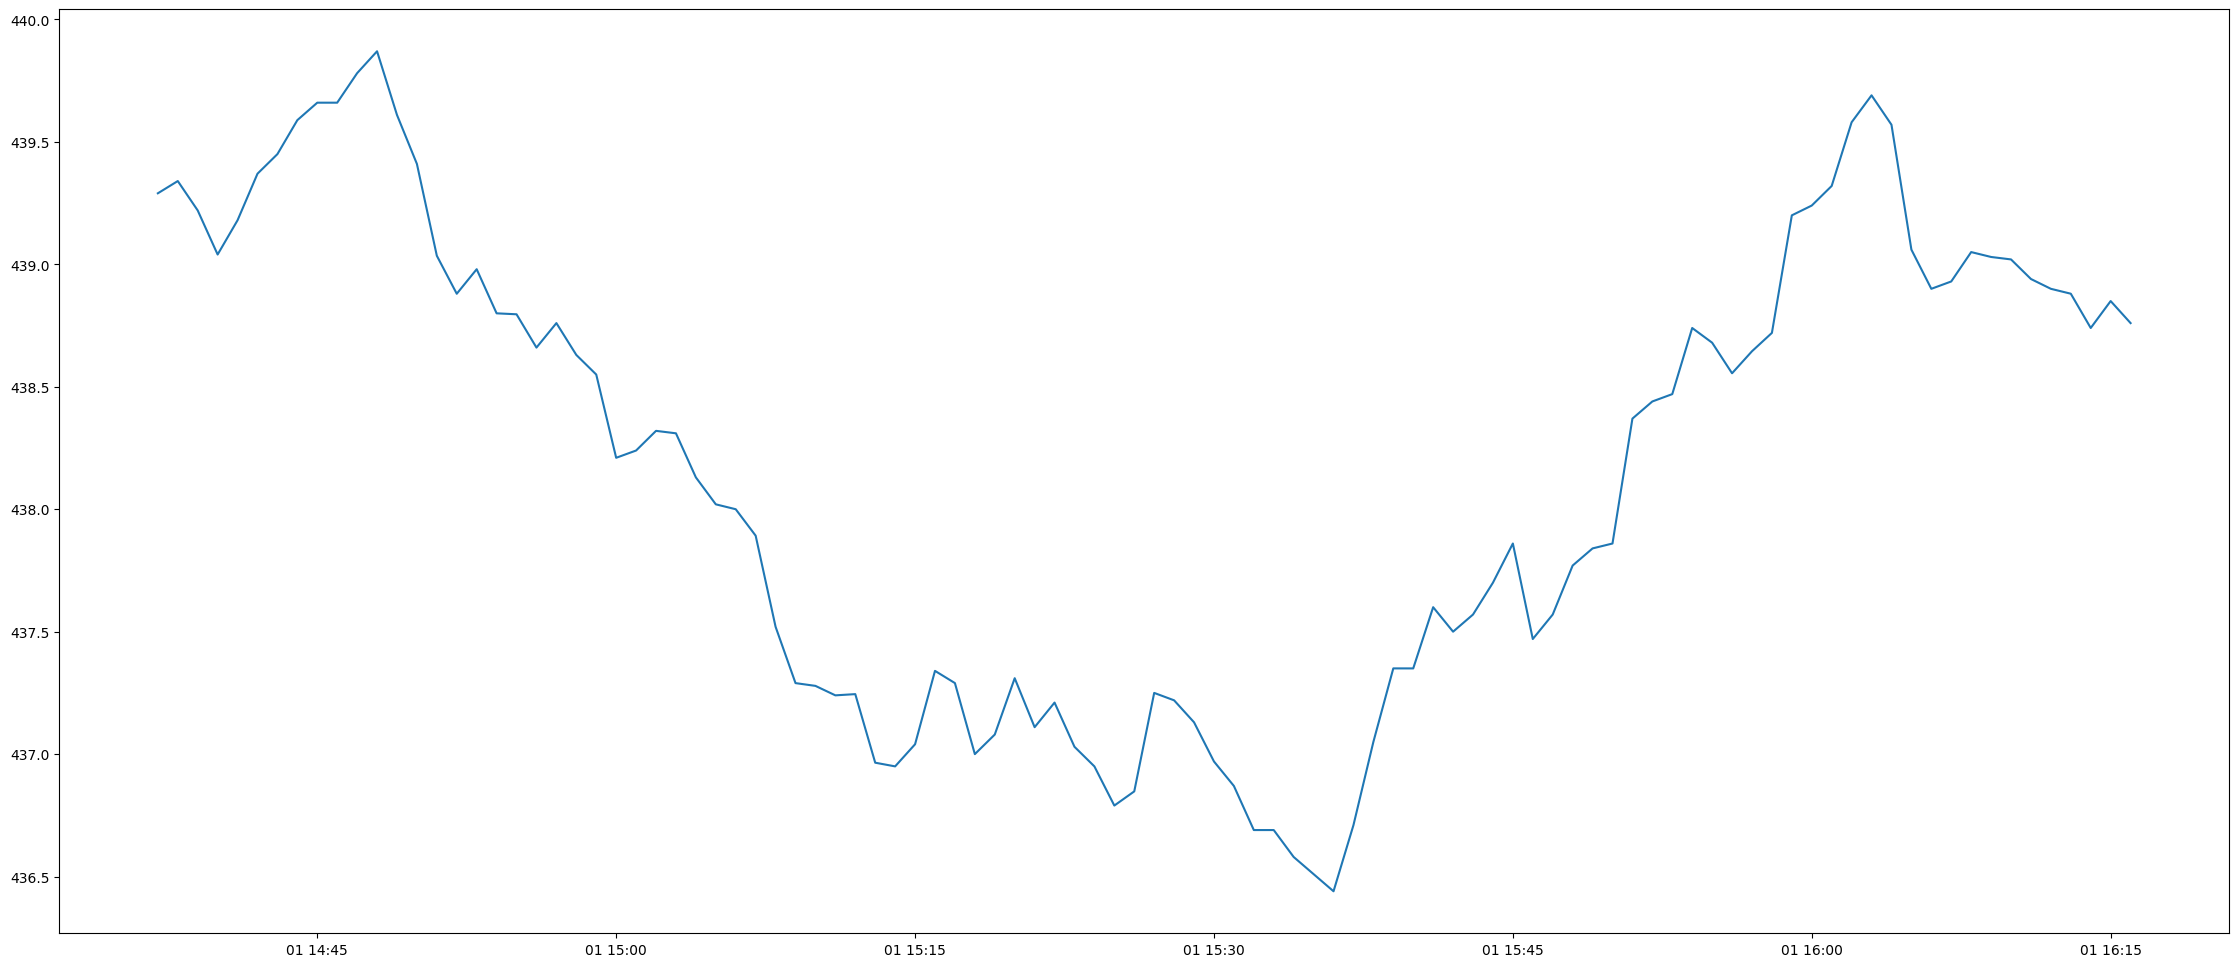

2024-03-27


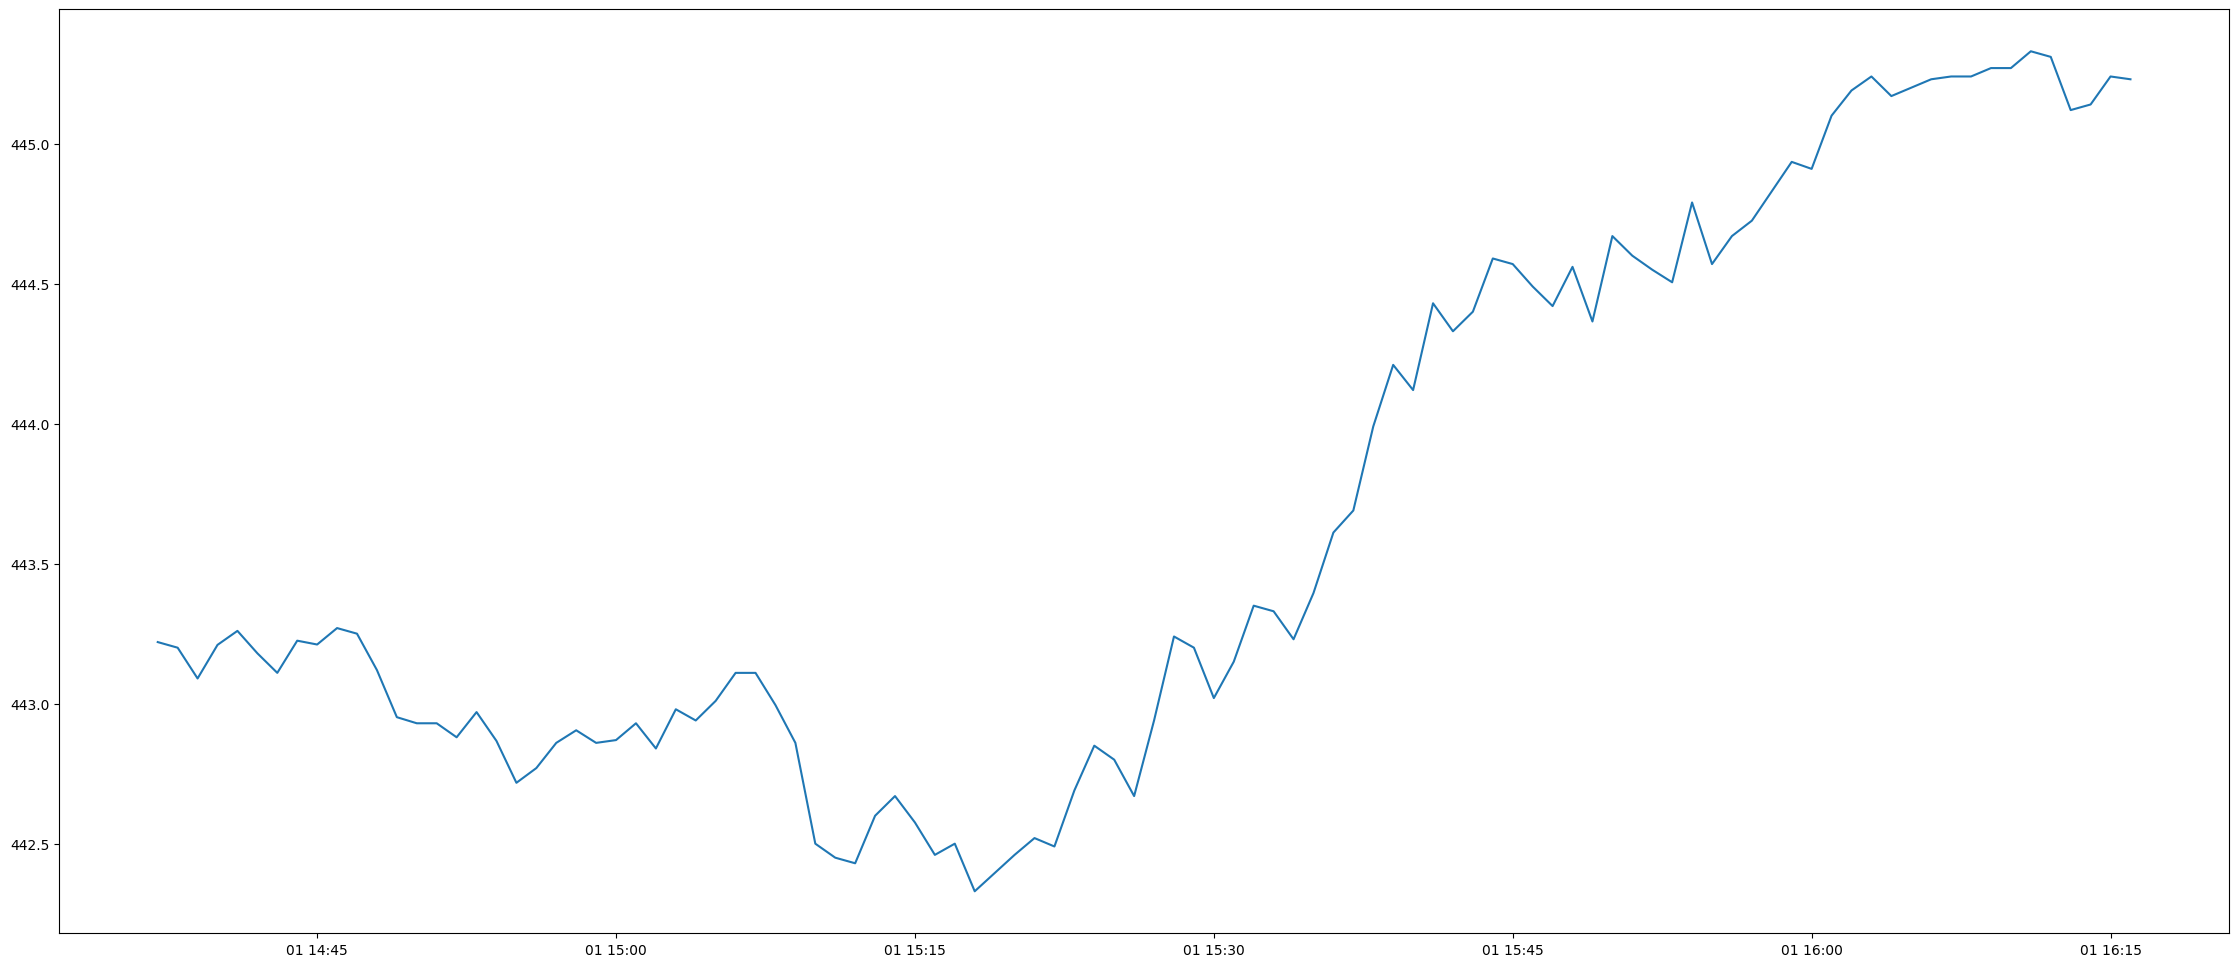

2024-04-03


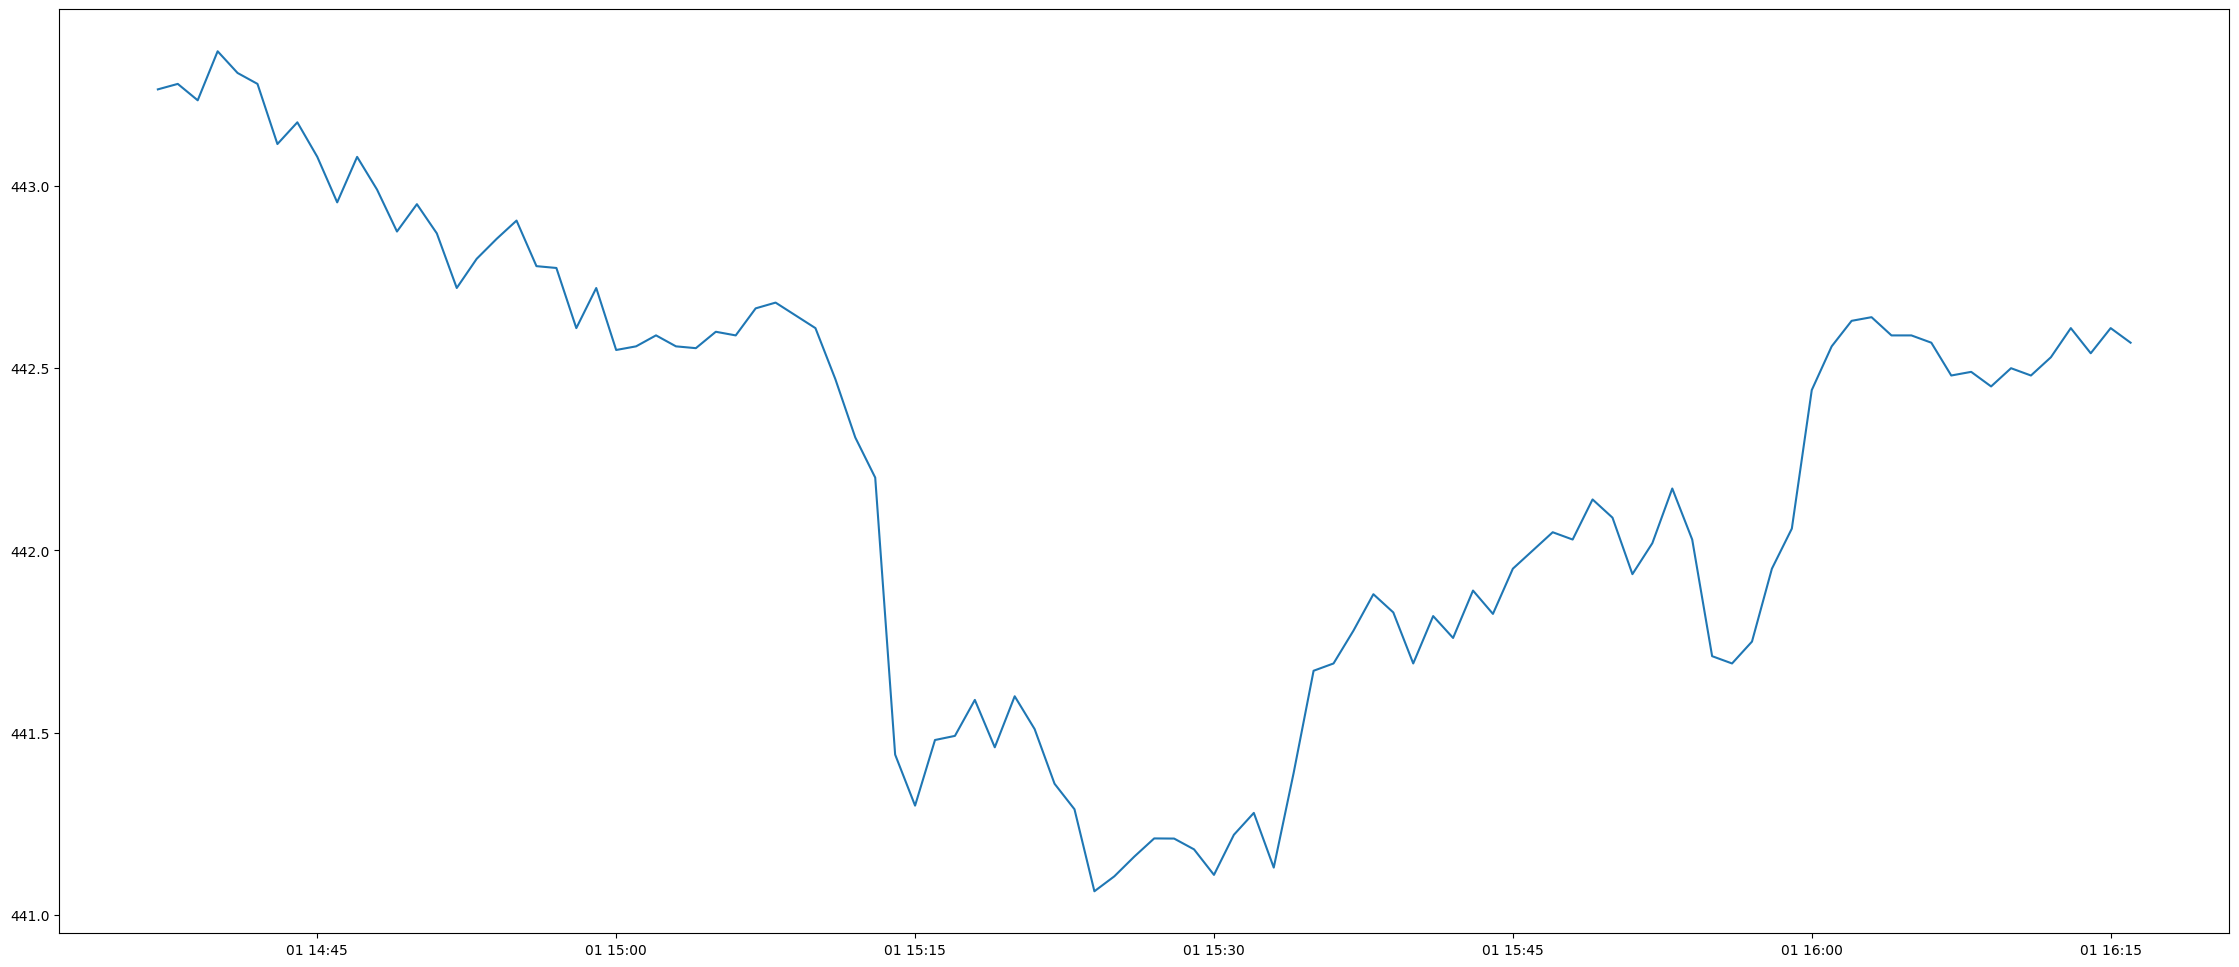

In [570]:
for date in label:
    if label[date]:
        print(date)
        plt.plot(res_df[res_df['date'] == date][-100:]['time'].apply(lambda x:datetime.datetime.strptime(x,"%H:%M:%S")), res_df[res_df['date'] == date][-100:]['c'].values)
        plt.show()
        time.sleep(1)
    

In [571]:
res_df.reset_index(drop=True,inplace=True)

In [572]:
res_df

v        vw       o        c       h        l              t  \
0      791583.0  405.7020  405.84  406.000  406.00  405.320  1704205800000   
1      210295.0  405.9334  406.00  405.960  406.09  405.760  1704205860000   
2      314941.0  405.8240  405.94  405.850  406.02  405.620  1704205920000   
3      649608.0  406.7315  405.82  405.480  405.82  405.317  1704205980000   
4      556240.0  406.8298  405.47  405.090  405.48  405.050  1704206040000   
...         ...       ...     ...      ...     ...      ...            ...   
26857    9028.0  440.2844  440.30  440.330  440.33  440.260  1712347920000   
26858    9230.0  440.3387  440.32  440.309  440.34  440.290  1712347980000   
26859    8768.0  440.2934  440.29  440.320  440.32  440.280  1712348040000   
26860    2543.0  440.3219  440.32  440.360  440.36  440.300  1712348100000   
26861    2405.0  440.3251  440.34  440.320  440.34  440.320  1712348160000   

          n             datetime        date      time  
0      9064  2024-01-02-09:30:00  2024-01-02  09:30:00  
1      2239  2024-01-02-09:31:00  2024-01-02  09:31:00  
2      3476  2024-01-02-09:32:00  2024-01-02  09:32:00  
3      4417  2024-01-02-09:33:00  2024-01-02  09:33:00  
4      3705  2024-01-02-09:34:00  2024-01-02  09:34:00  
...     ...                  ...         ...       ...  
26857    67  2024-04-05-16:12:00  2024-04-05  16:12:00  
26858    68  2024-04-05-16:13:00  2024-04-05  16:13:00  
26859    57  2024-04-05-16:14:00  2024-04-05  16:14:00  
26860    39  2024-04-05-16:15:00  2024-04-05  16:15:00  
26861    18  2024-04-05-16:16:00  2024-04-05  16:16:00  

[26862 rows x 11 columns]

### Feature Building

#### last X minute linear fitting

In [573]:
res_df['vw'].isnull()

0        False
1        False
2        False
3        False
4        False
         ...  
26857    False
26858    False
26859    False
26860    False
26861    False
Name: vw, Length: 26862, dtype: bool

In [73]:
def linear_regression_window(window, col_index):
    # Reset index to make 'TotalMinutes' relative within the window
    relative_time = window.index - window.index[0]
    
    X = relative_time.values.reshape(-1, 1)
    # Dependent variable: price
    y = window.values
   
    
    model = LinearRegression()
    model.fit(X, y)
    
    # Predict, calculate R-squared, and MSE
    y_pred = model.predict(X)
    r_squared = model.score(X, y)
    mse = np.mean((y - y_pred)**2)
    res = [model.coef_[0], model.intercept_, r_squared, mse]
    return res[col_index]

def get_res_df_by_date(inputs):
    res_df_date, window_size = inputs[0], inputs[1]
    cols=['Slope', 'Intercept', 'R-squared', 'MSE']
    for index in range(4):
        res_df_date[cols[index]+"_"+str(window_size)] = res_df_date[['vw']].rolling(window=window_size, min_periods=window_size).apply(
            lambda window: linear_regression_window(window,index),
        )
    return res_df_date

# Apply the function over a rolling window of X periods
# Note: Adjust '60' to the number of minutes you consider as one period


In [574]:
for window_size in tqdm(range(5,15)):
    res_df_date_list = []
    for date in res_df.date.unique():
        res_df_date_list.append((res_df[res_df['date'] == date], window_size))
    pool_size = multiprocessing.cpu_count()
    with multiprocessing.Pool(processes=pool_size) as pool:
        res_df_date_output_list = []
        for result in tqdm(pool.imap(get_res_df_by_date, res_df_date_list), total=len(res_df_date_list)):
            res_df_date_output_list.append(result)
        res_df = pd.concat(res_df_date_output_list)
        


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

In [575]:
res_df['date']

0        2024-01-02
1        2024-01-02
2        2024-01-02
3        2024-01-02
4        2024-01-02
            ...    
26857    2024-04-05
26858    2024-04-05
26859    2024-04-05
26860    2024-04-05
26861    2024-04-05
Name: date, Length: 26862, dtype: object

In [576]:
res_df_date['date']

55343    2024-04-05
55344    2024-04-05
55345    2024-04-05
55346    2024-04-05
55347    2024-04-05
55348    2024-04-05
55349    2024-04-05
55350    2024-04-05
55351    2024-04-05
55352    2024-04-05
55353    2024-04-05
55354    2024-04-05
55355    2024-04-05
55356    2024-04-05
55357    2024-04-05
55358    2024-04-05
55359    2024-04-05
55360    2024-04-05
55361    2024-04-05
55362    2024-04-05
55363    2024-04-05
55364    2024-04-05
55365    2024-04-05
55366    2024-04-05
55367    2024-04-05
55368    2024-04-05
55369    2024-04-05
55370    2024-04-05
55371    2024-04-05
55372    2024-04-05
55373    2024-04-05
55374    2024-04-05
55375    2024-04-05
55376    2024-04-05
55377    2024-04-05
55378    2024-04-05
55379    2024-04-05
55380    2024-04-05
55381    2024-04-05
55382    2024-04-05
55383    2024-04-05
55384    2024-04-05
55385    2024-04-05
55386    2024-04-05
55387    2024-04-05
55388    2024-04-05
55389    2024-04-05
55390    2024-04-05
55391    2024-04-05
55392    2024-04-05


In [86]:
res_df_date = res_df.groupby('date').apply(lambda x:x.iloc[0]).reset_index(drop=True)
res_df_date['next_trade_date'] = res_df_date['date'].shift(-1)
res_df_date.head(5)

v        vw       o       c       h       l              t     n  \
0  284694.0  184.7303  184.75  184.71  184.80  184.66  1554903000000   916   
1  335627.0  185.6752  185.77  185.57  185.78  185.51  1554989400000  1290   
2  386194.0  185.7754  185.86  185.72  185.87  185.67  1555075800000  1634   
3  204304.0  185.8898  185.81  185.91  185.96  185.81  1555335000000   859   
4  153246.0  186.4911  186.51  186.45  186.55  186.38  1555421400000   643   

              datetime        date  ... MSE_12  Slope_13  Intercept_13  \
0  2019-04-10-09:30:00  2019-04-10  ...    NaN       NaN           NaN   
1  2019-04-11-09:30:00  2019-04-11  ...    NaN       NaN           NaN   
2  2019-04-12-09:30:00  2019-04-12  ...    NaN       NaN           NaN   
3  2019-04-15-09:30:00  2019-04-15  ...    NaN       NaN           NaN   
4  2019-04-16-09:30:00  2019-04-16  ...    NaN       NaN           NaN   

   R-squared_13  MSE_13  Slope_14  Intercept_14  R-squared_14  MSE_14  \
0           NaN     NaN       NaN           NaN           NaN     NaN   
1           NaN     NaN       NaN           NaN           NaN     NaN   
2           NaN     NaN       NaN           NaN           NaN     NaN   
3           NaN     NaN       NaN           NaN           NaN     NaN   
4           NaN     NaN       NaN           NaN           NaN     NaN   

   next_trade_date  
0       2019-04-11  
1       2019-04-12  
2       2019-04-15  
3       2019-04-16  
4       2019-04-17  

[5 rows x 52 columns]

In [167]:
res_df = res_df.merge(res_df_date[['date','o']], on = 'date', how = 'left', suffixes=("","_open_for_the_date"))
res_df = res_df.merge(res_df_date[['next_trade_date','c']], left_on = 'date', right_on = 'next_trade_date', how = 'left', suffixes=("","_close_for_the_previous_date"))

### Label

In [194]:
def analyze_price_sequence(prices, upper=0.3, lower=0.1):
    # Function to calculate percentage change
    def pct_change(current, previous):
        return ((current - previous) / previous) * 100
    
    results = []
    n = len(prices)
    
    for i in range(n):
        base_price = prices[i]
        hit_upper = hit_lower = False
        
        # Iterate through the rest of the sequence from the current base price
        for j in range(i+1, n):
            change = pct_change(prices[j], base_price)
            
            if change >= upper:
                hit_upper = True
                break
            elif change <= -lower:
                hit_lower = True
                break
        
        # Determine the outcome
        if hit_upper:
            results.append(1)
        elif hit_lower:
            results.append(2)
        else:
            results.append(0)
    
    return results

# Example usage
prices = [100, 105, 95, 110, 90, 99]
print(analyze_price_sequence(prices))

[1, 2, 1, 2, 1, 0]


In [195]:
price = res_df[res_df['date'] == "2019-04-10"]['vw'].values
res = analyze_price_sequence(price)

(array([ 50.,   0.,  65.,   0., 291.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. ]),
 <BarContainer object of 5 artists>)

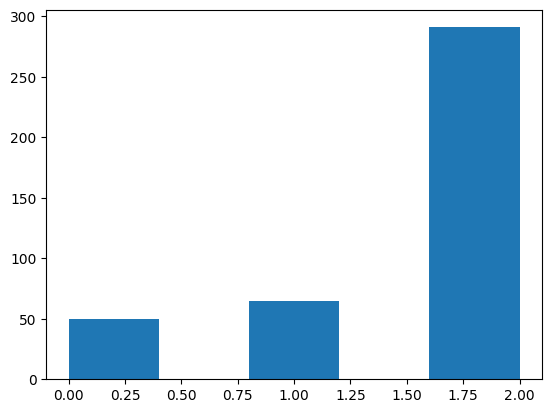

In [196]:
plt.hist(res, bins = 5)

In [197]:
def get_label_date_df(res_df_date):
    exit_res = analyze_price_sequence(res_df_date['c'].values, 0.3, 0.05)
    res_df_date['exit_status'] = exit_res
    return res_df_date

In [198]:
res_df_date_list = []
for date in res_df.date.unique():
    res_df_date_list.append(res_df[res_df['date'] == date])
pool_size = multiprocessing.cpu_count()
with multiprocessing.Pool(processes=pool_size) as pool:
    res_df_date_output_list = []
    for result in tqdm(pool.imap(get_label_date_df, res_df_date_list), total=len(res_df_date_list)):
        res_df_date_output_list.append(result)
    res_df = pd.concat(res_df_date_output_list)

  0%|          | 0/1235 [00:00<?, ?it/s]

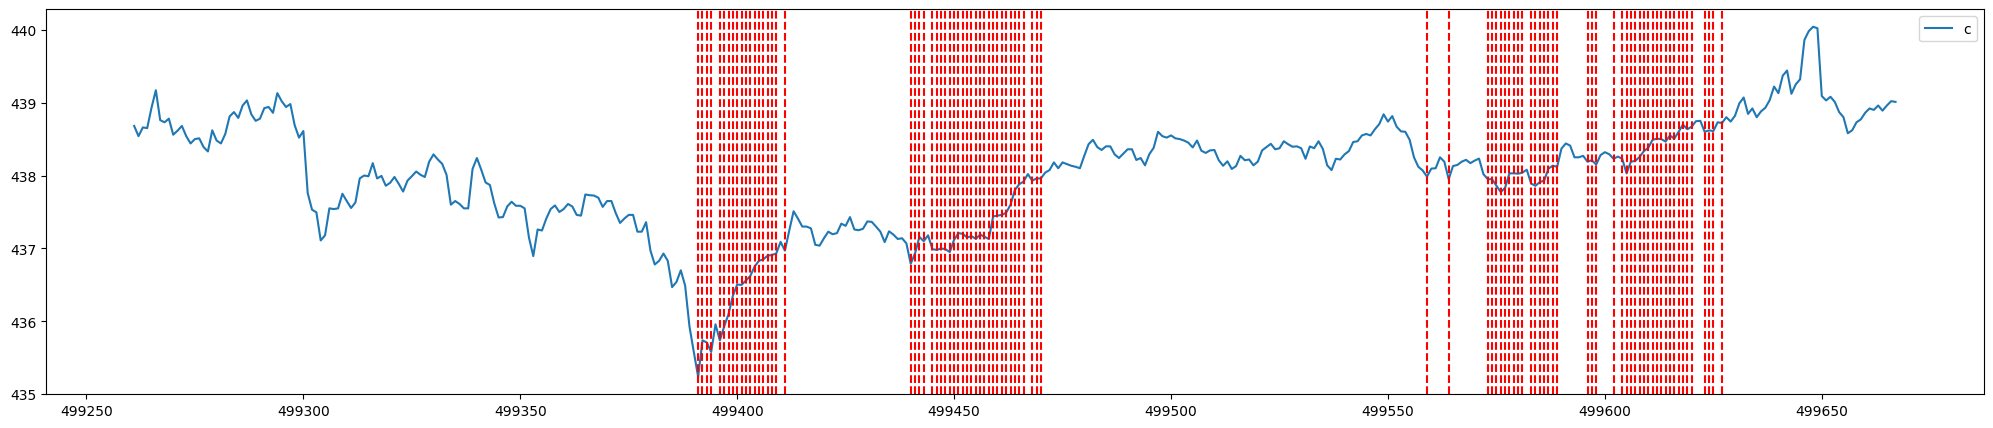

<Figure size 2500x500 with 0 Axes>

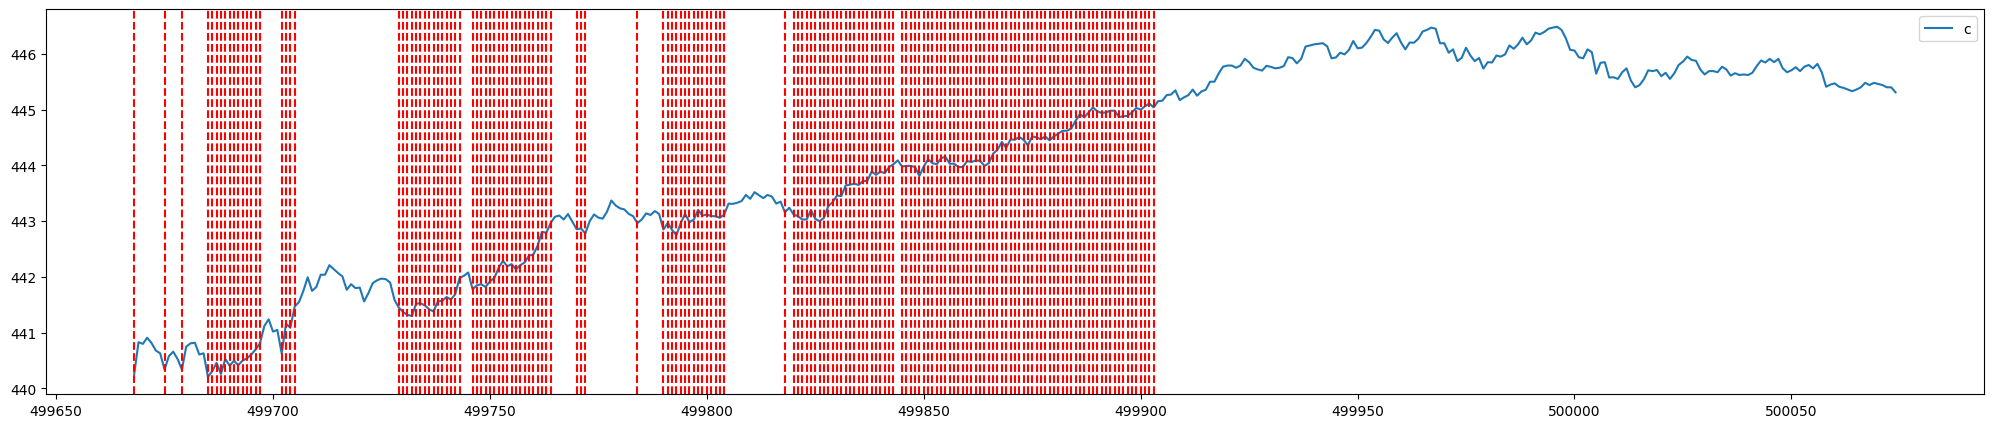

<Figure size 2500x500 with 0 Axes>

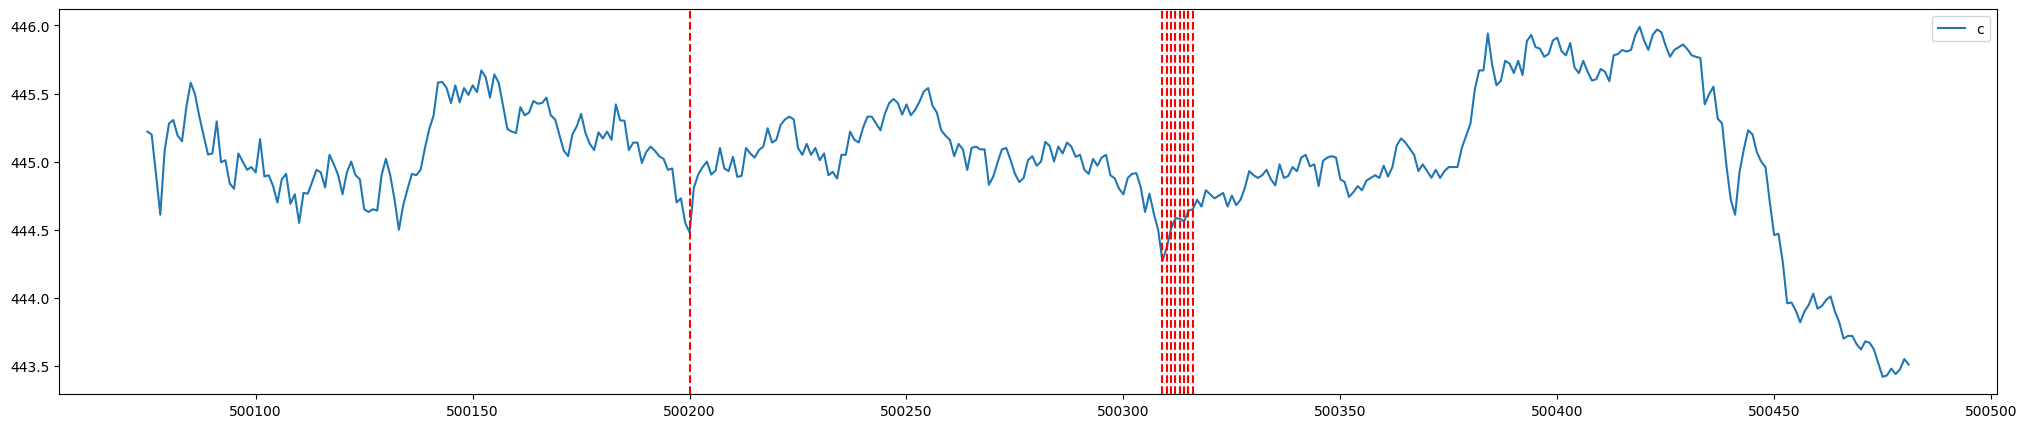

<Figure size 2500x500 with 0 Axes>

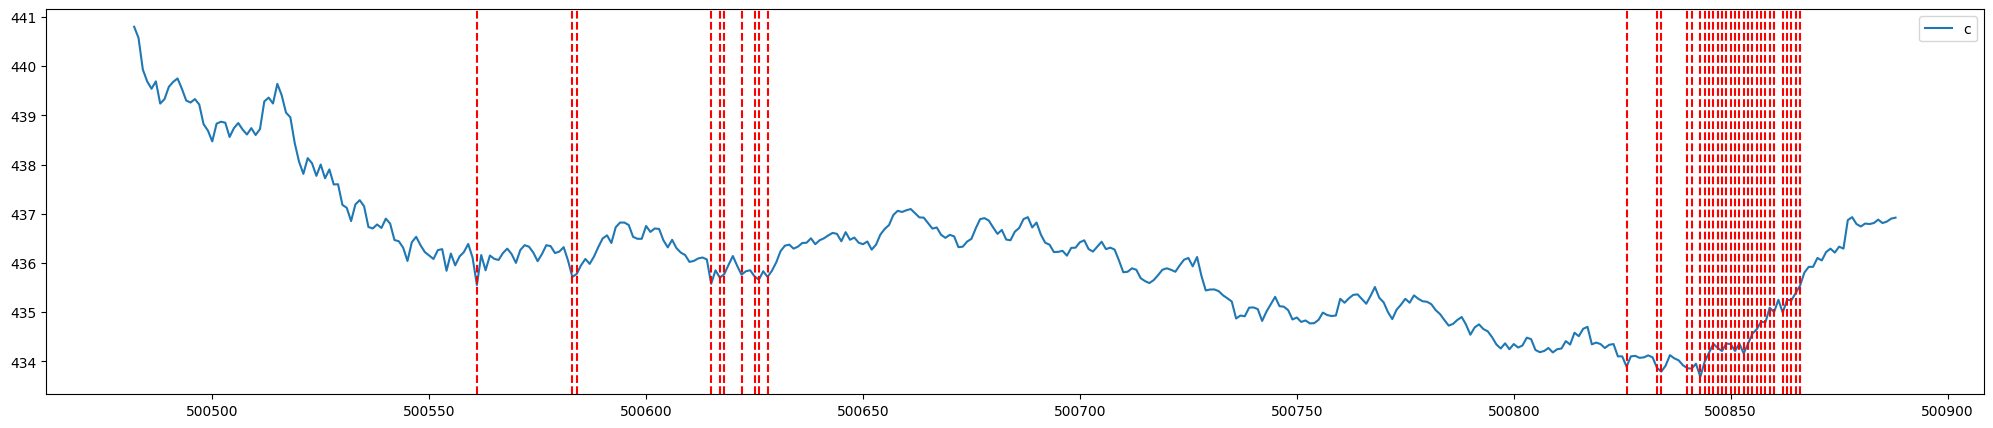

<Figure size 2500x500 with 0 Axes>

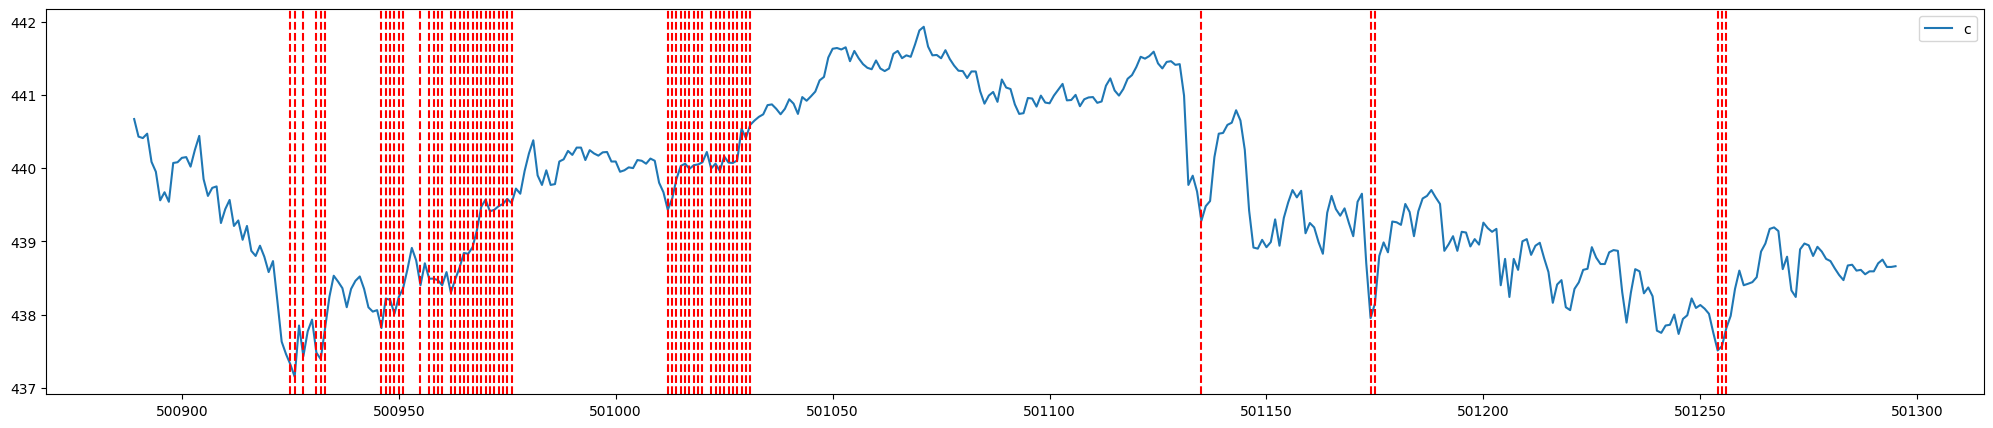

<Figure size 2500x500 with 0 Axes>

In [199]:
for date in res_df.date.unique()[-5:]:
    res_df_date_feature = res_df[res_df['date'] == date]
    plt.figure(figsize=(25, 5))
    for col in res_df_date_feature.columns:
        if col in ['c']:
            plt.plot(res_df_date_feature[col], label = col)
        if col in ['exit_status']:
            for pos in res_df_date_feature[res_df_date_feature[col] == 1].index.values:
                plt.axvline(x=pos, color='r', linestyle='--')
#         if 'c_MACD_cross_over_downward' in col:
#             for pos in res_df_date_feature[res_df_date_feature[col]].index.values:
#                 plt.axvline(x=pos, color='b', linestyle='--')
    plt.legend()
    plt.show()
    plt.figure(figsize=(25, 5))

In [512]:
res_df.dropna()

v        vw        o         c        h         l  \
419      70455.0  185.4431  185.420  185.5000  185.510  185.4001   
420      97568.0  185.4459  185.510  185.3821  185.520  185.3800   
421     108199.0  185.2621  185.390  185.1800  185.410  185.1600   
422      52870.0  185.2509  185.181  185.2700  185.290  185.1800   
423      60139.0  185.2645  185.270  185.3100  185.335  185.2200   
...          ...       ...      ...       ...      ...       ...   
501291   11071.0  438.6604  438.590  438.7000  438.710  438.5900   
501292    4908.0  438.7441  438.740  438.7500  438.760  438.7300   
501293   26782.0  438.6807  438.750  438.6500  438.760  438.6500   
501294    4512.0  438.6477  438.660  438.6500  438.660  438.6300   
501295    1696.0  438.6567  438.650  438.6600  438.660  438.6500   

                    t    n             datetime        date  ...  \
419     1554990180000  379  2019-04-11-09:43:00  2019-04-11  ...   
420     1554990240000  529  2019-04-11-09:44:00  2019-04-11  ...   
421     1554990300000  626  2019-04-11-09:45:00  2019-04-11  ...   
422     1554990360000  334  2019-04-11-09:46:00  2019-04-11  ...   
423     1554990420000  346  2019-04-11-09:47:00  2019-04-11  ...   
...               ...  ...                  ...         ...  ...   
501291  1709759520000   37  2024-03-06-16:12:00  2024-03-06  ...   
501292  1709759580000   53  2024-03-06-16:13:00  2024-03-06  ...   
501293  1709759640000   78  2024-03-06-16:14:00  2024-03-06  ...   
501294  1709759700000   53  2024-03-06-16:15:00  2024-03-06  ...   
501295  1709759760000   28  2024-03-06-16:16:00  2024-03-06  ...   

       o_open_for_the_date  next_trade_date_close_for_the_previous_date  \
419                 185.77                                   2019-04-11   
420                 185.77                                   2019-04-11   
421                 185.77                                   2019-04-11   
422                 185.77                                   2019-04-11   
423                 185.77                                   2019-04-11   
...                    ...                                          ...   
501291              440.32                                   2024-03-06   
501292              440.32                                   2024-03-06   
501293              440.32                                   2024-03-06   
501294              440.32                                   2024-03-06   
501295              440.32                                   2024-03-06   

        delta_from_today  next_trade_date_close_for_the_previous_date  \
419              -0.2700                                   2019-04-11   
420              -0.3879                                   2019-04-11   
421              -0.5900                                   2019-04-11   
422              -0.5000                                   2019-04-11   
423              -0.4600                                   2019-04-11   
...                  ...                                          ...   
501291           -1.6200                                   2024-03-06   
501292           -1.5700                                   2024-03-06   
501293           -1.6700                                   2024-03-06   
501294           -1.6700                                   2024-03-06   
501295           -1.6600                                   2024-03-06   

        c_close_for_the_previous_date  delta_from_yesterday  \
419                            184.71                0.7900   
420                            184.71                0.6721   
421                            184.71                0.4700   
422                            184.71                0.5600   
423                            184.71                0.6000   
...                               ...                   ...   
501291                         440.80               -2.1000   
501292                         440.80               -2.0500   
501293                         440.8

In [509]:
res_df['delta_from_today'] = res_df['c'] - res_df['o_open_for_the_date'].fillna(0)
res_df['delta_from_yesterday'] = res_df['c'] - res_df['c_close_for_the_previous_date'].fillna(0)

res_df['delta_ret_from_today'] = (res_df['c'] - res_df['o_open_for_the_date'].fillna(0))/res_df['o_open_for_the_date'].fillna(0)
res_df['delta_ret_from_yesterday'] = (res_df['c'] - res_df['c_close_for_the_previous_date'].fillna(1)) / res_df['c_close_for_the_previous_date'].fillna(1)

res_df['delta_from_night'] = res_df['o_open_for_the_date'].fillna(0) - res_df['c_close_for_the_previous_date'].fillna(0)
res_df['delta_ret_from_night'] = (res_df['o_open_for_the_date'].fillna(0) - res_df['c_close_for_the_previous_date'].fillna(0))/res_df['c_close_for_the_previous_date'].fillna(0)



In [422]:
res_df_cleaned = res_df.dropna()
res_df_cleaned

v        vw        o         c        h         l  \
419      70455.0  185.4431  185.420  185.5000  185.510  185.4001   
420      97568.0  185.4459  185.510  185.3821  185.520  185.3800   
421     108199.0  185.2621  185.390  185.1800  185.410  185.1600   
422      52870.0  185.2509  185.181  185.2700  185.290  185.1800   
423      60139.0  185.2645  185.270  185.3100  185.335  185.2200   
...          ...       ...      ...       ...      ...       ...   
501291   11071.0  438.6604  438.590  438.7000  438.710  438.5900   
501292    4908.0  438.7441  438.740  438.7500  438.760  438.7300   
501293   26782.0  438.6807  438.750  438.6500  438.760  438.6500   
501294    4512.0  438.6477  438.660  438.6500  438.660  438.6300   
501295    1696.0  438.6567  438.650  438.6600  438.660  438.6500   

                    t    n             datetime        date  ...  \
419     1554990180000  379  2019-04-11-09:43:00  2019-04-11  ...   
420     1554990240000  529  2019-04-11-09:44:00  2019-04-11  ...   
421     1554990300000  626  2019-04-11-09:45:00  2019-04-11  ...   
422     1554990360000  334  2019-04-11-09:46:00  2019-04-11  ...   
423     1554990420000  346  2019-04-11-09:47:00  2019-04-11  ...   
...               ...  ...                  ...         ...  ...   
501291  1709759520000   37  2024-03-06-16:12:00  2024-03-06  ...   
501292  1709759580000   53  2024-03-06-16:13:00  2024-03-06  ...   
501293  1709759640000   78  2024-03-06-16:14:00  2024-03-06  ...   
501294  1709759700000   53  2024-03-06-16:15:00  2024-03-06  ...   
501295  1709759760000   28  2024-03-06-16:16:00  2024-03-06  ...   

       o_open_for_the_date  next_trade_date_close_for_the_previous_date  \
419                 185.77                                   2019-04-11   
420                 185.77                                   2019-04-11   
421                 185.77                                   2019-04-11   
422                 185.77                                   2019-04-11   
423                 185.77                                   2019-04-11   
...                    ...                                          ...   
501291              440.32                                   2024-03-06   
501292              440.32                                   2024-03-06   
501293              440.32                                   2024-03-06   
501294              440.32                                   2024-03-06   
501295              440.32                                   2024-03-06   

        delta_from_today  next_trade_date_close_for_the_previous_date  \
419              -0.2700                                   2019-04-11   
420              -0.3879                                   2019-04-11   
421              -0.5900                                   2019-04-11   
422              -0.5000                                   2019-04-11   
423              -0.4600                                   2019-04-11   
...                  ...                                          ...   
501291           -1.6200                                   2024-03-06   
501292           -1.5700                                   2024-03-06   
501293           -1.6700                                   2024-03-06   
501294           -1.6700                                   2024-03-06   
501295           -1.6600                                   2024-03-06   

        c_close_for_the_previous_date  delta_from_yesterday  \
419                            184.71                0.7900   
420                            184.71                0.6721   
421                            184.71                0.4700   
422                            184.71                0.5600   
423                            184.71                0.6000   
...                               ...                   ...   
501291                         440.80               -2.1000   
501292                         440.80               -2.0500   
501293                         440.8

In [423]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import balanced_accuracy_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils.class_weight import compute_sample_weight

In [424]:
res_df_cleaned.reset_index(inplace=True, drop=True)

In [425]:
res_df_cleaned_tail_everyday = pd.concat([res_df_cleaned[res_df_cleaned['date'] == date][-60:-30] for date in res_df_cleaned.date.unique()])
res_df_cleaned_tail_everyday.reset_index(drop=True, inplace=True)

<Axes: >

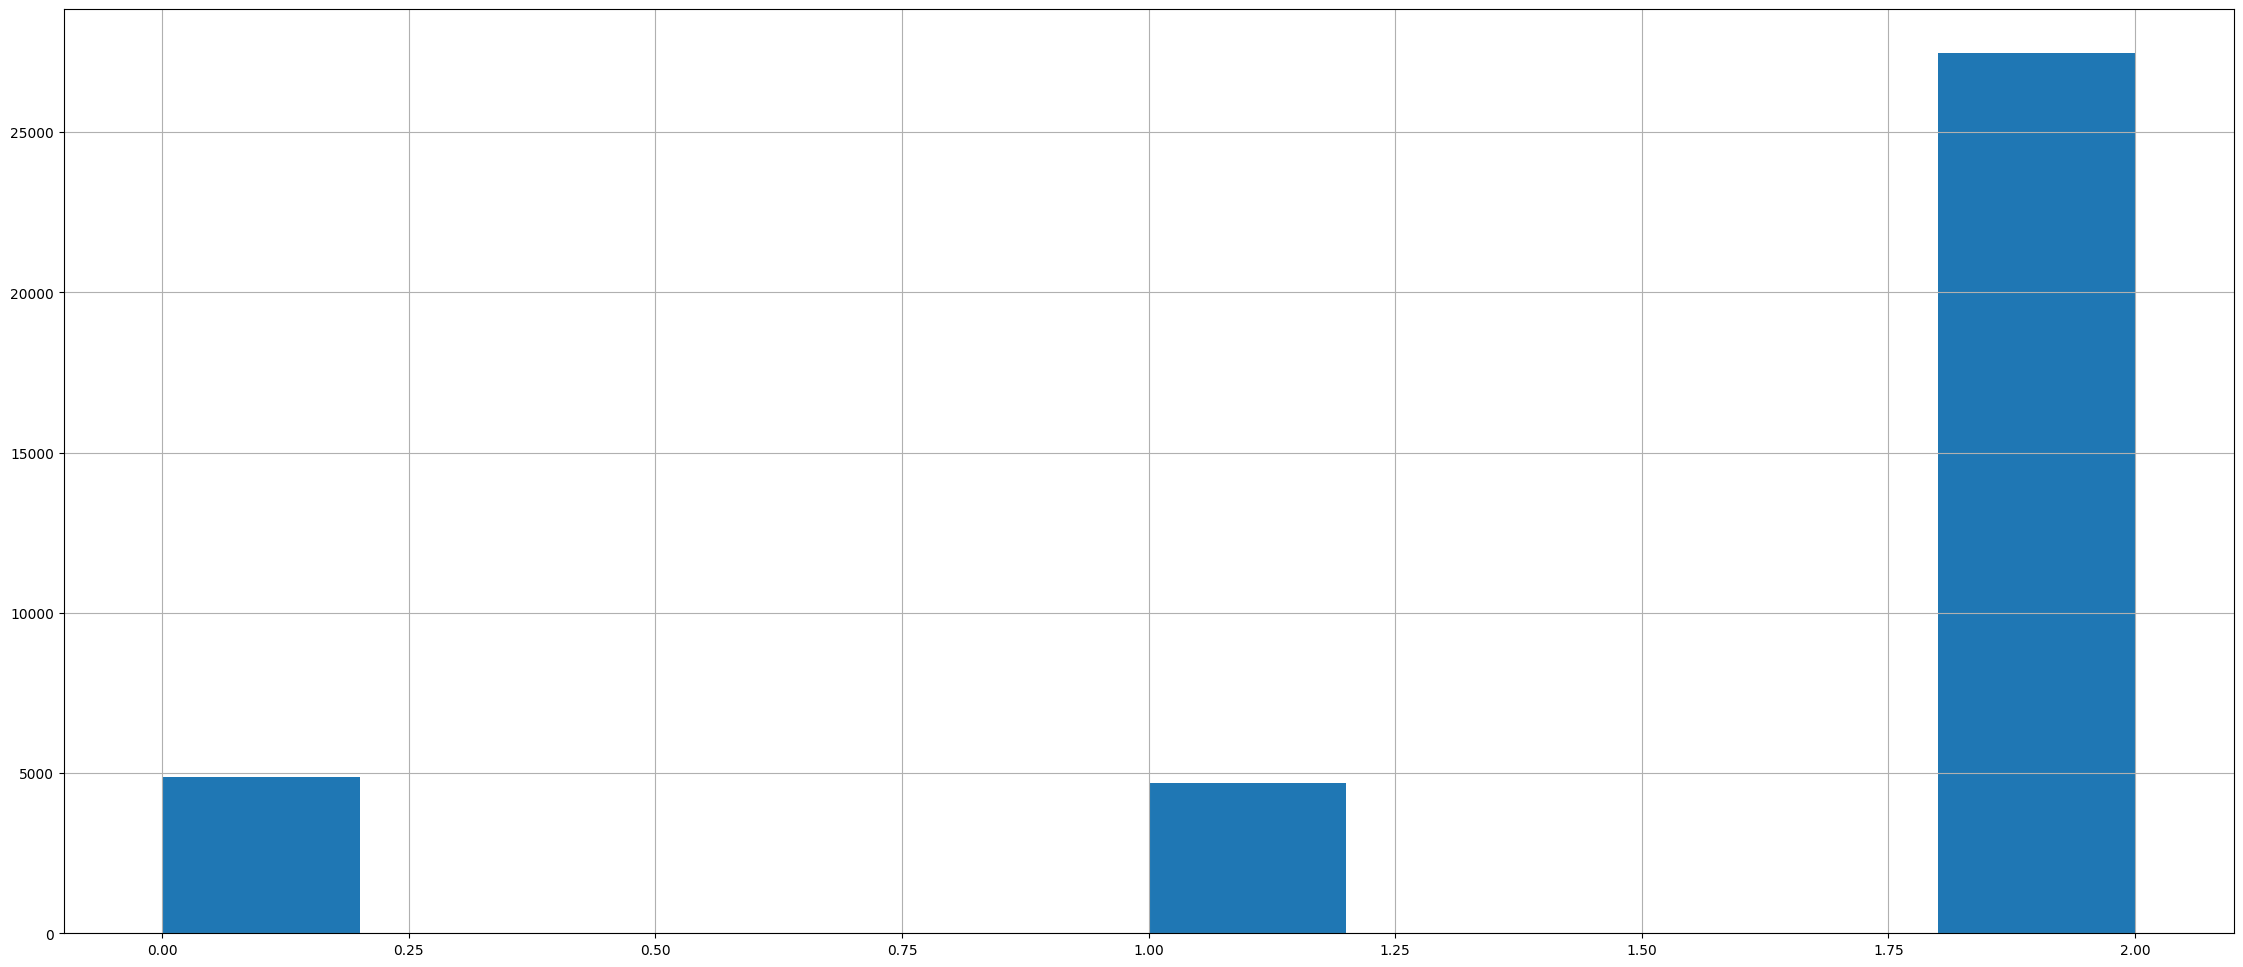

In [437]:
X_train = res_df_cleaned_tail_everyday[-1500:-300].drop(['t','exit_status','date','datetime','time','next_trade_date_close_for_the_previous_date','next_trade_date'],axis = 1).values
y_train = res_df_cleaned_tail_everyday[-1500:-300]['exit_status'].values
X_test = res_df_cleaned_tail_everyday[-30*10:].drop(['t','exit_status','date','datetime','time','next_trade_date_close_for_the_previous_date','next_trade_date'],axis = 1).values
y_test = res_df_cleaned_tail_everyday[-30*10:]['exit_status'].values

<Axes: >

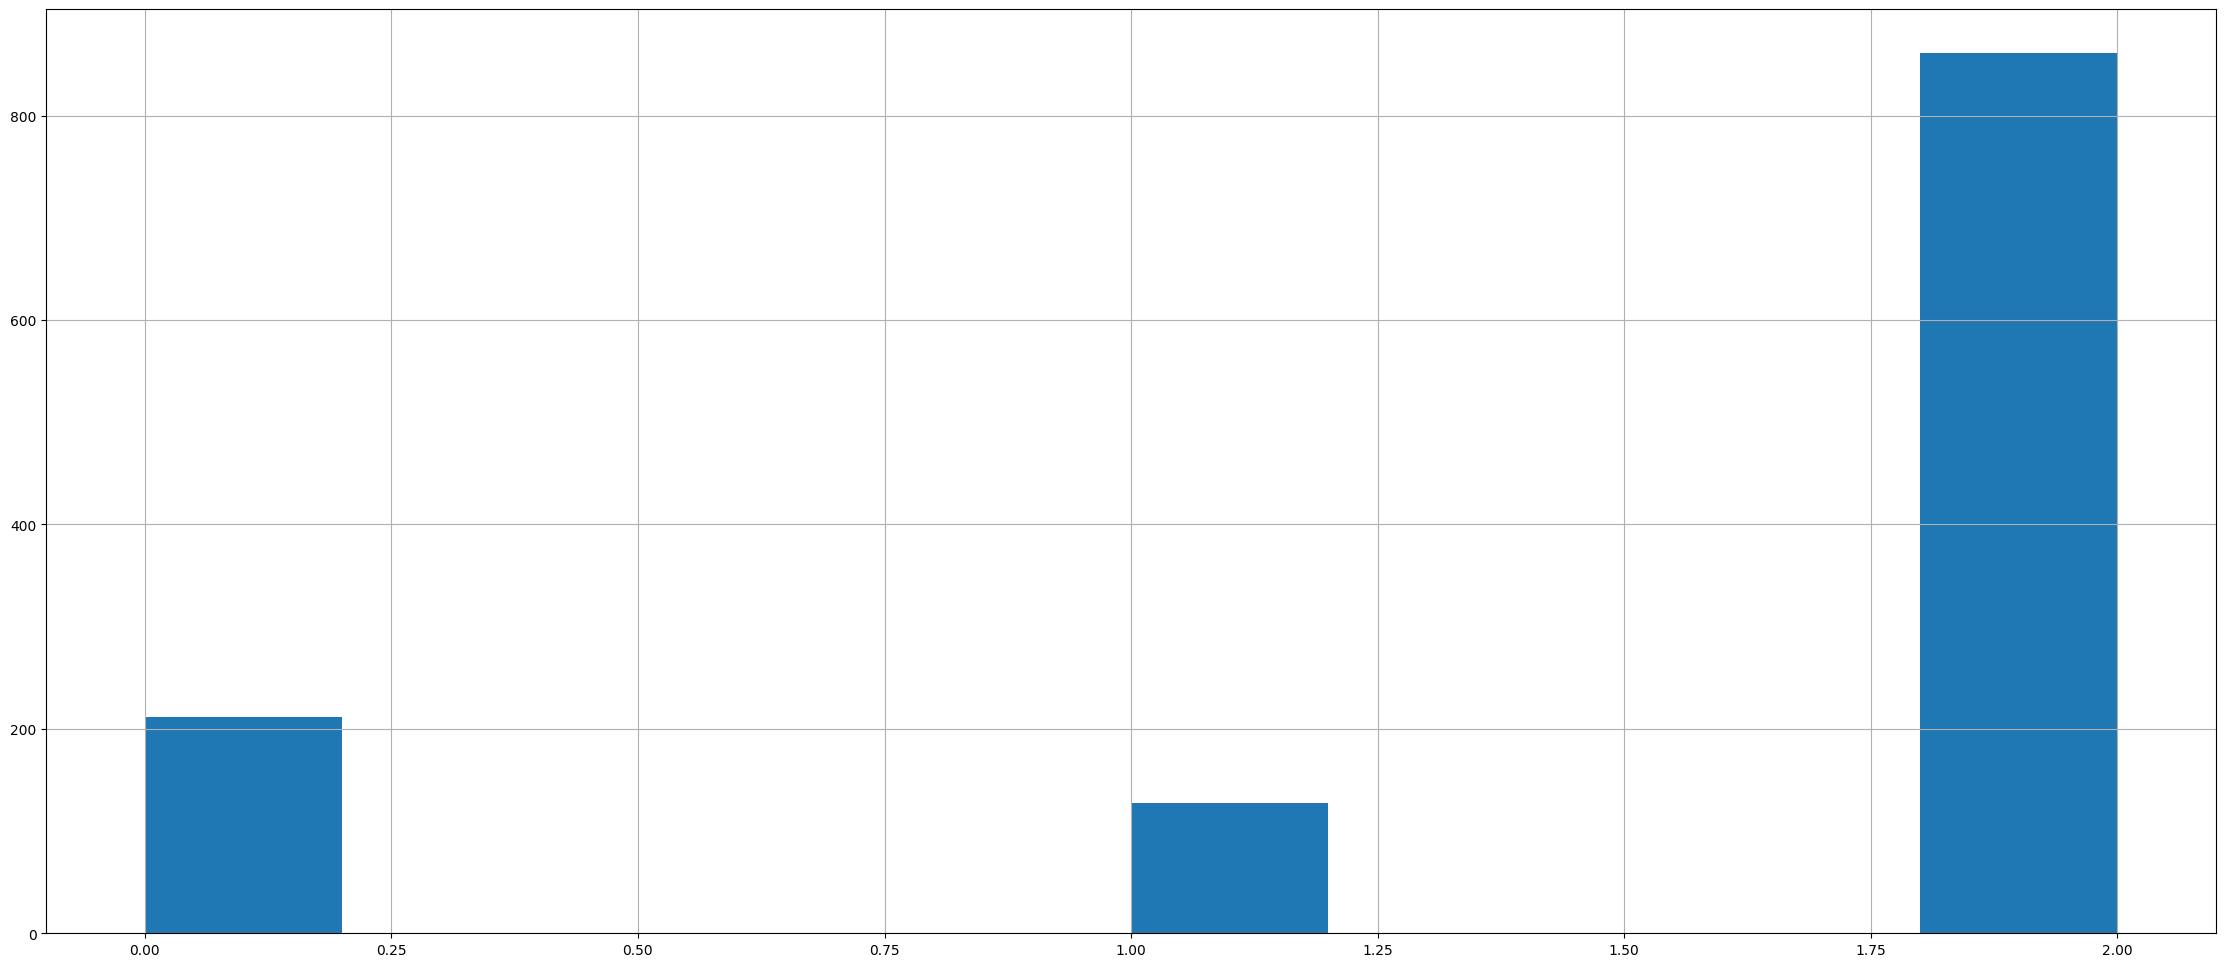

In [438]:
res_df_cleaned_tail_everyday[-1500:-300]['exit_status'].hist()

In [460]:
from xgboost import XGBClassifier

# Create an instance of the XGBClassifier
model = XGBClassifier(objective='multi:softmax', 
                            num_class=3, 
                            gamma=0, # default gamma value
                            learning_rate=0.01,
                            max_depth=2,
                            reg_lambda=2, # default L2 value
                            subsample=0.8, # default subsample value
                            colsample_bytree=0.9, # default colsample_bytree value
                            early_stopping_rounds=20,
                            eval_metric=['auc'],
                            seed=42, n_estimators  = 500)

In [461]:
model.fit(X_train, 
            y_train,
            verbose=1, # set to 1 to see xgb training round intermediate results
            eval_set=[(X_train, y_train), (X_test, y_test)], )

[0]	validation_0-auc:0.80766	validation_1-auc:0.68203
[1]	validation_0-auc:0.81516	validation_1-auc:0.69836
[2]	validation_0-auc:0.85770	validation_1-auc:0.64852
[3]	validation_0-auc:0.85652	validation_1-auc:0.61615
[4]	validation_0-auc:0.86246	validation_1-auc:0.59881
[5]	validation_0-auc:0.85921	validation_1-auc:0.58313
[6]	validation_0-auc:0.86064	validation_1-auc:0.57694
[7]	validation_0-auc:0.86684	validation_1-auc:0.55153
[8]	validation_0-auc:0.86708	validation_1-auc:0.57994
[9]	validation_0-auc:0.86615	validation_1-auc:0.56164
[10]	validation_0-auc:0.86291	validation_1-auc:0.55563
[11]	validation_0-auc:0.86173	validation_1-auc:0.56186
[12]	validation_0-auc:0.85932	validation_1-auc:0.55734
[13]	validation_0-auc:0.85910	validation_1-auc:0.55824
[14]	validation_0-auc:0.86093	validation_1-auc:0.55543
[15]	validation_0-auc:0.86273	validation_1-auc:0.55638
[16]	validation_0-auc:0.86316	validation_1-auc:0.56035
[17]	validation_0-auc:0.86385	validation_1-auc:0.55769
[18]	validation_0-au

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=20,
              enable_categorical=False, eval_metric=['auc'], feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None, num_class=3,
              num_parallel_tree=None, ...)

In [462]:

y_pred = model.predict(X_test)
print('\n------------------ Confusion Matrix -----------------\n')
print(confusion_matrix(y_test, y_pred))


------------------ Confusion Matrix -----------------

[[  0   0  30]
 [  0  18  22]
 [  0  10 220]]


In [415]:
y_true = res_df_cleaned_tail_everyday[-300:]['exit_status'].values

In [416]:
from matplotlib import pyplot

In [419]:
res_df_cleaned_tail_everyday[-2100:-300].drop(['t','exit_status','date','datetime','time','next_trade_date_close_for_the_previous_date','next_trade_date'],axis = 1).columns.values

array(['v', 'vw', 'o', 'c', 'h', 'l', 'n', 'Slope_5', 'Intercept_5',
       'R-squared_5', 'MSE_5', 'Slope_6', 'Intercept_6', 'R-squared_6',
       'MSE_6', 'Slope_7', 'Intercept_7', 'R-squared_7', 'MSE_7',
       'Slope_8', 'Intercept_8', 'R-squared_8', 'MSE_8', 'Slope_9',
       'Intercept_9', 'R-squared_9', 'MSE_9', 'Slope_10', 'Intercept_10',
       'R-squared_10', 'MSE_10', 'Slope_11', 'Intercept_11',
       'R-squared_11', 'MSE_11', 'Slope_12', 'Intercept_12',
       'R-squared_12', 'MSE_12', 'Slope_13', 'Intercept_13',
       'R-squared_13', 'MSE_13', 'Slope_14', 'Intercept_14',
       'R-squared_14', 'MSE_14', 'o_open_for_the_previous_date',
       'o_open_for_the_date', 'delta_from_today',
       'c_close_for_the_previous_date', 'delta_from_yesterday',
       'delta_ret_from_today', 'delta_ret_from_yesterday'], dtype=object)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

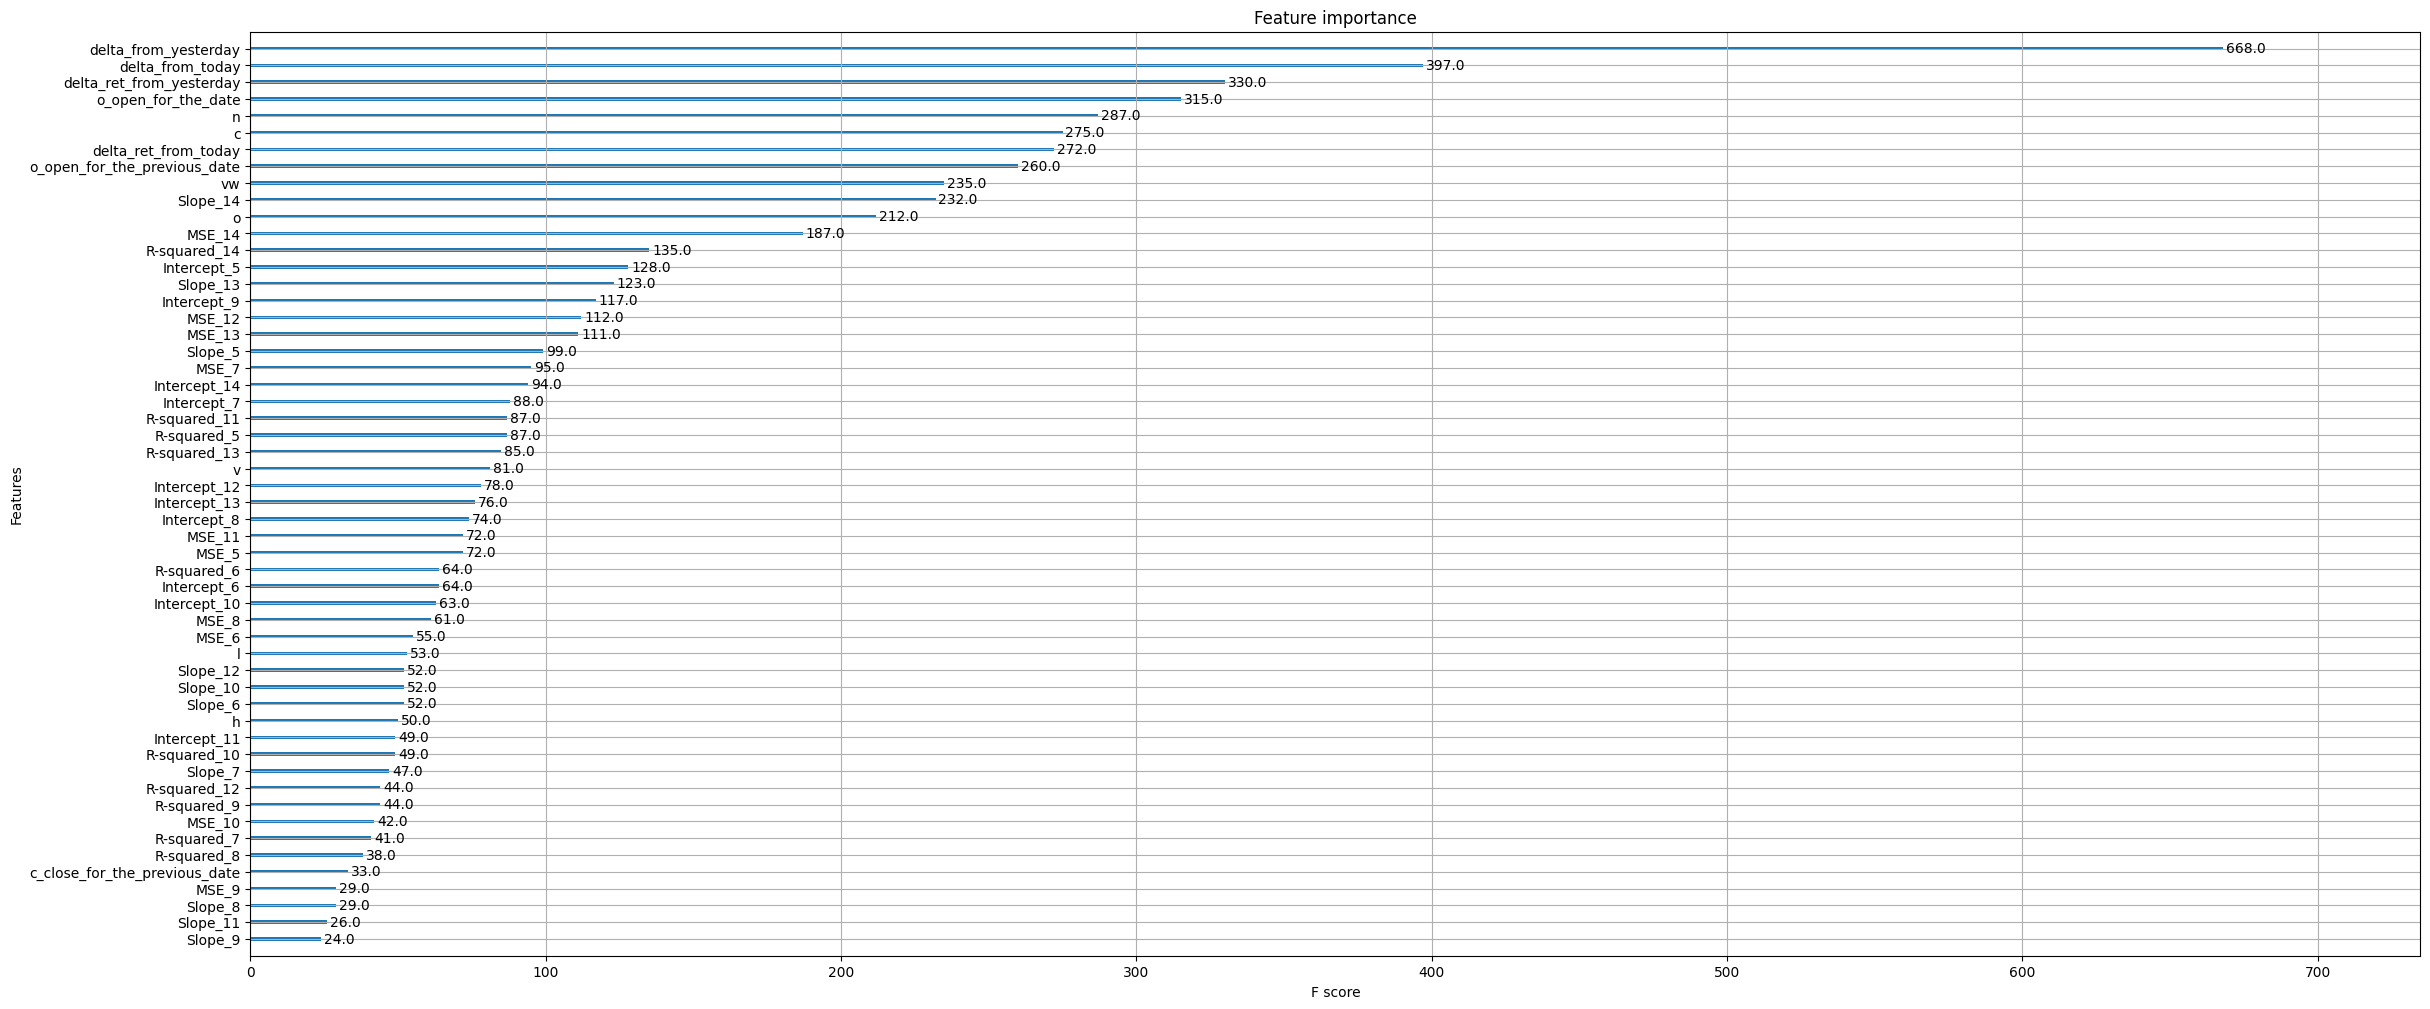

In [420]:
model.get_booster().feature_names = list(res_df_cleaned_tail_everyday[-2100:-300].drop(['t','exit_status','date','datetime','time','next_trade_date_close_for_the_previous_date','next_trade_date'],axis = 1).columns.values)
xgb.plot_importance(model.get_booster())

#### Baseline

In [21]:
pd.options.display.max_rows = 500

In [22]:
res_df_date_feature.columns

NameError: name 'res_df_date_feature' is not defined

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
res_df

In [420]:
def calculate_return_with_MACD(res_df):
    profit = []
    ret = []
    long = False
    for index in res_df.index:
        if res_df.loc[index]['vw_MACD_cross_over_upward'] and (index + 1) in res_df.index:
            buy_price = res_df.loc[index + 1]['vw']
            long = True
        if res_df.loc[index]['vw_MACD_cross_over_downward'] and long and (index + 1) in res_df.index:
            long = False
            sell_price = res_df.loc[index + 1]['vw']
            profit.append(sell_price - buy_price)
            ret.append((sell_price - buy_price)*1.0 / buy_price)
        if index == len(res_df)-1 and long:
            long = False
            sell_price = res_df.loc[index + 1]['vw']
            profit.append(sell_price - buy_price)
            ret.append((sell_price - buy_price)*1.0 / buy_price)
    return profit, ret

In [646]:
def convert_dollar_to_int(dollar_str):
    # Remove the dollar sign and commas
    clean_str = dollar_str.replace('$', '').replace(',', '')
    # Convert to integer
    return int(clean_str)

In [572]:
def flatten_df(res_df_date_feature,col_to_remove):
    res_df_date_feature_mini = res_df_date_feature[res_df_date_feature.apply(lambda x: datetime.datetime.strptime(x['time'], "%H:%M:%S") >= datetime.datetime.strptime("14:30:00", "%H:%M:%S"),axis = 1)]
    res_df_date_feature_drop = res_df_date_feature_mini.drop(["datetime",'date','t']+col_to_remove,axis = 1)
    res_df_date_feature_drop.set_index("time",inplace=True, drop=True)
    new_line = {}
    valid_col = []
    for index in res_df_date_feature_drop.index.values:
        for col in res_df_date_feature_drop.columns:
            new_line["{}_{}".format(str(index), str(col))] =res_df_date_feature_drop.loc[index][col]
    return new_line
#     res_df_date_feature[-60:].flatten()

In [647]:
convert_dollar_to_int(earnings.loc["MU"]['marketCap'])

103524574766

  0%|          | 0/1251 [00:00<?, ?it/s]

v        vw       o         c       h       l              t  \
167  264223.0  179.1927  179.16  179.2900  179.29  179.15  1553002200000   
168  120562.0  179.3822  179.30  179.4001  179.43  179.28  1553002260000   
169   71381.0  179.4304  179.40  179.4600  179.47  179.38  1553002320000   
170   98090.0  179.3972  179.46  179.3600  179.46  179.34  1553002380000   
171   72610.0  179.3086  179.37  179.3100  179.37  179.27  1553002440000   

        n             datetime        date  ... vw_ma_12   vw_ema_12  \
167  1020  2019-03-19-09:30:00  2019-03-19  ...      NaN  179.192700   
168   851  2019-03-19-09:31:00  2019-03-19  ...      NaN  179.221854   
169   473  2019-03-19-09:32:00  2019-03-19  ...      NaN  179.253938   
170   492  2019-03-19-09:33:00  2019-03-19  ...      NaN  179.275978   
171   389  2019-03-19-09:34:00  2019-03-19  ...      NaN  179.280997   

     vw_ma_26   vw_ema_26   vw_MACD  vw_Signal_Line  vw_MACD_Signal_Line_dif  \
167       NaN  179.192700  0.000000        0.000000                 0.000000   
168       NaN  179.206737  0.015117        0.003023                 0.012093   
169       NaN  179.223305  0.030633        0.008545                 0.022088   
170       NaN  179.236186  0.039792        0.014795                 0.024998   
171       NaN  179.241550  0.039447        0.019725                 0.019722   

     vw_MACD_Signal_Line_dif_shift1  vw_MACD_cross_over_upward  \
167                             NaN                      False   
168                        0.000000                      False   
169                        0.012093                      False   
170                        0.022088                      False   
171                        0.024998                      False   

     vw_MACD_cross_over_downward  
167                        False  
168                        False  
169                        False  
170                        False  
171                        False  

[5 rows x 31 columns]

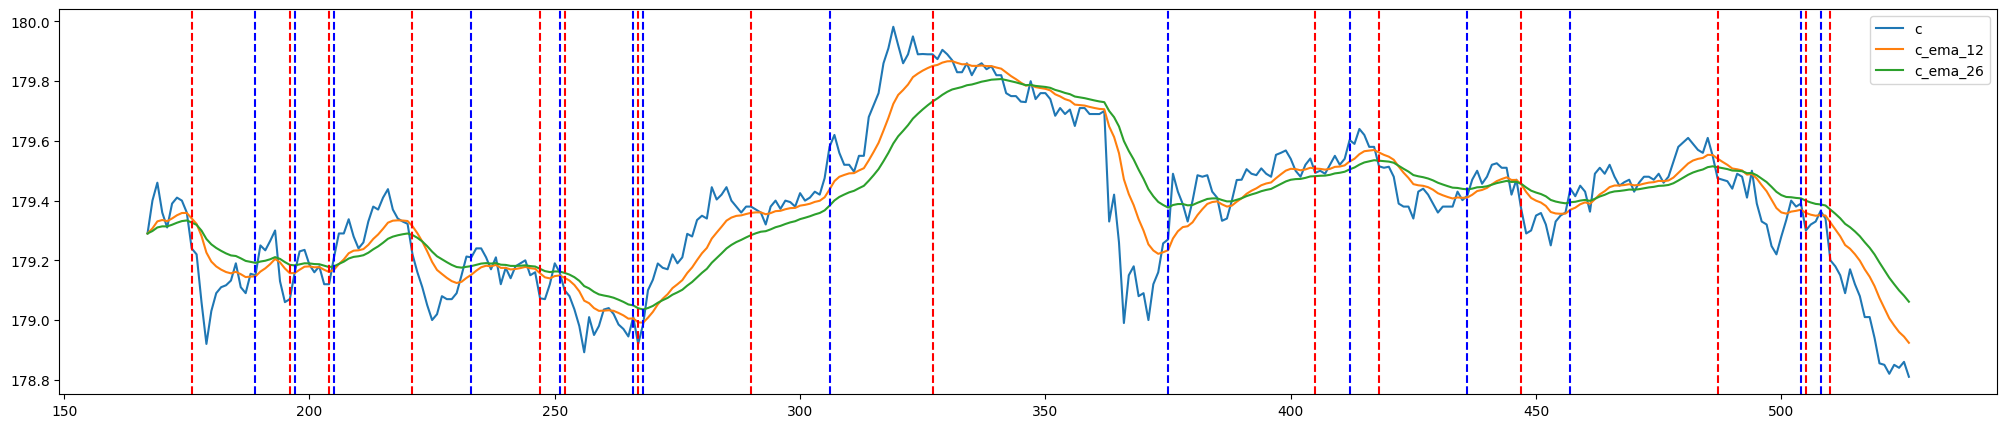

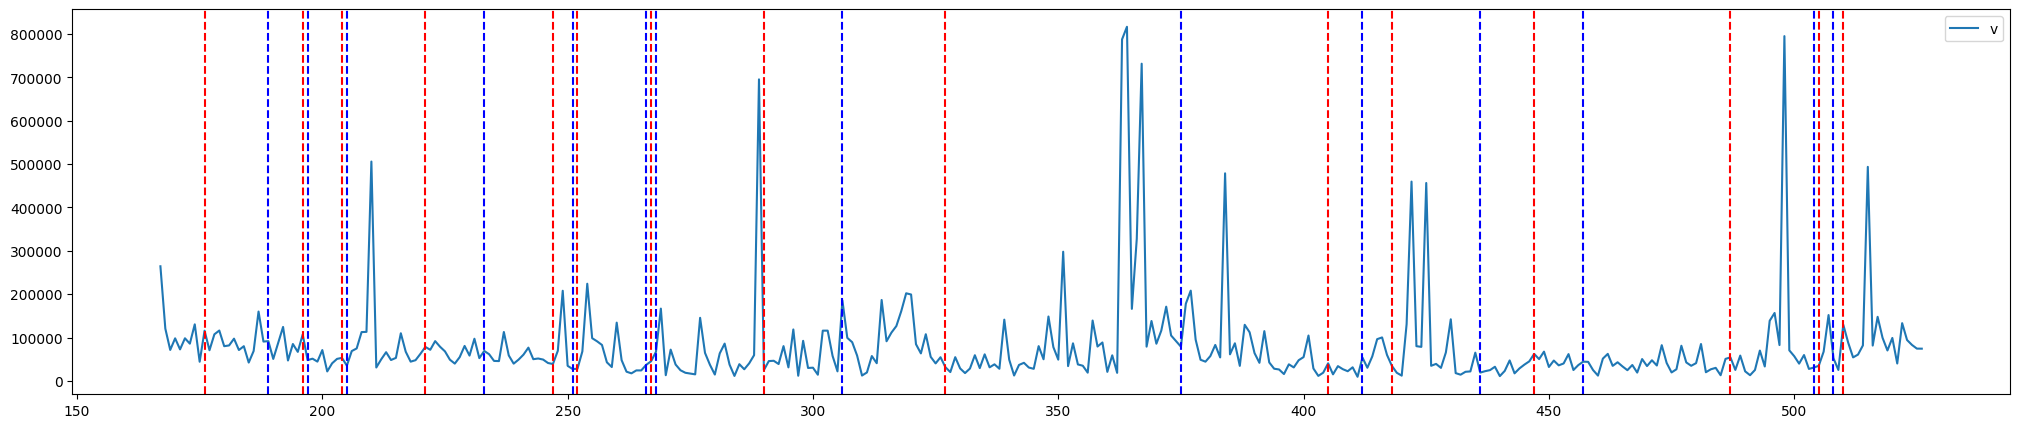

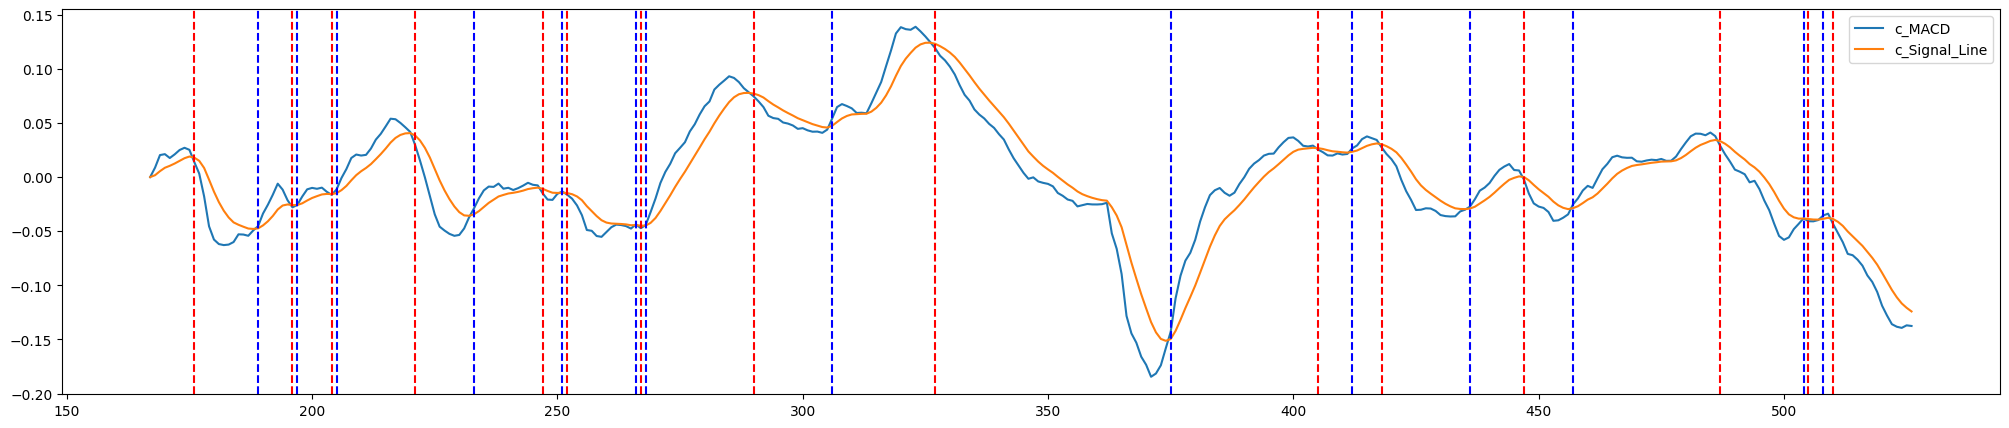

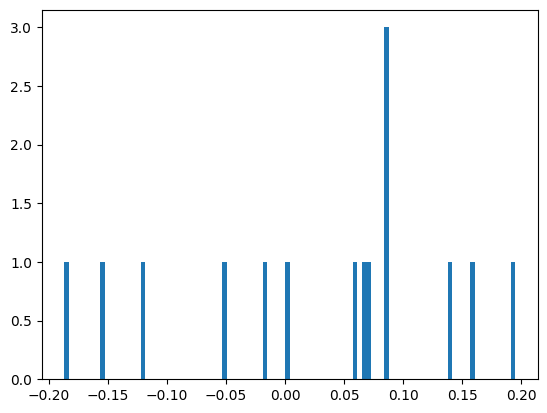

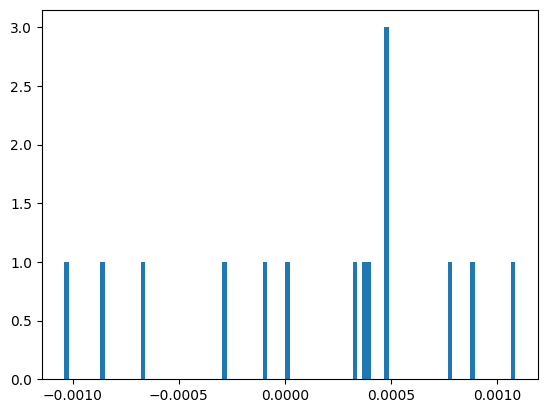

v        vw       o       c         h       l              t  \
858  385407.0  178.9375  179.06  178.87  179.1100  178.76  1553088600000   
859  137439.0  178.9447  178.87  178.96  178.9901  178.86  1553088660000   
860   96049.0  178.9758  178.97  178.97  179.0100  178.93  1553088720000   
861   97507.0  178.9328  178.97  178.83  179.0100  178.81  1553088780000   
862  187172.0  178.8423  178.82  178.86  178.8999  178.77  1553088840000   

        n             datetime        date  ... vw_ma_12   vw_ema_12  \
858  1809  2019-03-20-09:30:00  2019-03-20  ...      NaN  178.937500   
859   899  2019-03-20-09:31:00  2019-03-20  ...      NaN  178.938608   
860   718  2019-03-20-09:32:00  2019-03-20  ...      NaN  178.944330   
861   525  2019-03-20-09:33:00  2019-03-20  ...      NaN  178.942556   
862   706  2019-03-20-09:34:00  2019-03-20  ...      NaN  178.927132   

     vw_ma_26   vw_ema_26   vw_MACD  vw_Signal_Line  vw_MACD_Signal_Line_dif  \
858       NaN  178.937500  0.000000        0.000000                 0.000000   
859       NaN  178.938033  0.000574        0.000115                 0.000459   
860       NaN  178.940831  0.003499        0.000792                 0.002707   
861       NaN  178.940236  0.002320        0.001097                 0.001223   
862       NaN  178.932981 -0.005850       -0.000292                -0.005558   

     vw_MACD_Signal_Line_dif_shift1  vw_MACD_cross_over_upward  \
858                             NaN                      False   
859                        0.000000                      False   
860                        0.000459                      False   
861                        0.002707                      False   
862                        0.001223                       True   

     vw_MACD_cross_over_downward  
858                        False  
859                        False  
860                        False  
861                        False  
862                        False  

[5 rows x 31 columns]

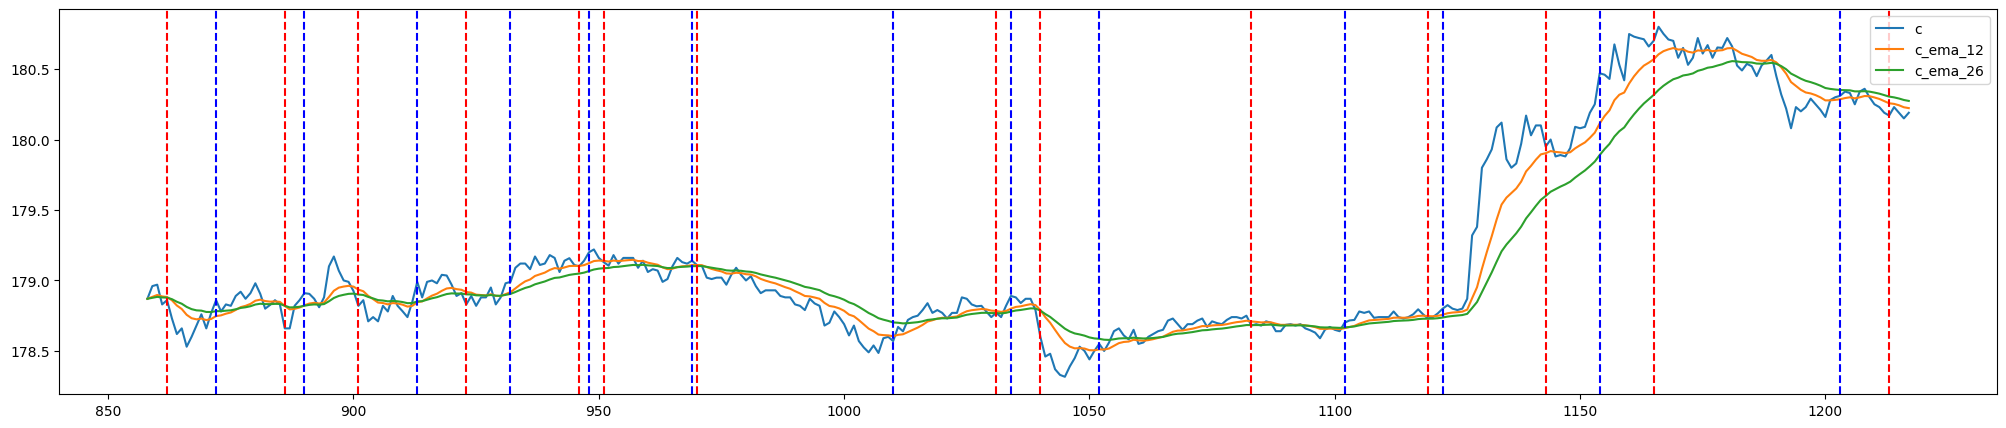

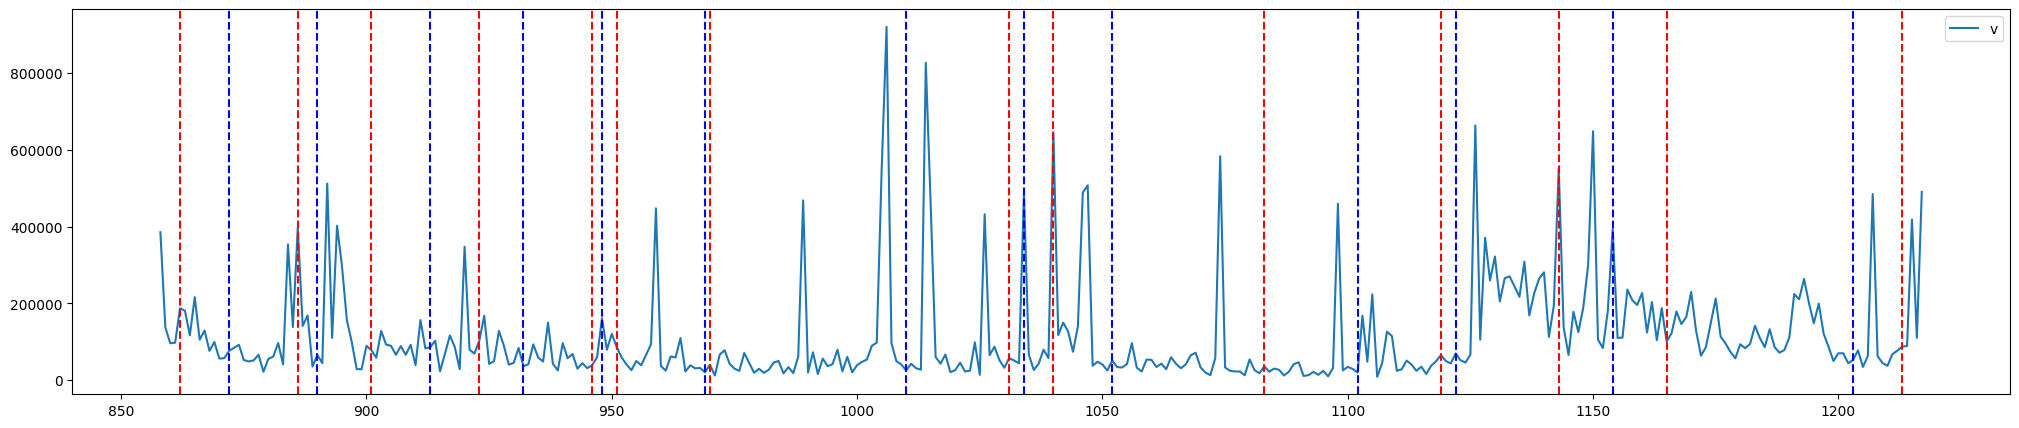

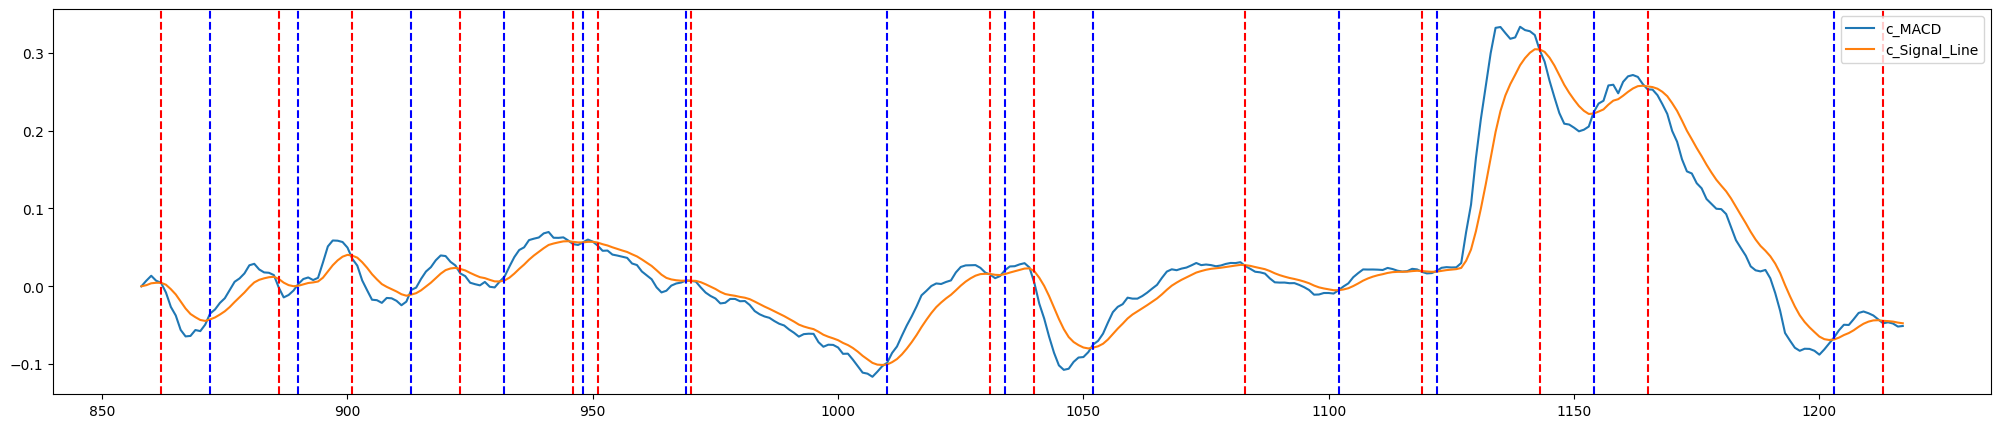

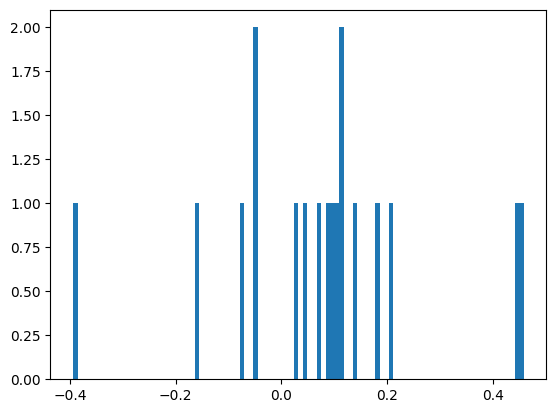

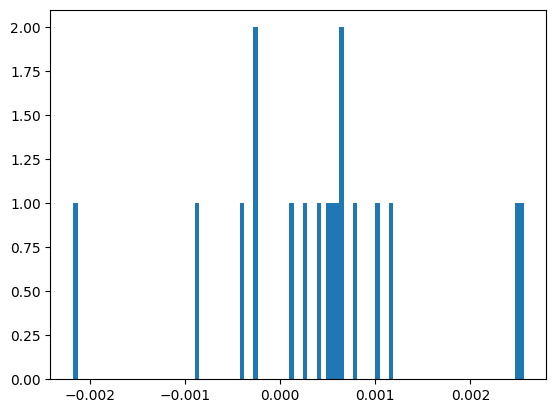

v        vw       o        c       h         l              t  \
1610  431941.0  179.3209  179.24  179.450  179.48  179.2000  1553175000000   
1611  210731.0  179.5161  179.47  179.495  179.60  179.4200  1553175060000   
1612  109326.0  179.4959  179.51  179.420  179.58  179.4000  1553175120000   
1613   99400.0  179.4426  179.41  179.420  179.51  179.3968  1553175180000   
1614  124065.0  179.4230  179.43  179.540  179.54  179.3400  1553175240000   

         n             datetime        date  ... vw_ma_12   vw_ema_12  \
1610  1382  2019-03-21-09:30:00  2019-03-21  ...      NaN  179.320900   
1611  1052  2019-03-21-09:31:00  2019-03-21  ...      NaN  179.350931   
1612   616  2019-03-21-09:32:00  2019-03-21  ...      NaN  179.373234   
1613   520  2019-03-21-09:33:00  2019-03-21  ...      NaN  179.383905   
1614   710  2019-03-21-09:34:00  2019-03-21  ...      NaN  179.389920   

      vw_ma_26   vw_ema_26   vw_MACD  vw_Signal_Line  vw_MACD_Signal_Line_dif  \
1610       NaN  179.320900  0.000000        0.000000                 0.000000   
1611       NaN  179.335359  0.015572        0.003114                 0.012457   
1612       NaN  179.347251  0.025983        0.007688                 0.018295   
1613       NaN  179.354314  0.029591        0.012069                 0.017523   
1614       NaN  179.359402  0.030518        0.015759                 0.014760   

      vw_MACD_Signal_Line_dif_shift1  vw_MACD_cross_over_upward  \
1610                             NaN                      False   
1611                        0.000000                      False   
1612                        0.012457                      False   
1613                        0.018295                      False   
1614                        0.017523                      False   

      vw_MACD_cross_over_downward  
1610                        False  
1611                        False  
1612                        False  
1613                        False  
1614                        False  

[5 rows x 31 columns]

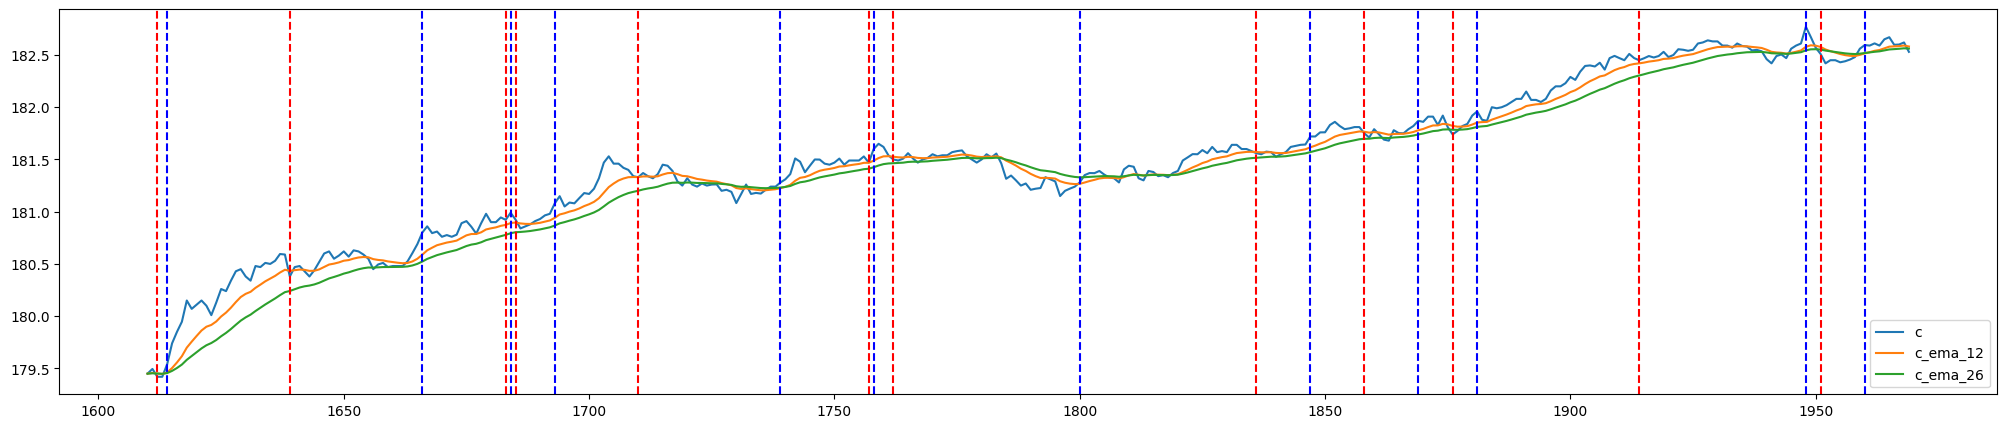

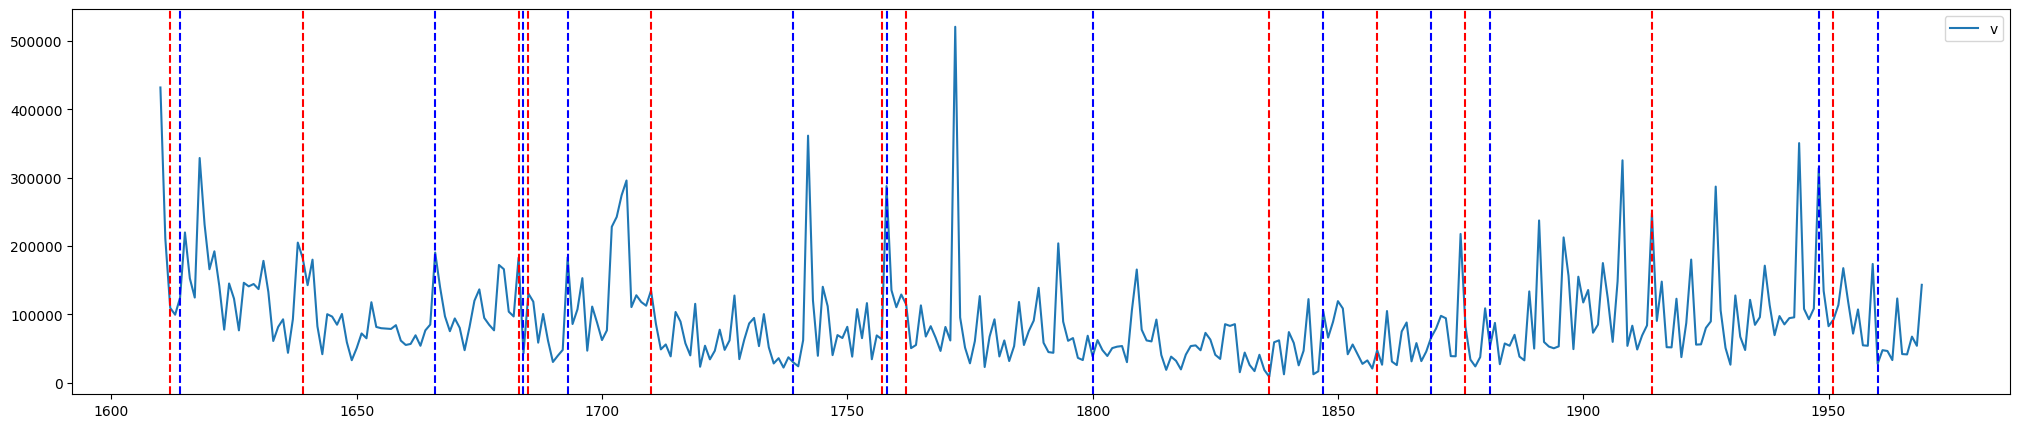

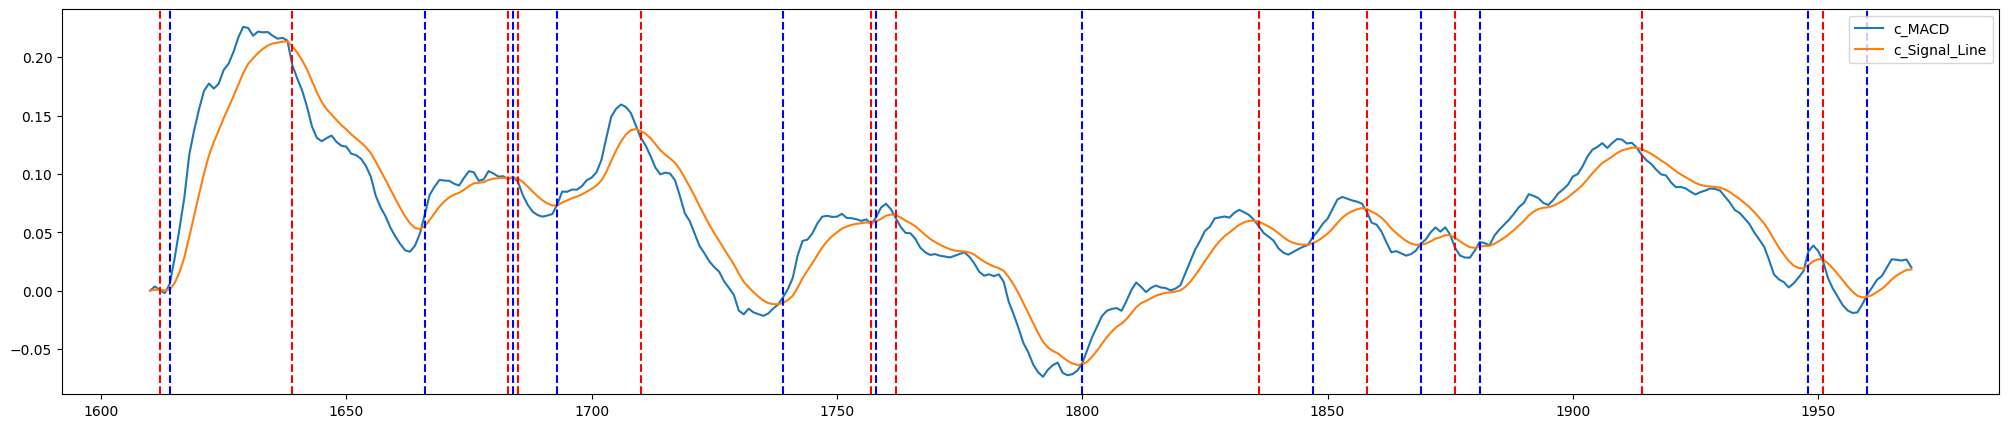

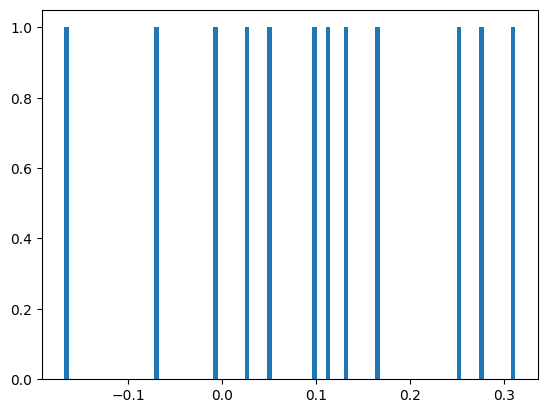

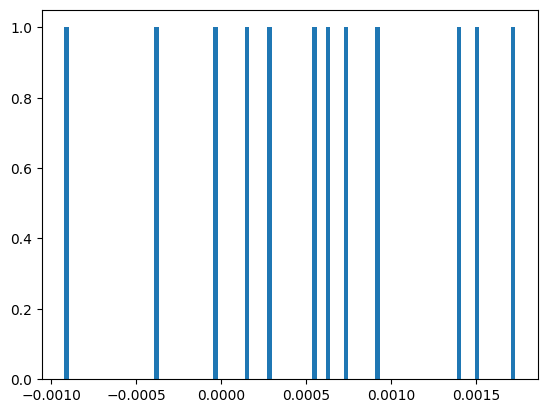

v        vw         o       c         h         l              t  \
2354  340455.0  181.7663  181.7600  181.87  181.9183  181.6700  1553261400000   
2355  164222.0  181.9317  181.8600  181.94  181.9600  181.8600  1553261460000   
2356  128240.0  181.9380  181.9400  181.98  182.0200  181.8800  1553261520000   
2357  198430.0  182.0528  182.0099  182.11  182.1300  181.9800  1553261580000   
2358  110816.0  182.0659  182.1100  182.07  182.1200  182.0187  1553261640000   

         n             datetime        date  ... vw_ma_12   vw_ema_12  \
2354  1335  2019-03-22-09:30:00  2019-03-22  ...      NaN  181.766300   
2355   809  2019-03-22-09:31:00  2019-03-22  ...      NaN  181.791746   
2356   633  2019-03-22-09:32:00  2019-03-22  ...      NaN  181.814247   
2357  1014  2019-03-22-09:33:00  2019-03-22  ...      NaN  181.850947   
2358   621  2019-03-22-09:34:00  2019-03-22  ...      NaN  181.884017   

      vw_ma_26   vw_ema_26   vw_MACD  vw_Signal_Line  vw_MACD_Signal_Line_dif  \
2354       NaN  181.766300  0.000000        0.000000                 0.000000   
2355       NaN  181.778552  0.013194        0.002639                 0.010555   
2356       NaN  181.790363  0.023884        0.006888                 0.016996   
2357       NaN  181.809803  0.041145        0.013739                 0.027405   
2358       NaN  181.828773  0.055244        0.022040                 0.033204   

      vw_MACD_Signal_Line_dif_shift1  vw_MACD_cross_over_upward  \
2354                             NaN                      False   
2355                        0.000000                      False   
2356                        0.010555                      False   
2357                        0.016996                      False   
2358                        0.027405                      False   

      vw_MACD_cross_over_downward  
2354                        False  
2355                        False  
2356                        False  
2357                        False  
2358                        False  

[5 rows x 31 columns]

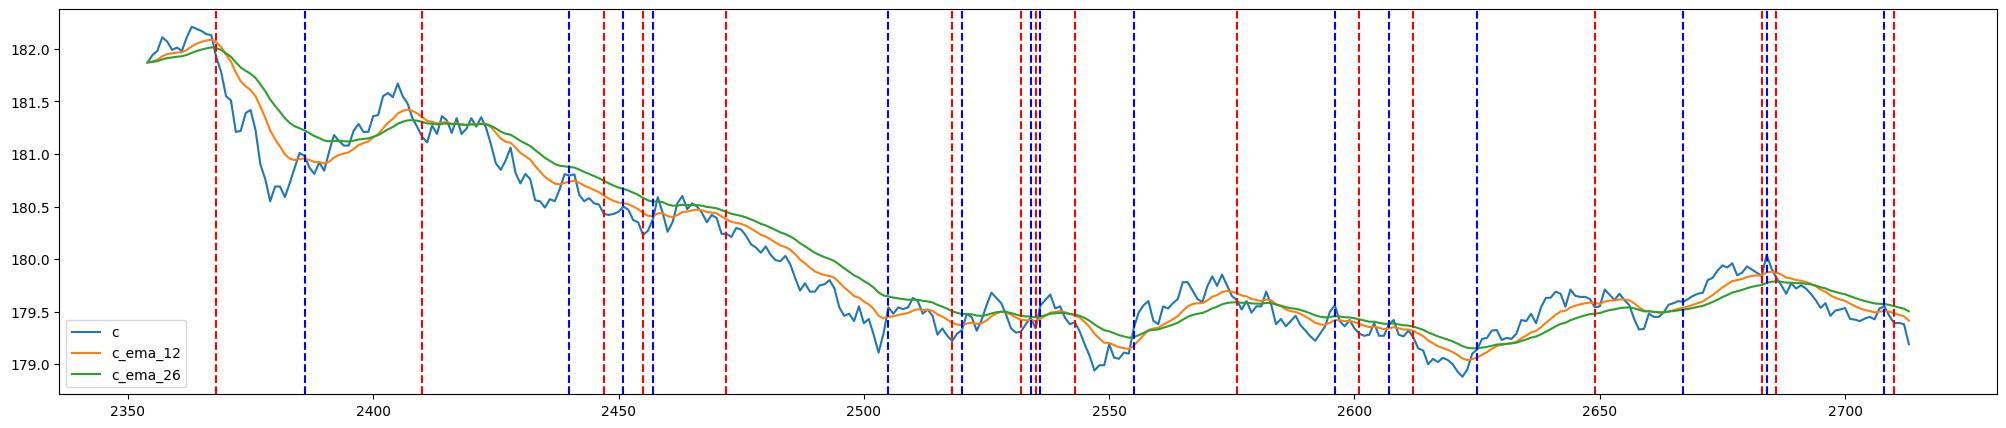

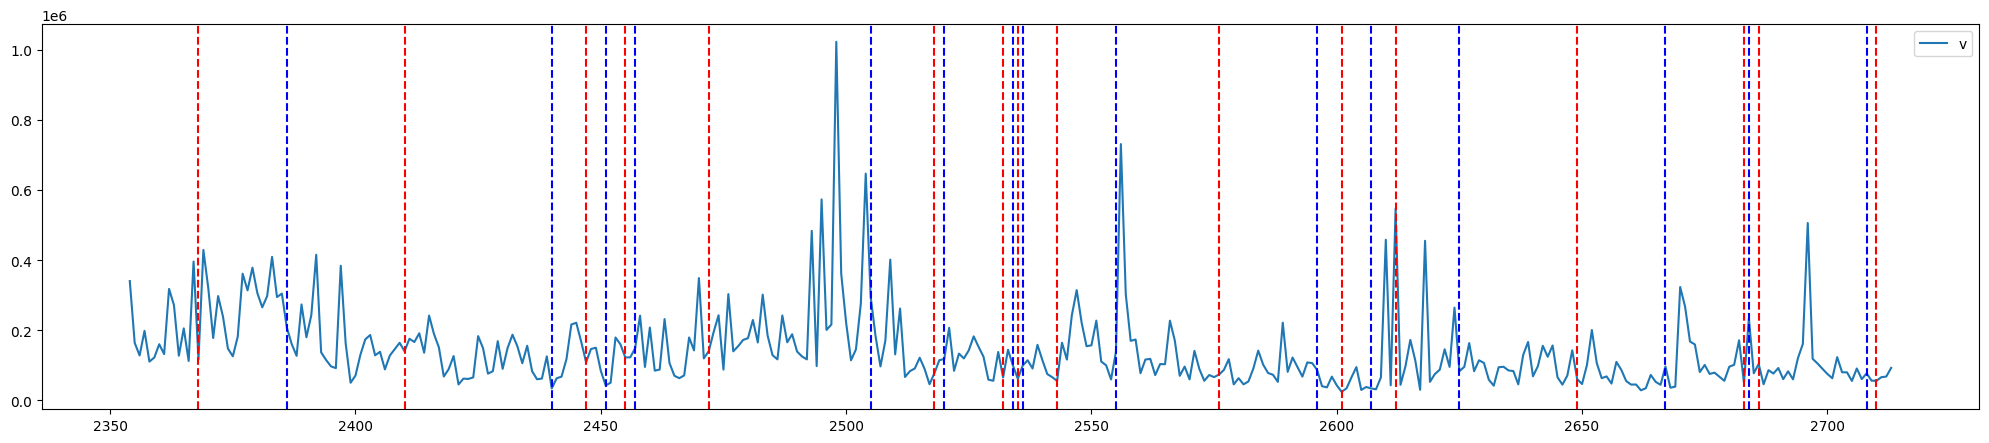

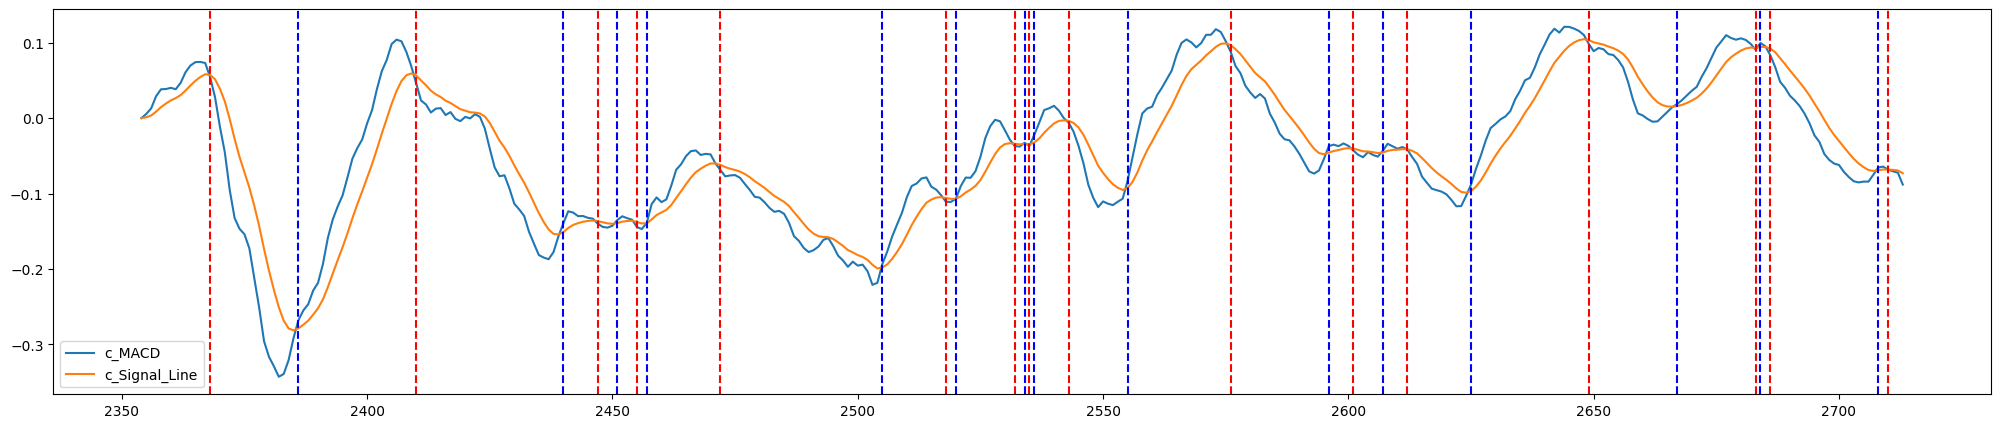

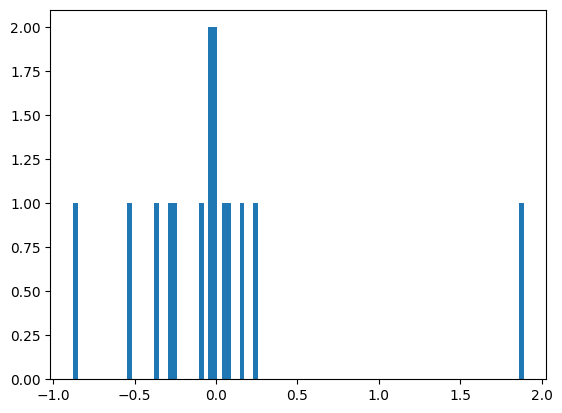

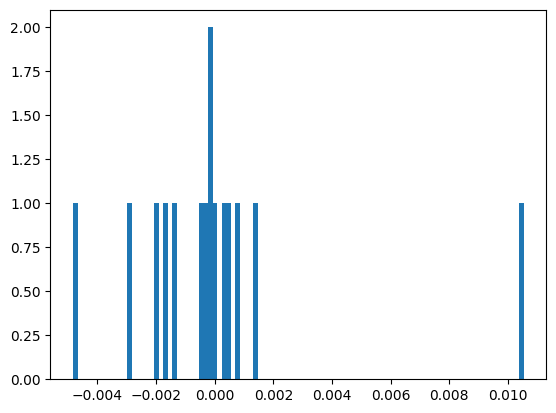

v        vw         o       c        h       l              t  \
3126  445255.0  177.8579  177.9200  177.83  177.930  177.76  1553520600000   
3127  268739.0  177.8370  177.8300  177.60  177.990  177.59  1553520660000   
3128  181099.0  177.6736  177.5975  177.79  177.800  177.54  1553520720000   
3129  216655.0  177.7844  177.8000  177.86  177.870  177.67  1553520780000   
3130  186554.0  177.8034  177.8600  177.92  177.925  177.68  1553520840000   

         n             datetime        date  ... vw_ma_12   vw_ema_12  \
3126  1647  2019-03-25-09:30:00  2019-03-25  ...      NaN  177.857900   
3127  1567  2019-03-25-09:31:00  2019-03-25  ...      NaN  177.854685   
3128  1136  2019-03-25-09:32:00  2019-03-25  ...      NaN  177.826825   
3129  1197  2019-03-25-09:33:00  2019-03-25  ...      NaN  177.820298   
3130  1214  2019-03-25-09:34:00  2019-03-25  ...      NaN  177.817699   

      vw_ma_26   vw_ema_26   vw_MACD  vw_Signal_Line  vw_MACD_Signal_Line_dif  \
3126       NaN  177.857900  0.000000        0.000000                 0.000000   
3127       NaN  177.856352 -0.001667       -0.000333                -0.001334   
3128       NaN  177.842815 -0.015989       -0.003465                -0.012525   
3129       NaN  177.838488 -0.018189       -0.006410                -0.011780   
3130       NaN  177.835889 -0.018190       -0.008766                -0.009424   

      vw_MACD_Signal_Line_dif_shift1  vw_MACD_cross_over_upward  \
3126                             NaN                      False   
3127                        0.000000                      False   
3128                       -0.001334                      False   
3129                       -0.012525                      False   
3130                       -0.011780                      False   

      vw_MACD_cross_over_downward  
3126                        False  
3127                        False  
3128                        False  
3129                        False  
3130                        False  

[5 rows x 31 columns]

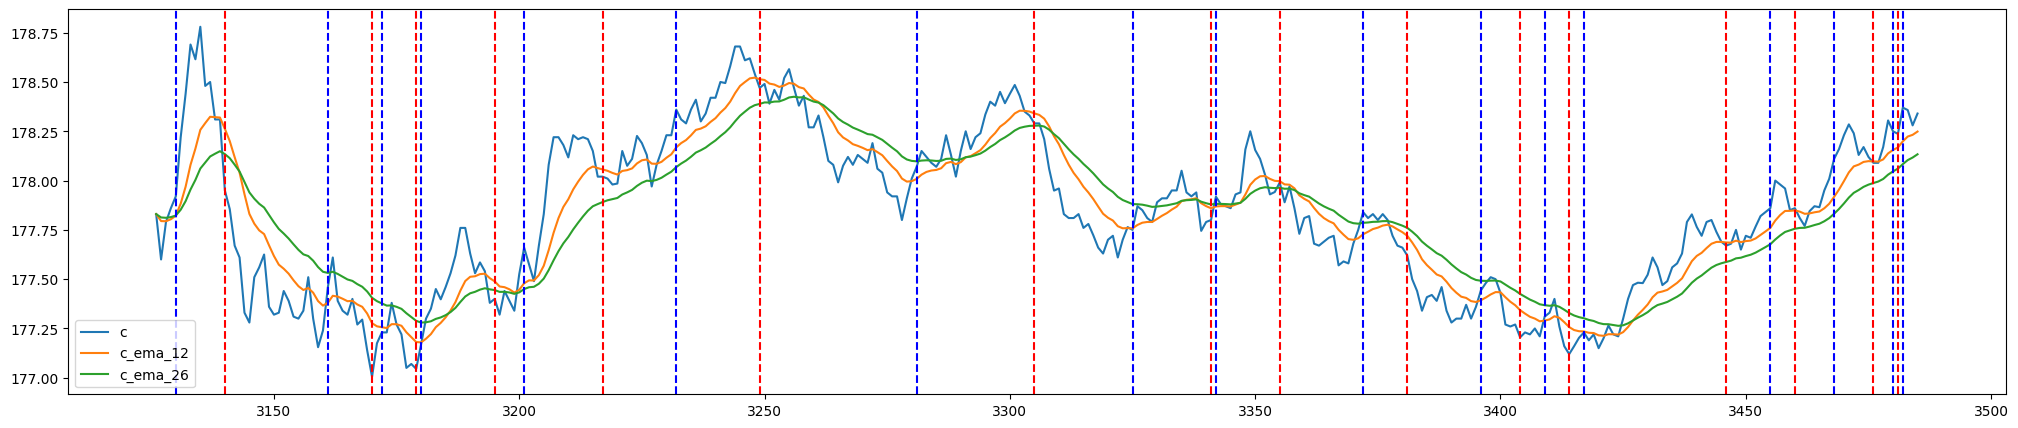

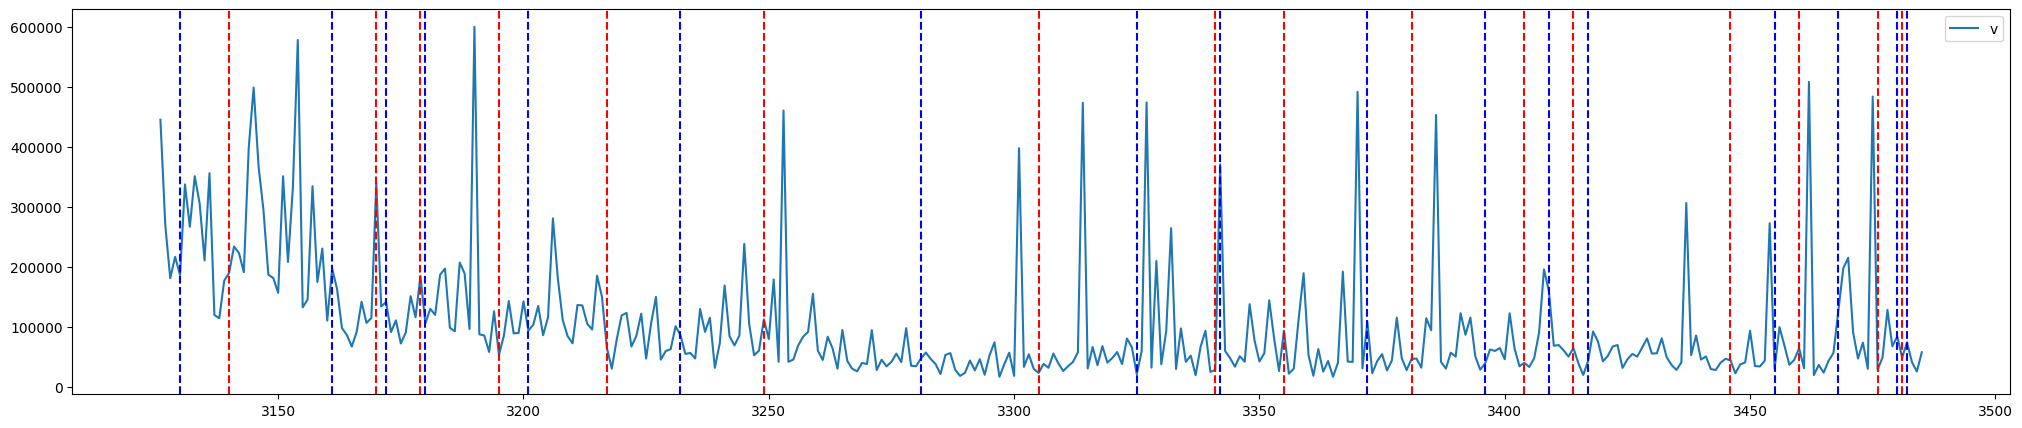

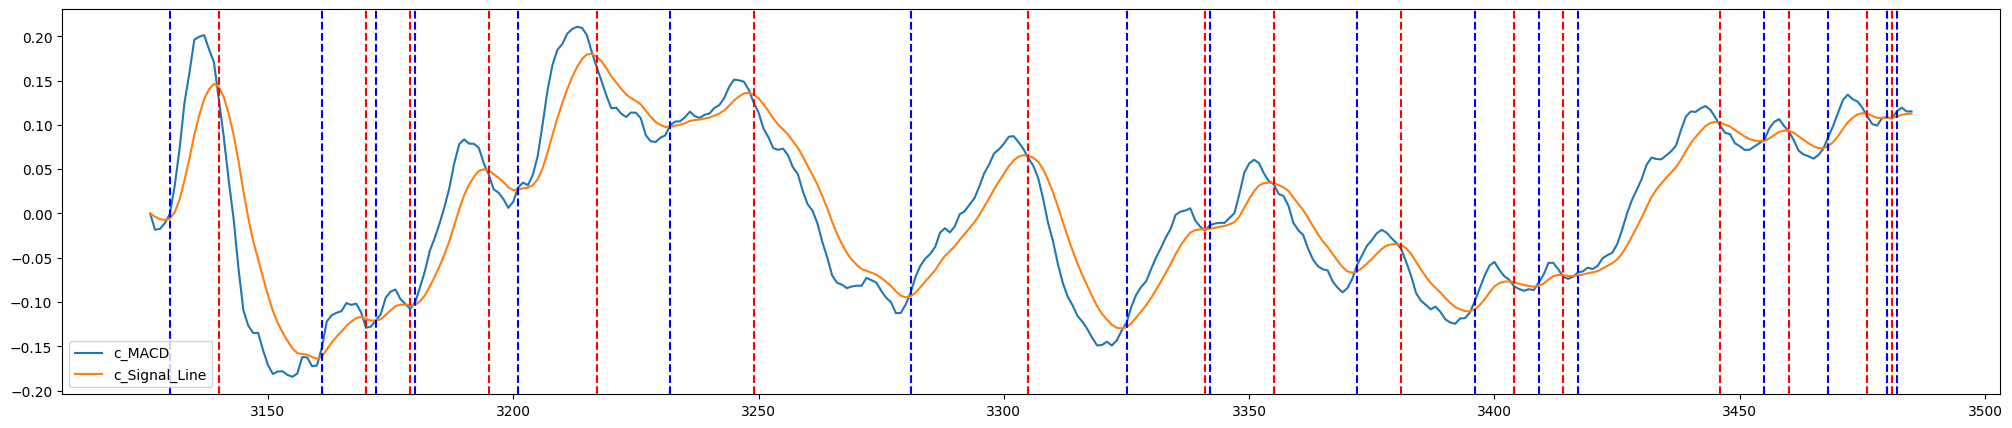

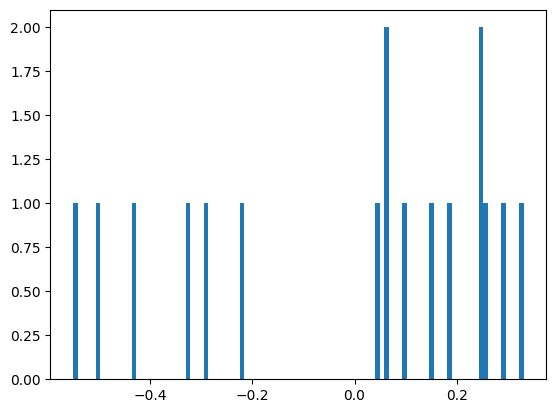

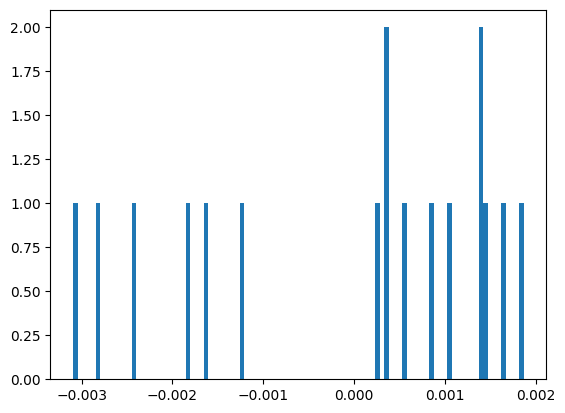

In [691]:
profits = []
rets = []
verbose=True
dfs = []
count = 0
for i, date in enumerate(tqdm(res_df.date.unique())):
    res_df_date = res_df[res_df["date"] == date]
    res_df_date_feature = res_df_date[res_df_date.apply(lambda x: datetime.datetime.strptime(x['time'], "%H:%M:%S") < datetime.datetime.strptime("15:30:00", "%H:%M:%S"), axis = 1)]                                   
    if res_df_date_feature['time'].iloc[-1] != "15:29:00":
        count += 1
        continue
    res_df_date_feauture_before1220 = res_df_date_feature[res_df_date_feature.apply(lambda x:datetime.datetime.strptime(x['time'], "%H:%M:%S") < datetime.datetime.strptime("15:20:00", "%H:%M:%S"), axis = 1)]
    future_week_earnings_num = [0] * 7
    future_week_earnings_cap = [0] * 7
    for day_index in range(7):
        date_future = datetime.datetime.strptime(date, "%Y-%m-%d") + datetime.timedelta(days=1)
        earnings = fc.get_earnings_by_date(date_future)
        for t_fe in tickers:
            if t_fe in earnings.index:
                future_week_earnings_num[day_index] += 1
                future_week_earnings_cap[day_index] += convert_dollar_to_int(earnings.loc[t_fe]['marketCap']) * 0.000001
#     print(future_week_earnings_num)
#     print(future_week_earnings_cap)
    for col in ['c','vw']:
        for window_size in [12, 26]:
            res_df_date_feature[col + "_ma_{}".format(str(window_size))] = res_df_date_feature[col].rolling(window=window_size).mean()
            res_df_date_feature[col + "_ema_{}".format(str(window_size))] = res_df_date_feature[col].ewm(span=window_size, adjust=False).mean()
        
        res_df_date_feature[col+'_MACD'] = res_df_date_feature[col+'_ema_12'] - res_df_date_feature[col+'_ema_26']
        res_df_date_feature[col+'_Signal_Line'] = res_df_date_feature[col+'_MACD'].ewm(span=9, adjust=False).mean()
        res_df_date_feature[col+"_MACD_Signal_Line_dif"] = res_df_date_feature[col+'_MACD'] - res_df_date_feature[col+'_Signal_Line']
        res_df_date_feature[col+"_MACD_Signal_Line_dif_shift1"] = res_df_date_feature[col+"_MACD_Signal_Line_dif"].shift(1)
        res_df_date_feature[col+"_MACD_cross_over_upward"] = res_df_date_feature.apply(lambda x:x[col+"_MACD_Signal_Line_dif"] < 0 and x[col+"_MACD_Signal_Line_dif_shift1"] > 0, axis = 1)
        res_df_date_feature[col+"_MACD_cross_over_downward"] = res_df_date_feature.apply(lambda x:x[col+"_MACD_Signal_Line_dif"] > 0 and x[col+"_MACD_Signal_Line_dif_shift1"] < 0, axis = 1)
    profit, ret = calculate_return_with_MACD(res_df_date_feature)
    new_line = flatten_df(res_df_date_feature, ['v', 'vw', 'o', 'c', 'h', 'l','c_ma_12', 'c_ema_12', 'c_ma_26', 'c_ema_26','vw_ma_12',
       'vw_ema_12', 'vw_ma_26', 'vw_ema_26'])
    new_line['max_drop_down'] = (res_df_date_feauture_before1220['c'].max() - res_df_date_feauture_before1220['c'].min()) / res_df_date_feauture_before1220.iloc[0]['c']
    new_line['volatility'] = np.log(res_df_date_feauture_before1220['c'] / res_df_date_feauture_before1220['c'].shift(1)).std() * np.sqrt(252) 
    for day_index in range(7):
        new_line['next_week_fe_number_{}'.format(day_index)] = future_week_earnings_num[day_index]
        new_line['next_week_fe_cap_{}'.format(day_index)] = future_week_earnings_cap[day_index]
    new_line['date'] = date
    dfs.append(new_line)
    if verbose and i < 5:
        display(res_df_date_feature.head())
        plt.figure(figsize=(25, 5))
        for col in res_df_date_feature.columns:
            if col in ['c_ema_12','c_ema_26','c']:
                plt.plot(res_df_date_feature[col], label = col)
            if 'c_MACD_cross_over_upward' in col:
                for pos in res_df_date_feature[res_df_date_feature[col]].index.values:
                    plt.axvline(x=pos, color='r', linestyle='--')
            if 'c_MACD_cross_over_downward' in col:
                for pos in res_df_date_feature[res_df_date_feature[col]].index.values:
                    plt.axvline(x=pos, color='b', linestyle='--')
        plt.legend()
        plt.show()
        plt.figure(figsize=(25, 5))
        for col in res_df_date_feature.columns:
            if col in ['v']:
                plt.plot(res_df_date_feature[col], label = col)
            if 'c_MACD_cross_over_upward' in col:
                for pos in res_df_date_feature[res_df_date_feature[col]].index.values:
                    plt.axvline(x=pos, color='r', linestyle='--')
            if 'c_MACD_cross_over_downward' in col:
                for pos in res_df_date_feature[res_df_date_feature[col]].index.values:
                    plt.axvline(x=pos, color='b', linestyle='--')
        plt.legend()
        plt.show()
        plt.figure(figsize=(25, 5))
        for col in res_df_date_feature.columns:
            if col in ['c_MACD','c_Signal_Line']:
                plt.plot(res_df_date_feature[col], label = col)
            if 'c_MACD_cross_over_upward' in col:
                for pos in res_df_date_feature[res_df_date_feature[col]].index.values:
                    plt.axvline(x=pos, color='r', linestyle='--')
            if 'c_MACD_cross_over_downward' in col:
                for pos in res_df_date_feature[res_df_date_feature[col]].index.values:
                    plt.axvline(x=pos, color='b', linestyle='--')
        plt.legend()
        plt.show()
        plt.hist(profit, bins = 100)
        plt.show()
        plt.hist(ret, bins = 100)
        plt.show()
#     print(np.mean(profit))
    profits += profit
    rets.append(ret)


In [431]:
np.mean(rets)

0.00010607771647411014

In [439]:
calculate_sharpe_ratio_from_returns(rets, risk_free_rate=15 * 0.05 / 365 / 24 / 60) * np.sqrt(252 * 15)

2.2190246494366

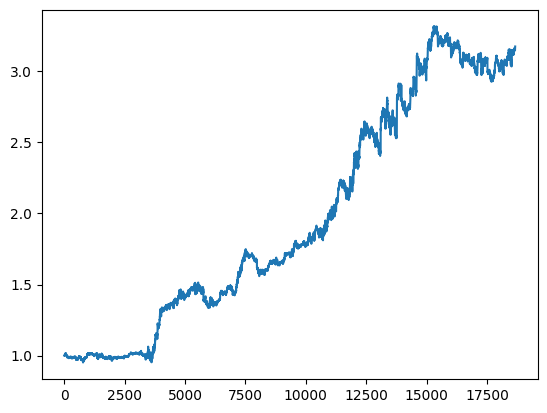

In [435]:
plt.plot(np.cumprod([(1 + r-0.00004) for r in rets]))

In [380]:
print(count)  

6


In [ ]:
res_df_cleaned

In [692]:
df_feature = pd.DataFrame().from_dict(dfs)
data_list = list(label.items())
df_label = pd.DataFrame(data_list, columns=['date', 'label'])
df_all = df_feature.merge(df_label, on ='date')
df_all

14:30:00_n  14:30:00_c_MACD  14:30:00_c_Signal_Line  \
0          270.0         0.018257                0.006032   
1         1031.0         0.258881                0.238453   
2          376.0         0.129469                0.120192   
3          391.0         0.083704                0.092714   
4          289.0        -0.018636               -0.045231   
...          ...              ...                     ...   
1240       507.0        -0.084851               -0.012138   
1241      1122.0         0.108660                0.102491   
1242       659.0         0.006044                0.018613   
1243       799.0         0.000996                0.009776   
1244       930.0         0.073315               -0.018418   

      14:30:00_c_MACD_Signal_Line_dif  14:30:00_c_MACD_Signal_Line_dif_shift1  \
0                            0.012225                                0.016792   
1                            0.020428                                0.024637   
2                            0.009277                                0.012037   
3                           -0.009010                               -0.010075   
4                            0.026595                                0.017234   
...                               ...                                     ...   
1240                        -0.072714                               -0.079556   
1241                         0.006169                                0.003943   
1242                        -0.012570                               -0.016053   
1243                        -0.008780                                0.002738   
1244                         0.091733                                0.100378   

     14:30:00_c_MACD_cross_over_upward 14:30:00_c_MACD_cross_over_downward  \
0                                False                               False   
1                                False                               False   
2                                False                               False   
3                                False                               False   
4                                False                               False   
...                                ...                                 ...   
1240                             False                               False   
1241                             False                               False   
1242                             False                               False   
1243                              True                               False   
1244                             False                               False   

      14:30:00_vw_MACD  14:30:00_vw_Signal_Line  \
0             0.027478                 0.011318   
1             0.268376                 0.228194   
2             0.131858                 0.120999   
3             0.078588                 0.083502   
4            -0.031147                -0.056172   
...                ...                      ...   
1240         -0.050194                 0.034164   
1241          0.109711                 0.100387   
1242         -0.006228                 0.012546   
1243         -0.027524                -0.036098   
1244          0.084546                -0.020489   

      14:30:00_vw_MACD_Signal_Line_dif  ...  next_week_fe_number_3  \
0                             0.016160  ...                      1   
1                             0.040183  ...                      1   
2                             0.010859  ...                      0   
3                            -0.004914  ...                      0   
4                             0.025025  ...                      0   
...                                ...  ...                    ...   
1240                         -0.084358  ...                      0   
1241                          0.009324  ...                      0   
1242                         -0.018775  ...                      2   
1243                          0.008575  ...       

In [693]:
[i for i in df_all.columns if "0" not in i]

['max_drop_down',
 'volatility',
 'next_week_fe_number_1',
 'next_week_fe_cap_1',
 'next_week_fe_number_2',
 'next_week_fe_cap_2',
 'next_week_fe_number_3',
 'next_week_fe_cap_3',
 'next_week_fe_number_4',
 'next_week_fe_cap_4',
 'next_week_fe_number_5',
 'next_week_fe_cap_5',
 'next_week_fe_number_6',
 'next_week_fe_cap_6',
 'date',
 'label']

In [694]:
import xgboost as xgb
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

In [695]:
X_train = df_all[500:1000].drop(['label','date'],axis = 1).values
y_train = df_all[500:1000]['label'].values
X_test = df_all[1000:].drop(['label','date'],axis = 1).values
y_test = df_all[1000:]['label'].values

In [696]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [699]:
params = {
    'max_depth': 5,  # the maximum depth of each tree
    'eta': 0.05,      # the training step for each iteration
    'objective': 'binary:logistic',  # binary classification
    'eval_metric': ['auc','logloss'],  # evaluation metric
    'subsample': 0.8,
    'lambda':2,
    'colsample_bytree':0.7, 'colsample_bylevel':0.7, 'colsample_bynode':0.7
}
num_rounds = 1000  # the number of training iterations

In [700]:
bst = xgb.train(params, dtrain, num_rounds, 
                early_stopping_rounds=10,  # Stops training if the evaluation metric does not improve in 10 consecutive rounds
                evals=[(dtest, 'test')])

[0]	test-auc:0.53605	test-logloss:0.41541
[1]	test-auc:0.57490	test-logloss:0.41364
[2]	test-auc:0.61252	test-logloss:0.41104
[3]	test-auc:0.59544	test-logloss:0.41015
[4]	test-auc:0.57810	test-logloss:0.40991
[5]	test-auc:0.57000	test-logloss:0.40973
[6]	test-auc:0.56170	test-logloss:0.40961
[7]	test-auc:0.57667	test-logloss:0.40803
[8]	test-auc:0.58088	test-logloss:0.40740
[9]	test-auc:0.59143	test-logloss:0.40625
[10]	test-auc:0.59782	test-logloss:0.40518
[11]	test-auc:0.60163	test-logloss:0.40440
[12]	test-auc:0.59129	test-logloss:0.40445
[13]	test-auc:0.57878	test-logloss:0.40500
[14]	test-auc:0.58803	test-logloss:0.40489
[15]	test-auc:0.58912	test-logloss:0.40533
[16]	test-auc:0.59088	test-logloss:0.40443
[17]	test-auc:0.56857	test-logloss:0.40594
[18]	test-auc:0.58463	test-logloss:0.40508
[19]	test-auc:0.58694	test-logloss:0.40499
[20]	test-auc:0.60952	test-logloss:0.40250
[21]	test-auc:0.61034	test-logloss:0.40252
[22]	test-auc:0.60408	test-logloss:0.40224
[23]	test-auc:0.59265

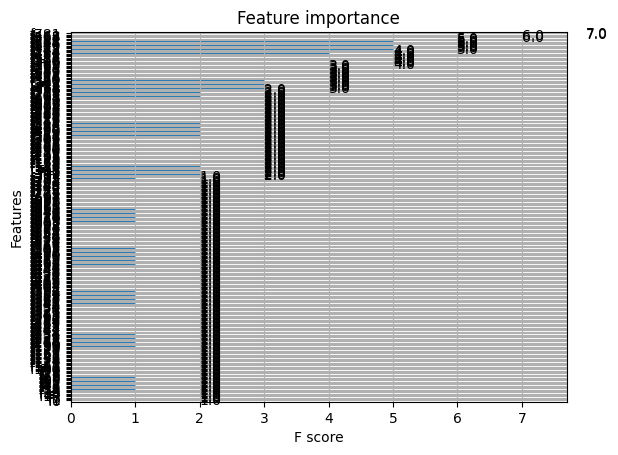

In [701]:
feature_importances_weight = bst.get_score(importance_type='weight')
xgb.plot_importance(feature_importances_weight)
plt.show()

In [702]:
importance = bst.get_score(importance_type='weight')

# Convert importance dictionary to a sorted DataFrame for easier visualization
feature_importances_df = pd.DataFrame(importance.items(), columns=['Feature', 'Importance']).sort_values(by='Importance', ascending=False)
feature_importances_df["Column"] = feature_importances_df.apply(lambda x:df_all.columns[int(x['Feature'][1:])],axis = 1)
print(feature_importances_df)

    Feature  Importance                                   Column
165    f468         7.0                               15:06:00_n
271    f781         7.0                               volatility
123    f364         6.0                               14:58:00_n
201    f555         6.0         15:12:00_vw_MACD_Signal_Line_dif
206    f568         5.0         15:13:00_vw_MACD_Signal_Line_dif
46     f143         5.0                               14:41:00_n
196    f546         5.0                               15:12:00_n
156    f455         5.0                               15:05:00_n
127    f377         5.0                               14:59:00_n
194    f533         5.0                               15:11:00_n
265    f757         5.0          15:28:00_c_MACD_Signal_Line_dif
212    f582         5.0  15:14:00_vw_MACD_Signal_Line_dif_shift1
202    f556         5.0  15:12:00_vw_MACD_Signal_Line_dif_shift1
140    f412         4.0         15:01:00_vw_MACD_Signal_Line_dif
158    f458         4.0  

In [672]:
importance

{'f13': 2.0,
 'f23': 1.0,
 'f74': 2.0,
 'f78': 3.0,
 'f165': 1.0,
 'f166': 1.0,
 'f169': 1.0,
 'f208': 4.0,
 'f302': 2.0,
 'f309': 1.0,
 'f316': 2.0,
 'f325': 1.0,
 'f353': 1.0,
 'f360': 1.0,
 'f366': 1.0,
 'f416': 1.0,
 'f419': 1.0,
 'f445': 1.0,
 'f455': 4.0,
 'f459': 1.0,
 'f498': 1.0,
 'f542': 2.0,
 'f555': 1.0,
 'f556': 1.0,
 'f568': 3.0,
 'f569': 1.0,
 'f582': 4.0,
 'f603': 2.0,
 'f620': 1.0,
 'f652': 2.0,
 'f701': 2.0,
 'f781': 4.0}

In [477]:
res_df

v        vw       o        c       h       l              t  \
0       284694.0  184.7303  184.75  184.710  184.80  184.66  1554903000000   
1       192000.0  184.5854  184.73  184.550  184.75  184.52  1554903060000   
2       104897.0  184.5778  184.56  184.560  184.61  184.54  1554903120000   
3       135698.0  184.5869  184.55  184.680  184.70  184.52  1554903180000   
4       154919.0  184.7232  184.68  184.735  184.77  184.66  1554903240000   
...          ...       ...     ...      ...     ...     ...            ...   
501291   11071.0  438.6604  438.59  438.700  438.71  438.59  1709759520000   
501292    4908.0  438.7441  438.74  438.750  438.76  438.73  1709759580000   
501293   26782.0  438.6807  438.75  438.650  438.76  438.65  1709759640000   
501294    4512.0  438.6477  438.66  438.650  438.66  438.63  1709759700000   
501295    1696.0  438.6567  438.65  438.660  438.66  438.65  1709759760000   

           n             datetime        date  ... o_open_for_the_date  \
0        916  2019-04-10-09:30:00  2019-04-10  ...              184.75   
1       1018  2019-04-10-09:31:00  2019-04-10  ...              184.75   
2        577  2019-04-10-09:32:00  2019-04-10  ...              184.75   
3        754  2019-04-10-09:33:00  2019-04-10  ...              184.75   
4        813  2019-04-10-09:34:00  2019-04-10  ...              184.75   
...      ...                  ...         ...  ...                 ...   
501291    37  2024-03-06-16:12:00  2024-03-06  ...              440.32   
501292    53  2024-03-06-16:13:00  2024-03-06  ...              440.32   
501293    78  2024-03-06-16:14:00  2024-03-06  ...              440.32   
501294    53  2024-03-06-16:15:00  2024-03-06  ...              440.32   
501295    28  2024-03-06-16:16:00  2024-03-06  ...              440.32   

        next_trade_date_close_for_the_previous_date  delta_from_today  \
0                                               NaN            -0.040   
1                                               NaN            -0.200   
2                                               NaN            -0.190   
3                                               NaN            -0.070   
4                                               NaN            -0.015   
...                                             ...               ...   
501291                                   2024-03-06            -1.620   
501292                                   2024-03-06            -1.570   
501293                                   2024-03-06            -1.670   
501294                                   2024-03-06            -1.670   
501295                                   2024-03-06            -1.660   

        next_trade_date_close_for_the_previous_date  \
0                                               NaN   
1                                               NaN   
2                                               NaN   
3                                               NaN   
4                                               NaN   
...                                             ...   
501291                                   2024-03-06   
501292                                   2024-03-06   
501293                                   2024-03-06   
501294                                   2024-03-06   
501295                                   2024-03-06   

        c_close_for_the_previous_date  delta_from_yesterday  \
0                                 NaN               184.710   
1                                 NaN               184.550   
2                                 NaN               184.560   
3                                 NaN               184.680   
4                                 NaN               184.735   
...                               ...                   ...   
501291                          440.8                -2.100   
501292                          440.8                -2.050   
501293                          440.8                -2.150   
501294               

<Axes: >

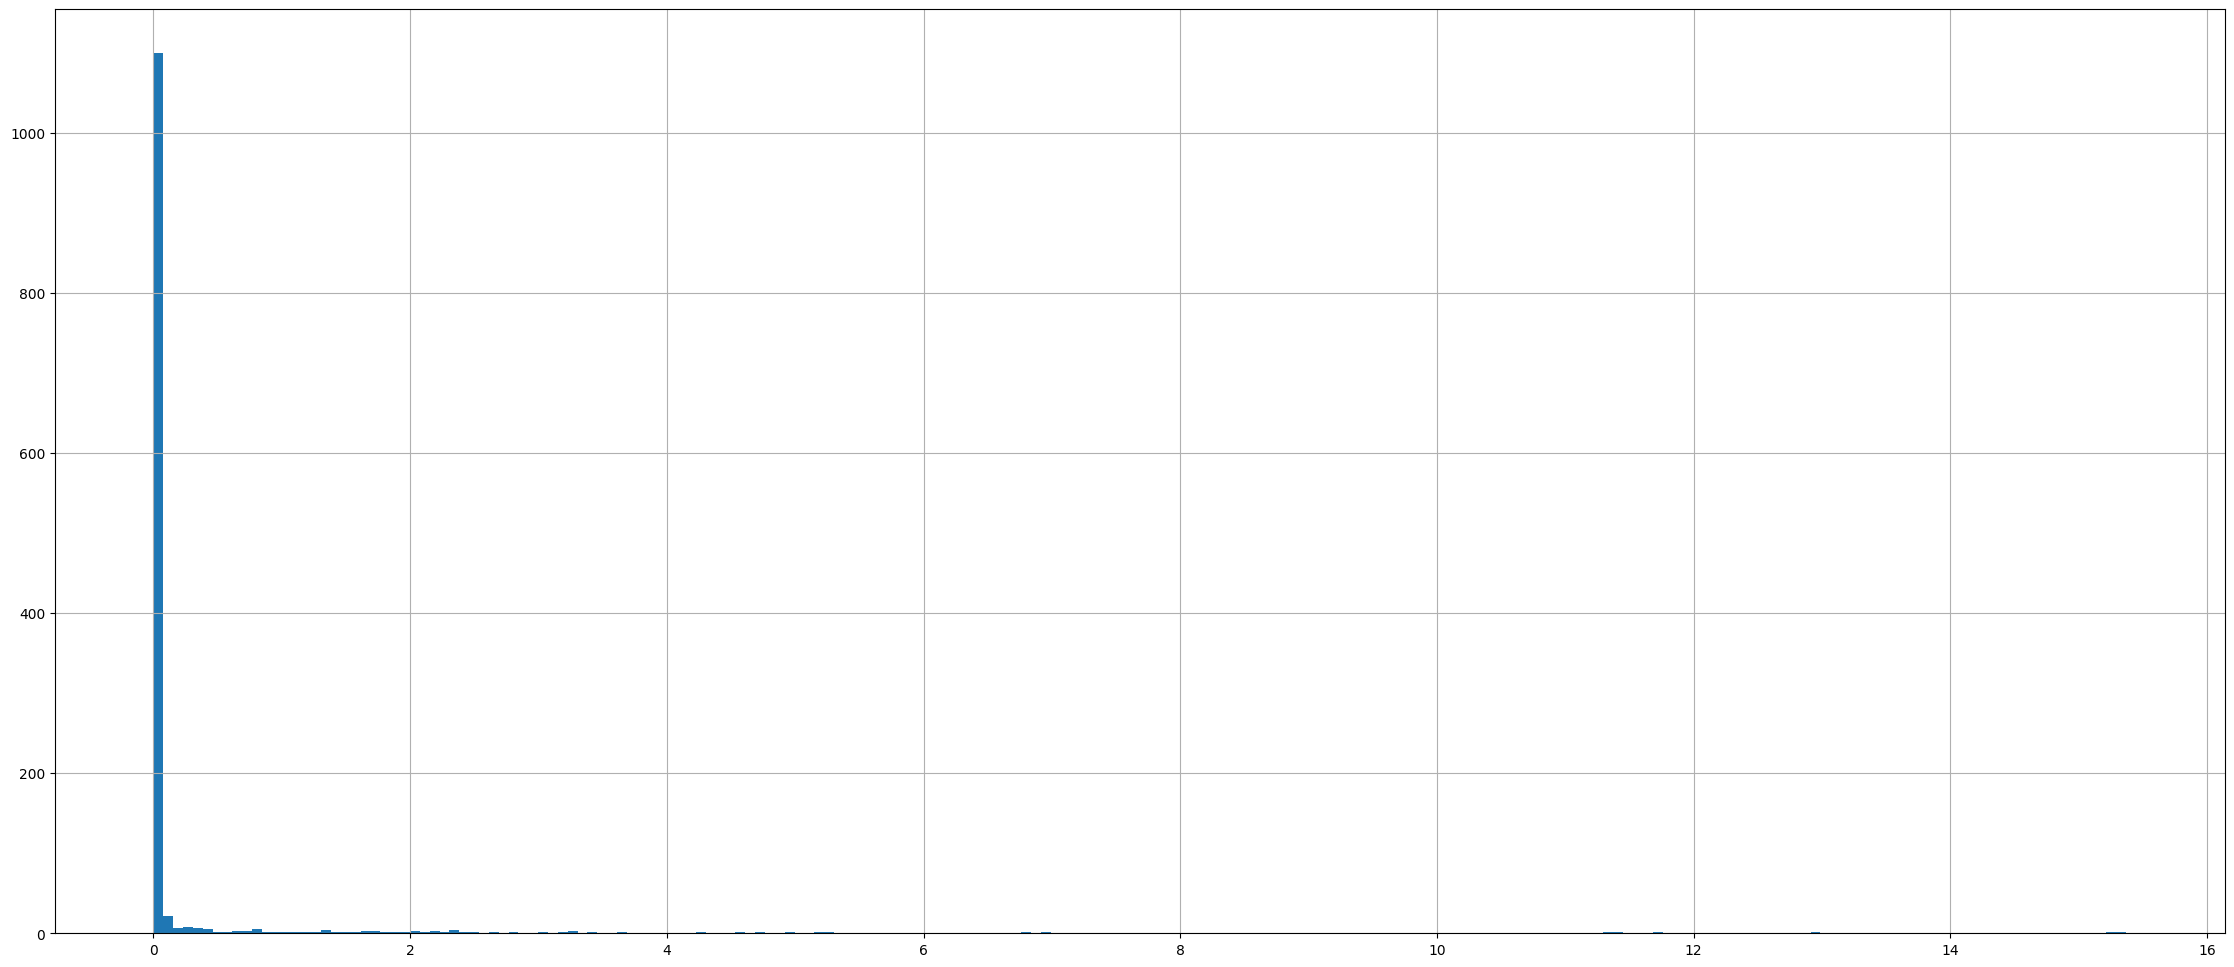

In [541]:
res_df[res_df['time'] == "15:29:00"].dropna()['MSE_5'].hist(bins = 200)

<Axes: >

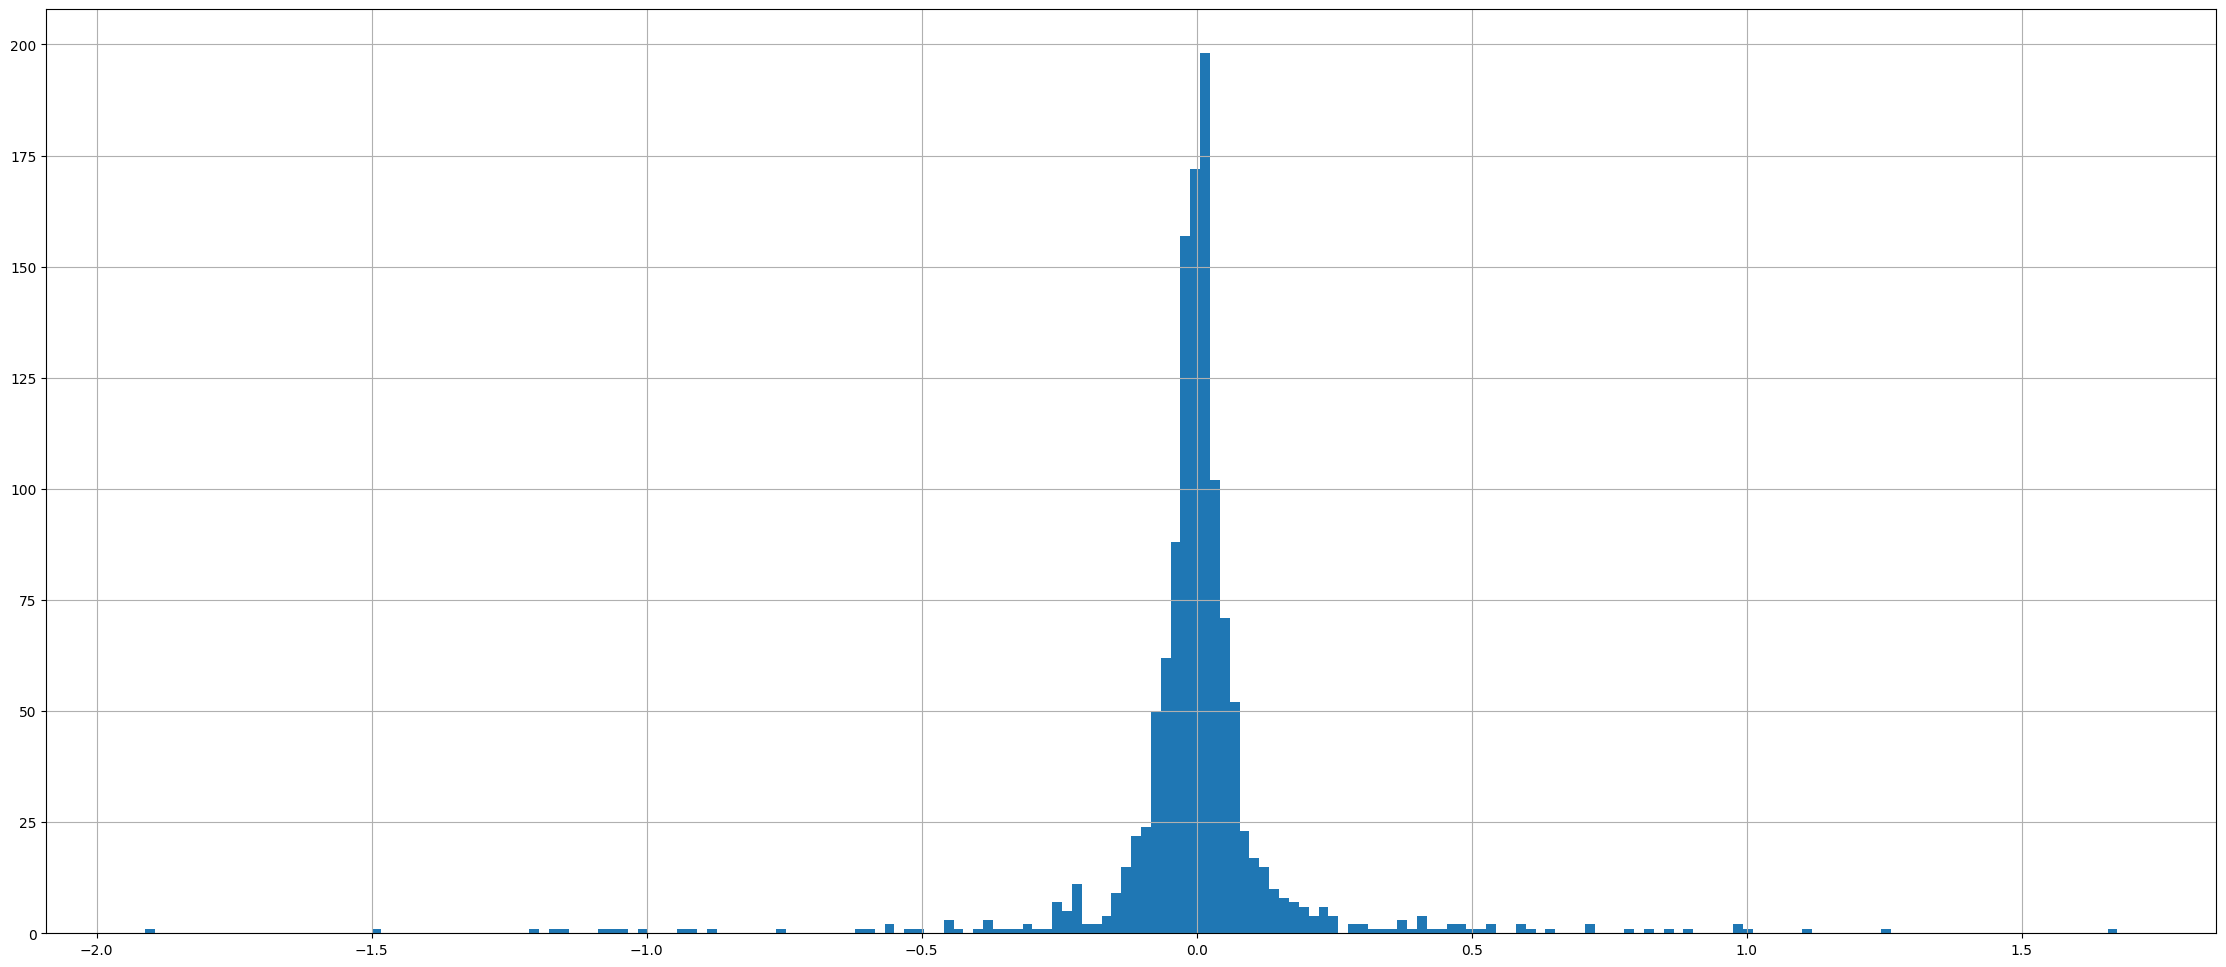

In [550]:
res_df[res_df['time'] == "15:29:00"].dropna()['Slope_5'].hist(bins = 200)

In [534]:
res_df.iloc[10]

v                                                          77534.0
vw                                                         184.586
o                                                           184.59
c                                                         184.5809
h                                                         184.6399
l                                                           184.54
t                                                    1554903600000
n                                                              409
datetime                                       2019-04-10-09:40:00
date                                                    2019-04-10
time                                                      09:40:00
Slope_5                                                   -0.03695
Intercept_5                                              184.76534
R-squared_5                                               0.716428
MSE_5                                                     0.00

In [563]:
def is_valid(df):
    return df[df['time'] <= "15:29:00"]['delta_ret_from_yesterday'].min() < -0.005 and df[df['time'] == "15:29:00"]['Slope_5'].values[0] > 0.05 and df[df['time'] == "15:29:00"]['R-squared_5'].values[0] > 0.8

  0%|          | 0/600 [00:00<?, ?it/s]

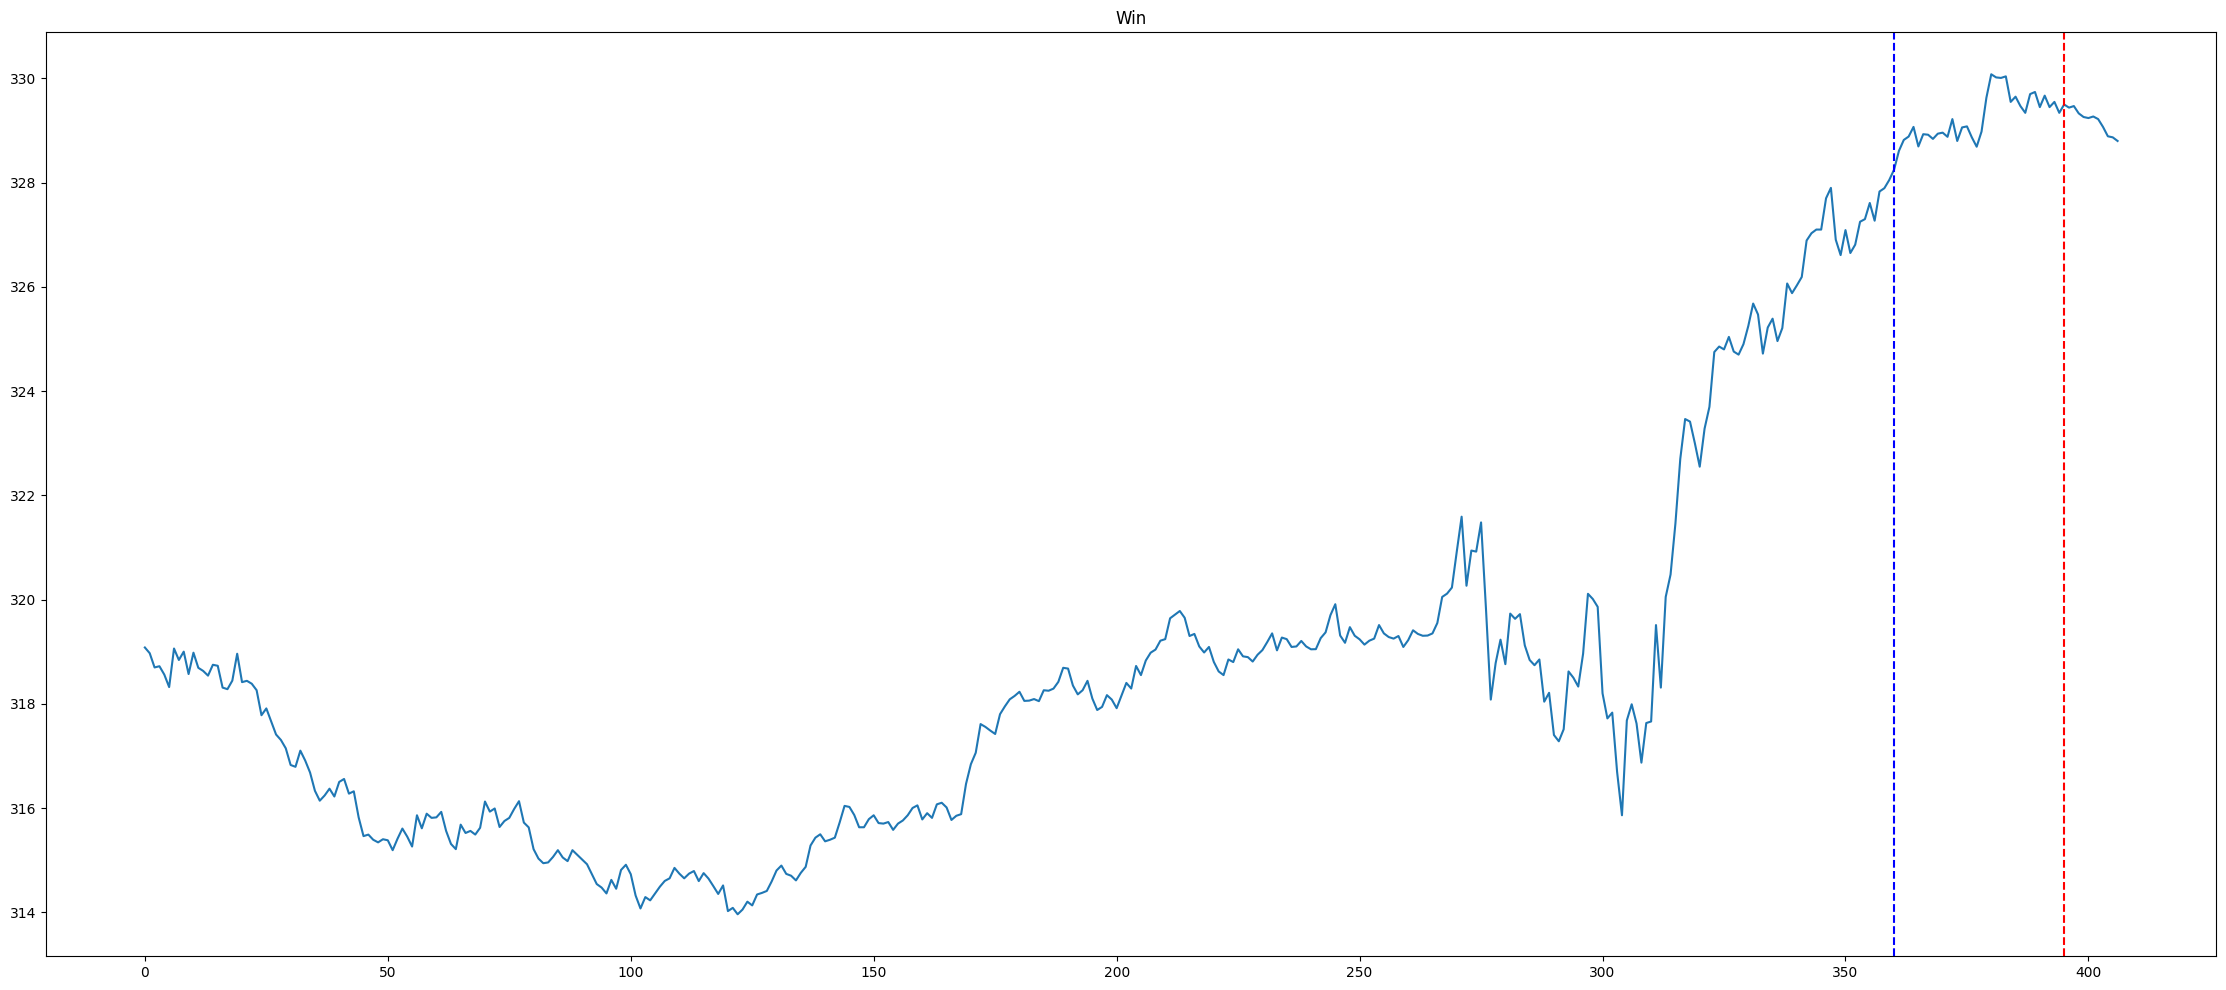

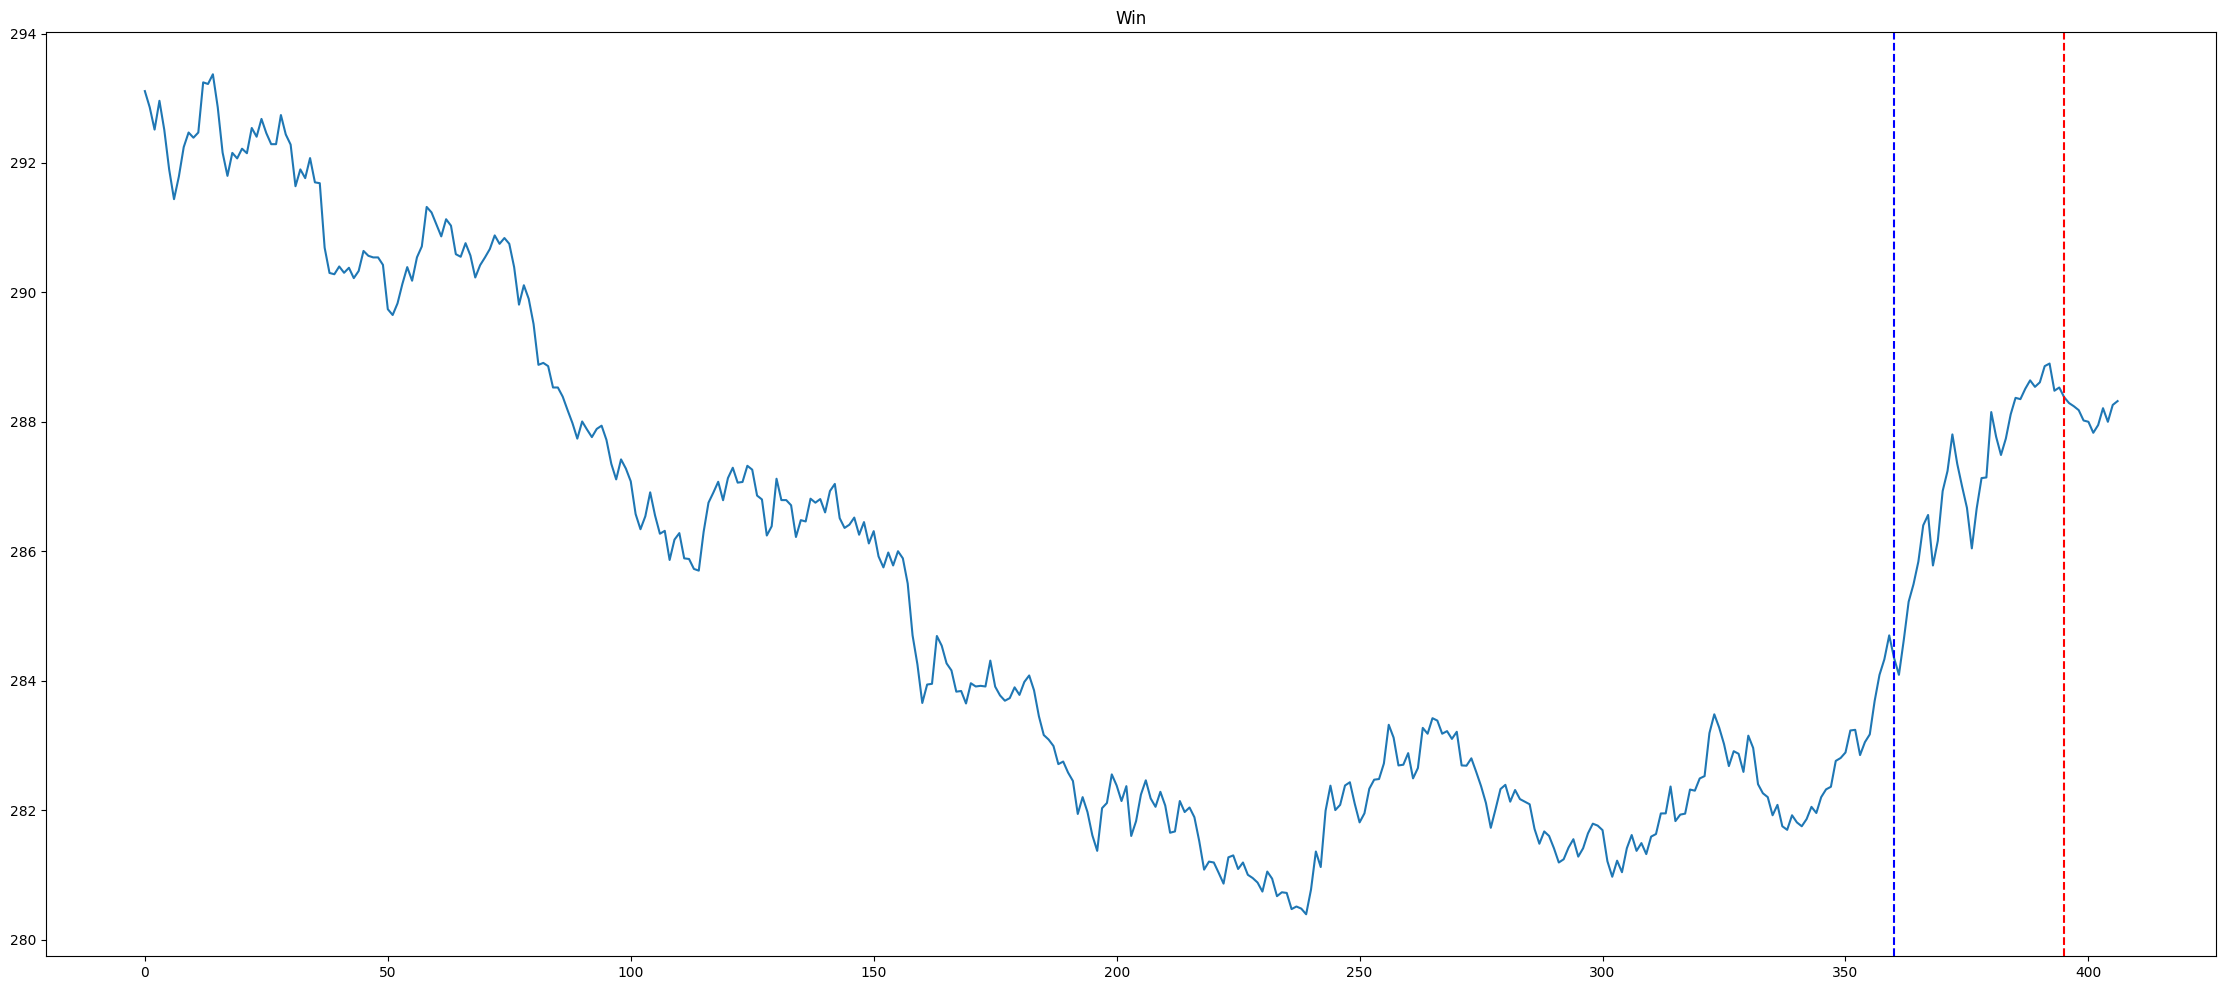

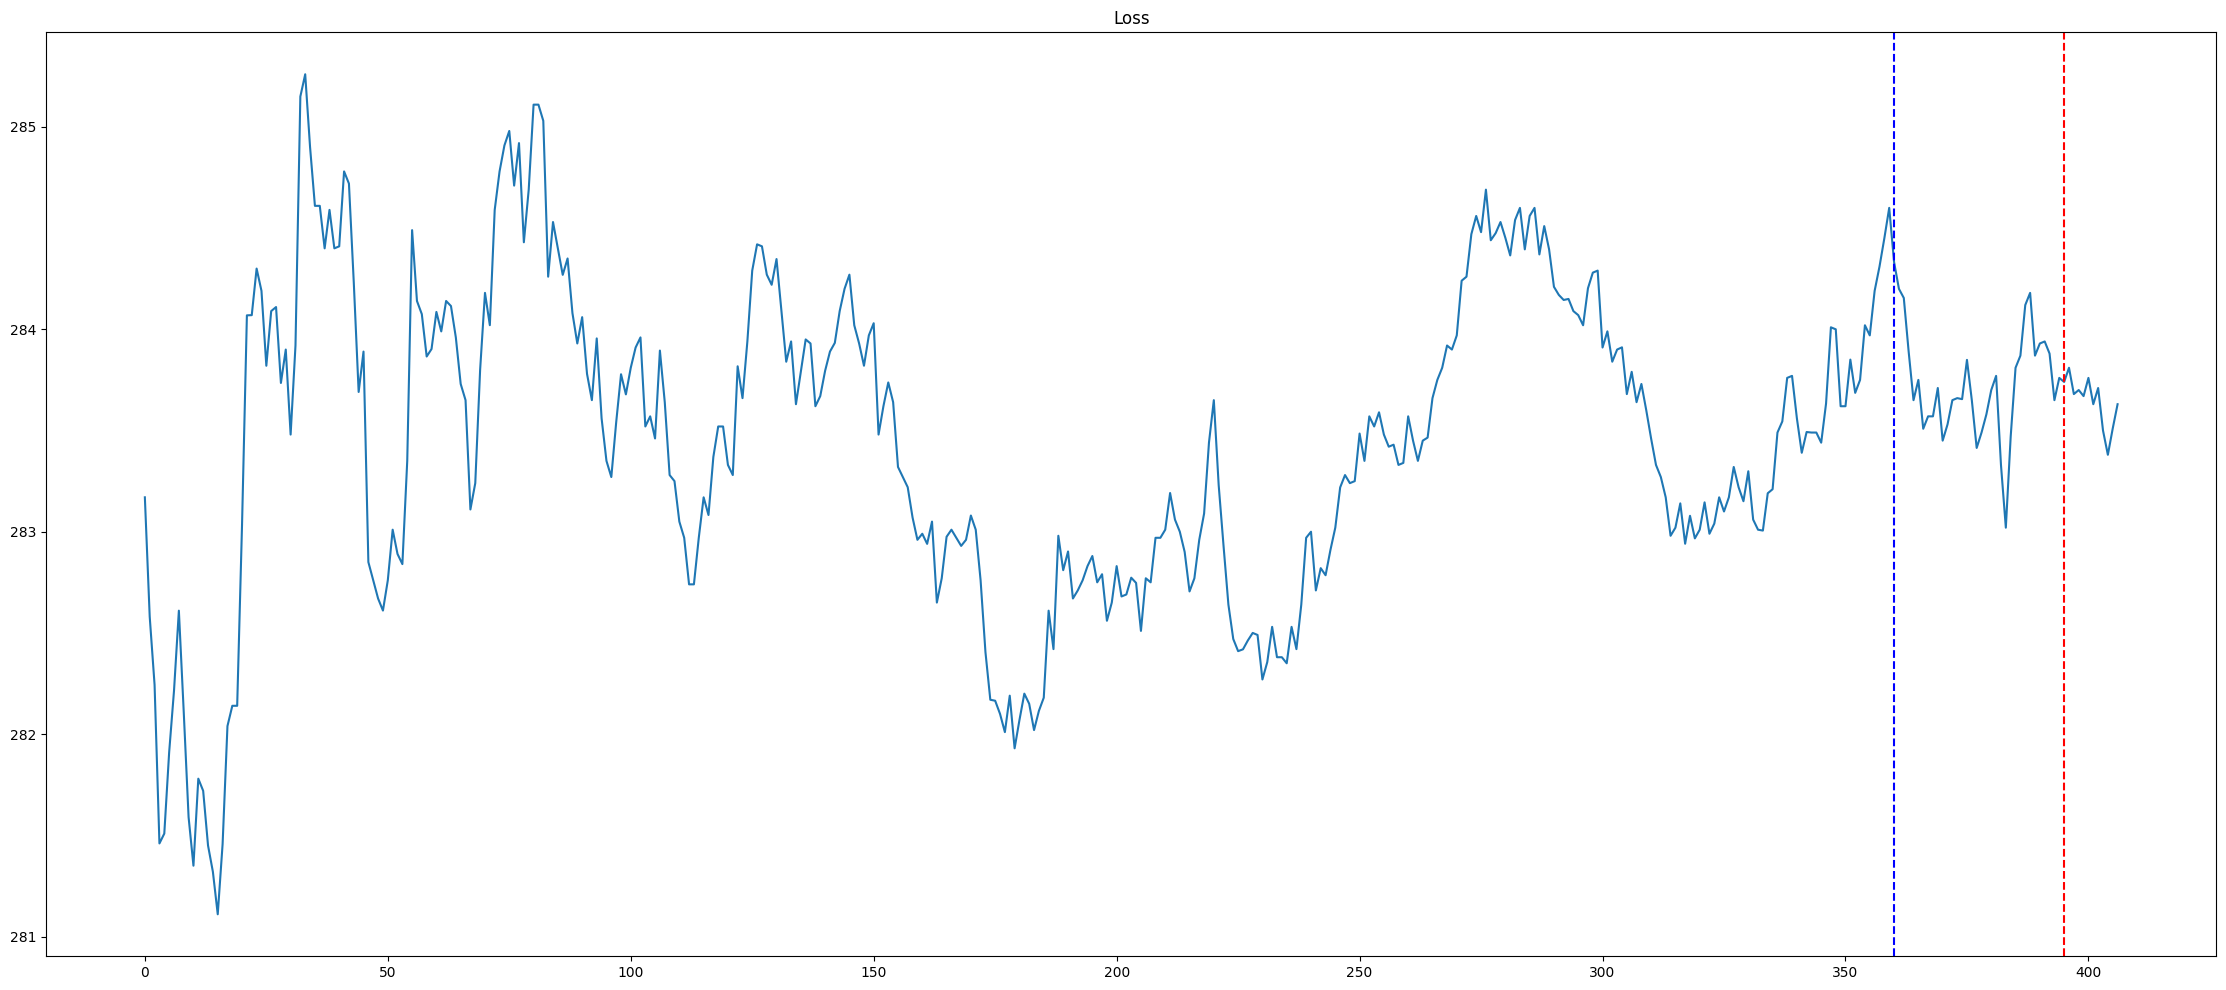

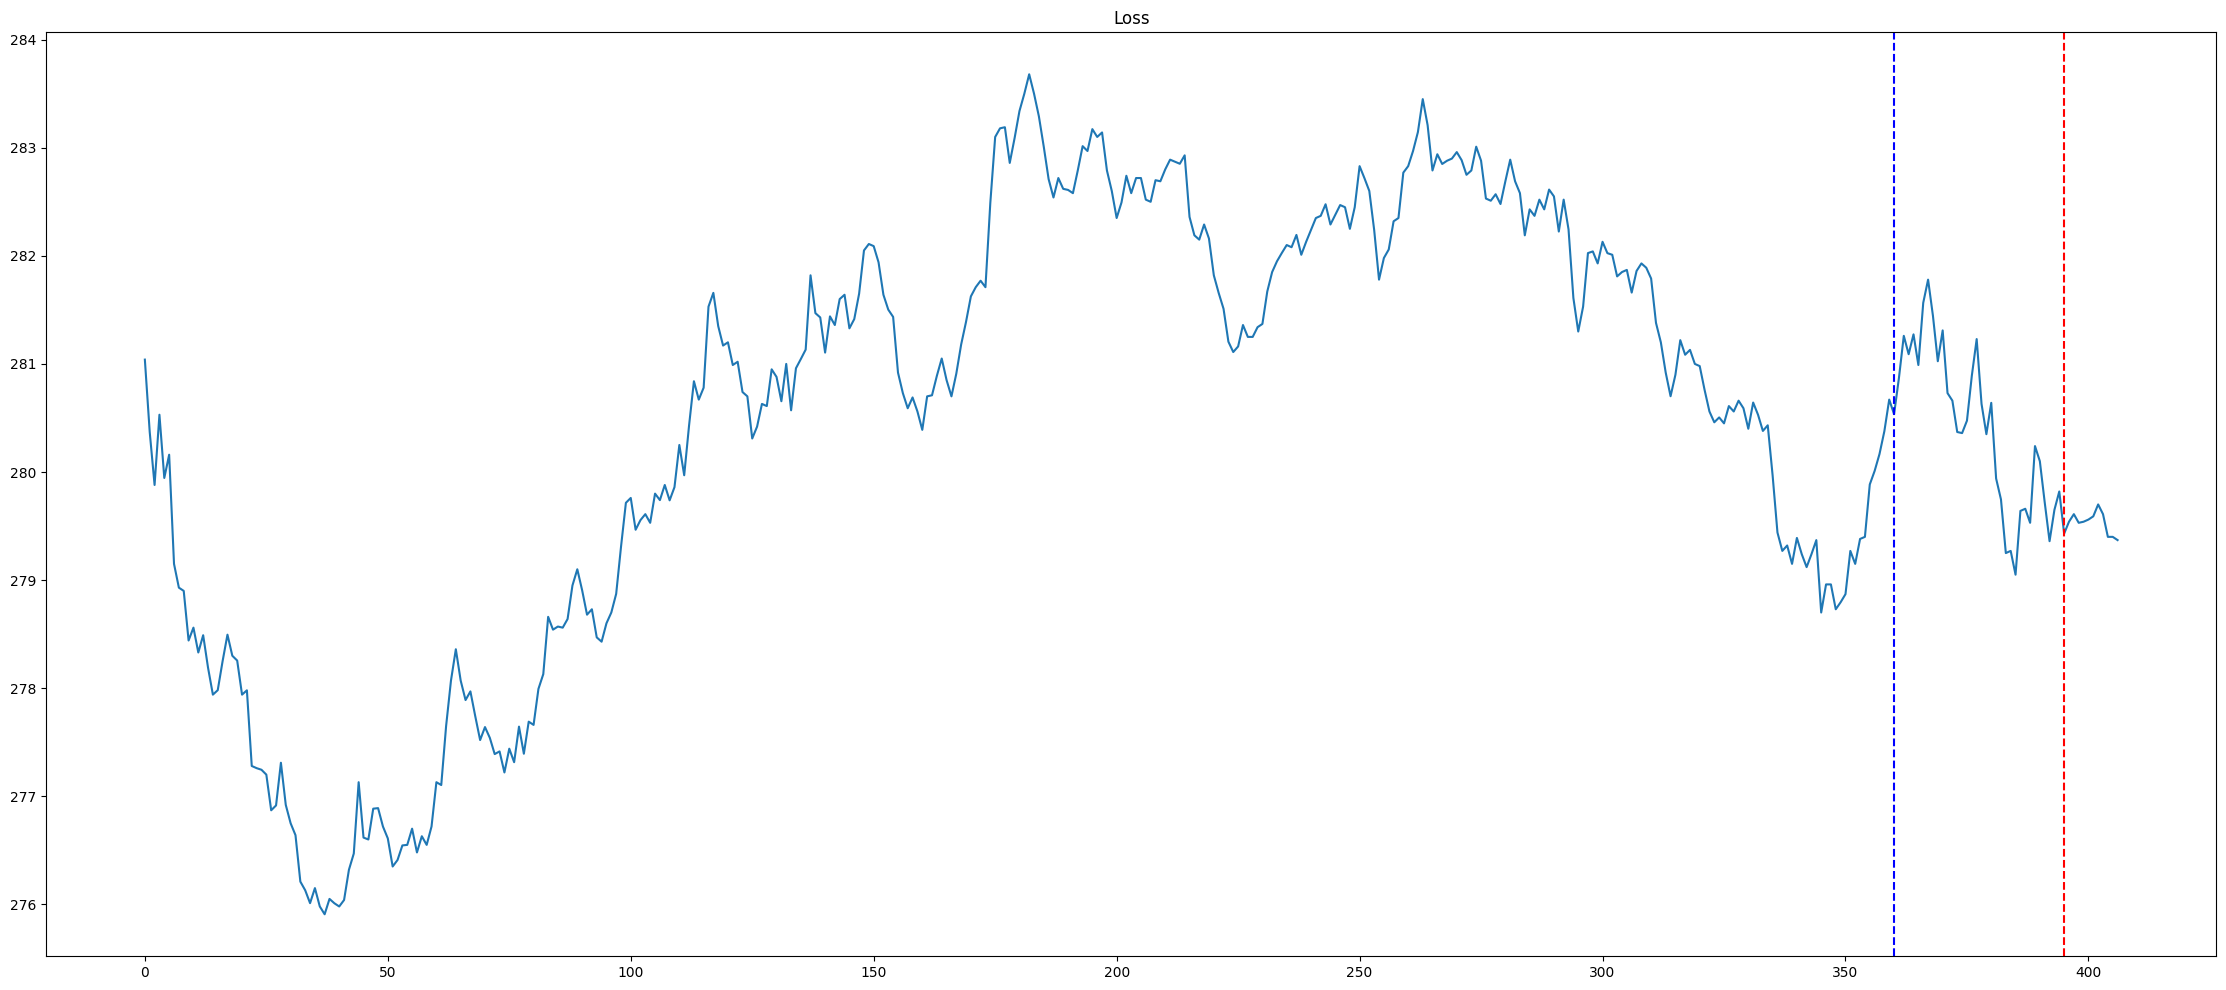

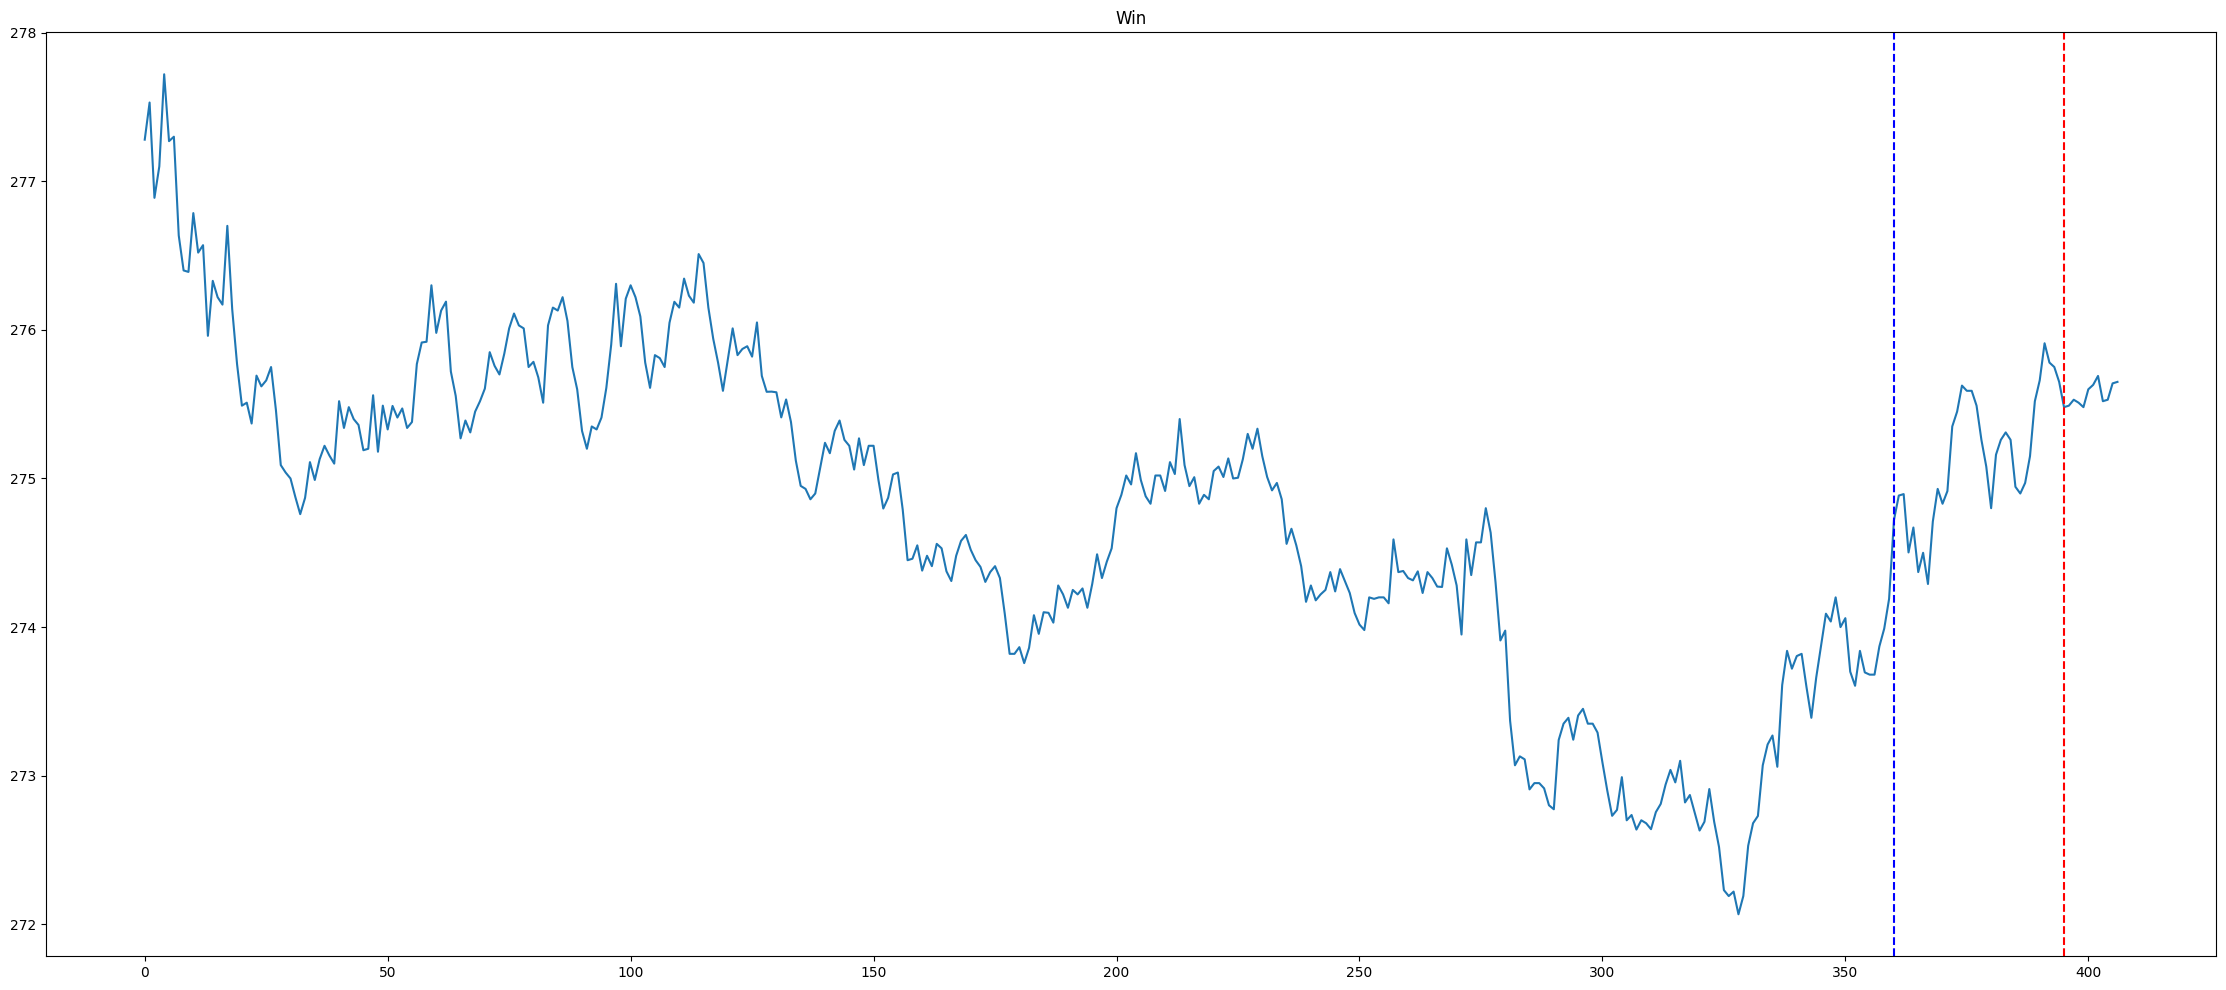

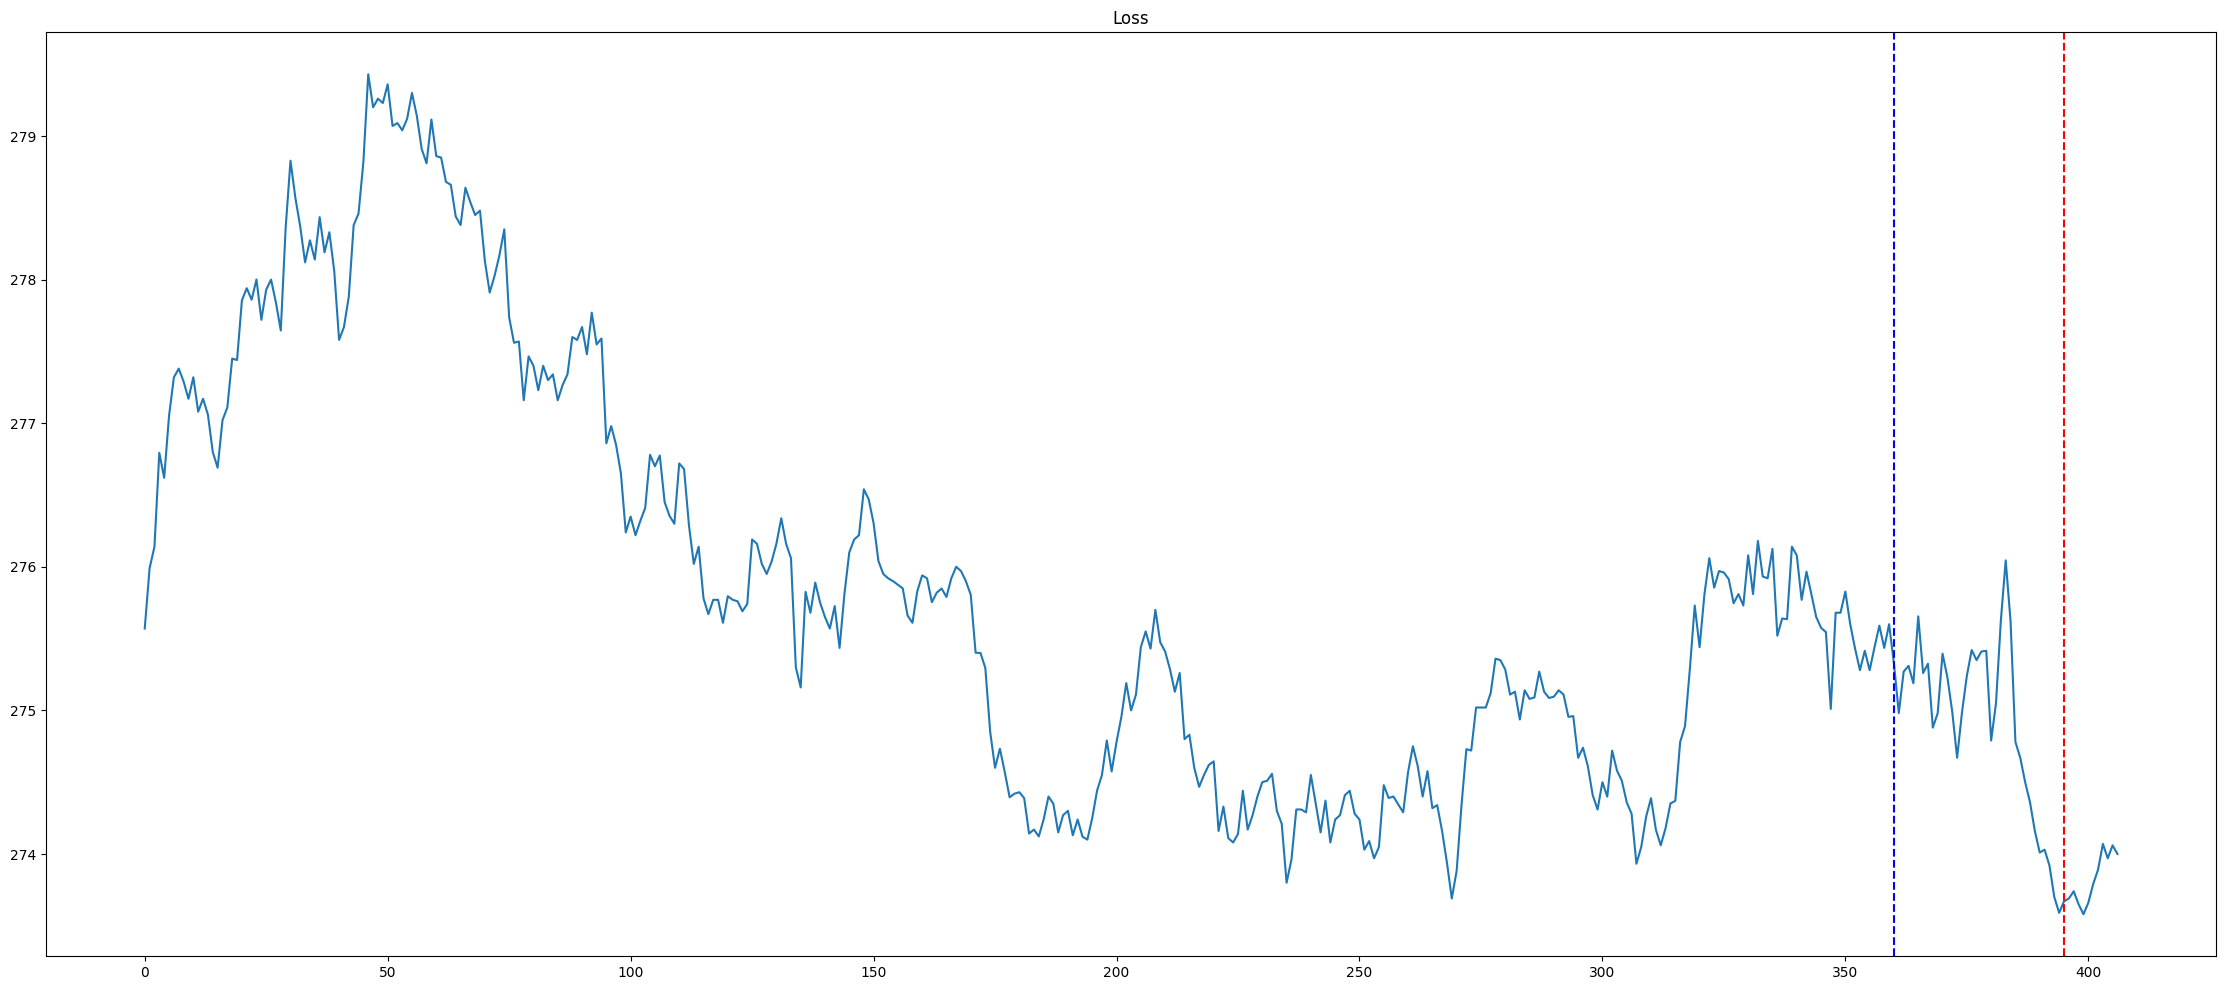

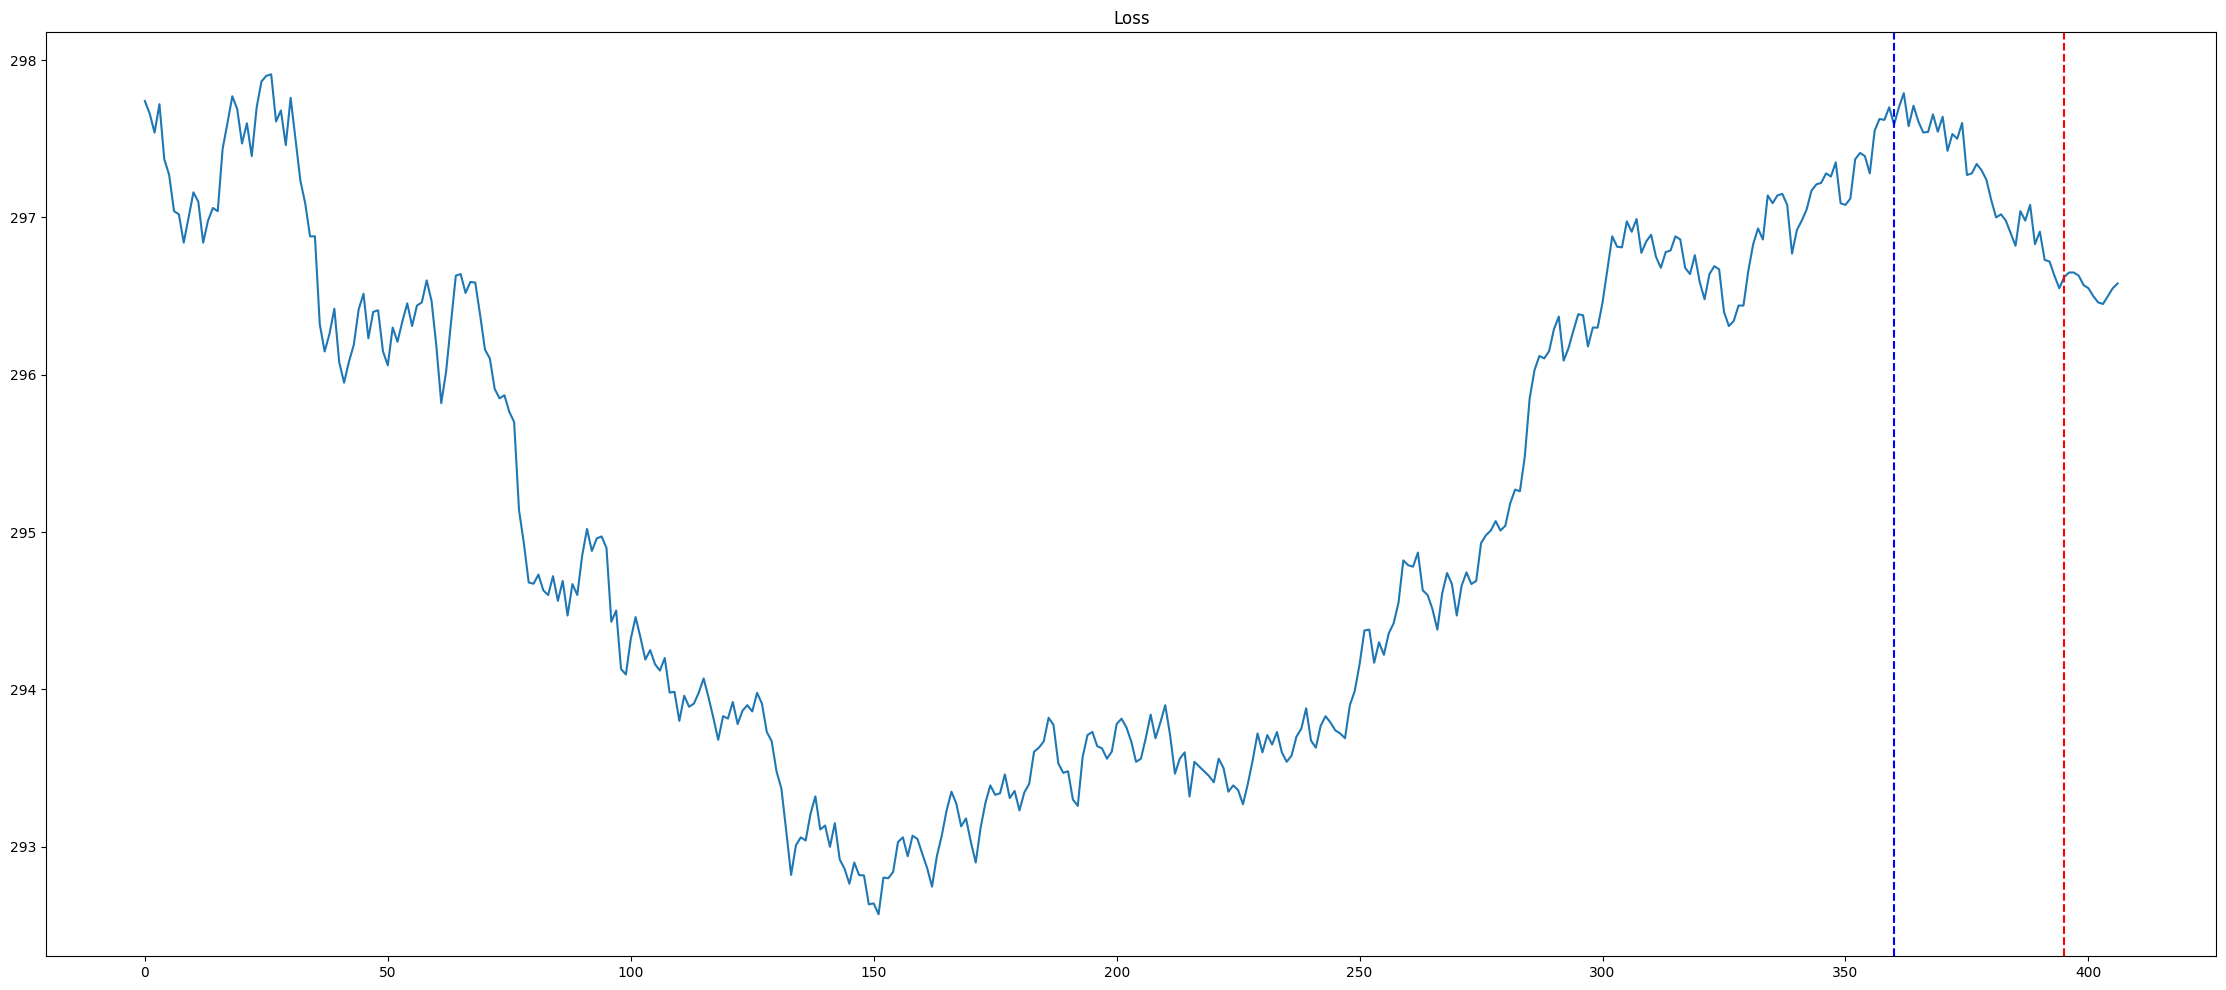

In [564]:
capital = 10000
history = [capital]
err = 0
for date in tqdm(res_df.date.unique()[-50:]):
    res_df_date = res_df[res_df['date'] == date].reset_index(drop=True)
    try:
        if is_valid(res_df_date):
            buy_price = res_df_date[res_df_date['time'] == "15:30:00"]['o'].values[0]
            share = capital * 1.0 / buy_price
            close_price = res_df_date[res_df_date['time'] == "16:05:00"]['c'].values[0]
            capital = share * close_price
            if close_price < buy_price*0.997:
                plt.plot(res_df_date['c'].values)
                plt.title("Loss")
                plt.axvline(x=res_df_date[res_df_date['time'] == "15:30:00"].index.values[0], color='b', linestyle='--')
                plt.axvline(x=res_df_date[res_df_date['time'] == "16:05:00"].index.values[0], color='r', linestyle='--')
                plt.show()
            if close_price > buy_price*1.003:
                plt.plot(res_df_date['c'].values)
                plt.axvline(x=res_df_date[res_df_date['time'] == "15:30:00"].index.values[0], color='b', linestyle='--')
                plt.axvline(x=res_df_date[res_df_date['time'] == "16:05:00"].index.values[0], color='r', linestyle='--')
                plt.title("Win")
                plt.show()
        history.append(capital)
    except Exception as e:
        err += 1
        if err > 10:
            print(err, e)
            break
        continue

In [ ]:
plt.plot(history)